Data Scientist TakeHome - Domestic & General

Candidate - Qing Shen

<div class="alert alert-info text-center" style="font-size: 2em; font-weight: bold;">Outline</div>

1. Problem Defining
2. Exploratory Data Analysis
3. Feature Engineering
4. Modelling
5. Post-model Analysis

<div class="alert alert-warning text-center" style="font-size: 2em; font-weight: bold;">Phone Customer Churn Predictor</div>

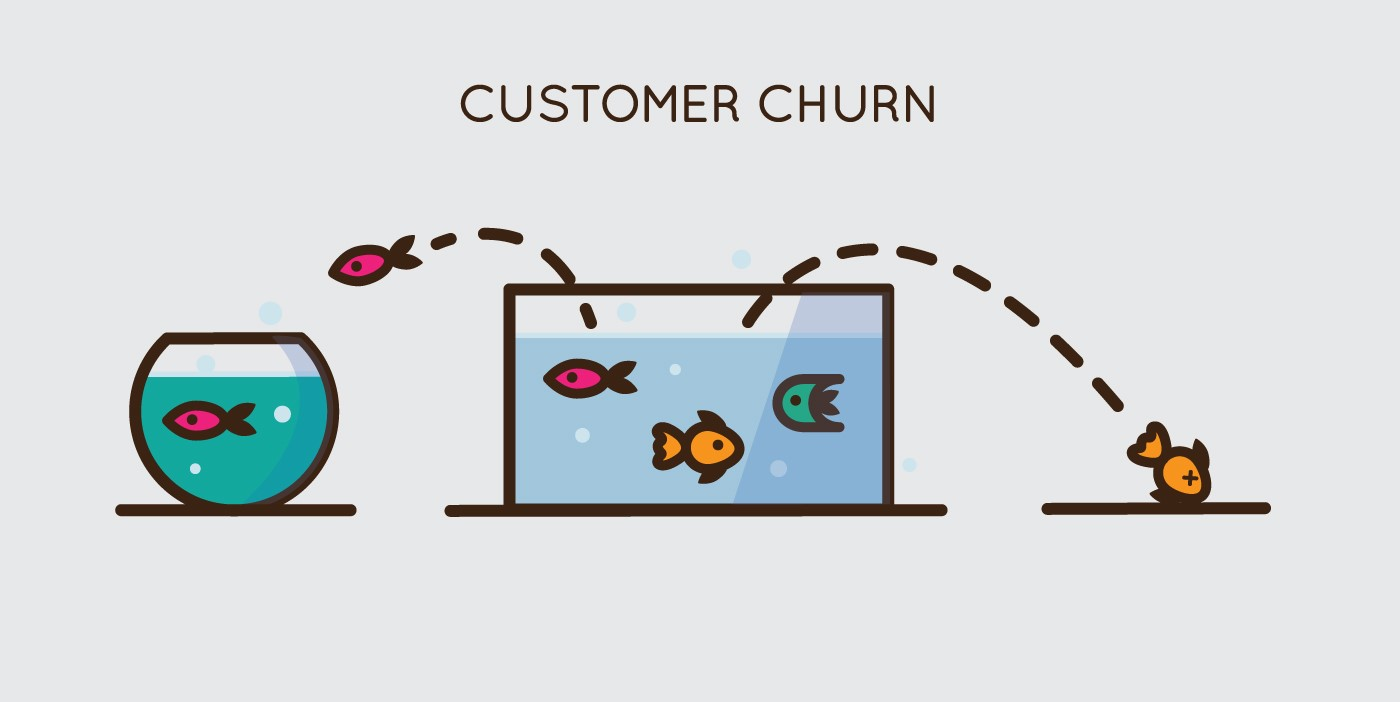

# Define Problem

**Client**: a fictional phone company that provided home phone and internet services to customers.

**Problem**: some customers have churned (left) their service, leading to the revenue lost for the company. In most cases, it costs more to acquire new customers than it does to retain existing ones. 

**Objective**: to build a predictive model for estimating the probability of a customer churning (leaving), allowing the company to take proactive measures to retain high-risk customers.

**Target**: Churn Value: A binary outcome indicating if the customer churned.
- 1: churned
- 0: not churned
    
**Features**: Demographic, account & service data for each customer. 


**Models**: binary classification models. We can try Logistic Regression, tree-based models etc.

**Benchmark**: 26.5% of customers who eventually churned.
- Churn rate: 26.5%

**Metrics**: 
- **Recall**: measures the proportion of actual positives that were identified correctly (i.e., of the customers who churn, how many did the model correctly identify?). We might care more about recall. It's often more critical to capture as many actual churn cases as possible, because it's often more costly to miss an actual churn customer (a false negative) than to falsely identify a not churned customer as a churned customer (a false positive).
- **Precision**: measures the proportion of positive identifications that were actually correct (i.e., of the customers the model predicts will churn, how many actually do?). If the cost of falsely identifying a not churned customer as a churned customer is high (for example, if this leads to unsatisfication of customers), precision might be more important. We want to be sure that the ones we are predicting as churn are actually likely to churn.
- **F1 score**: the harmonic mean of precision and recall, providing a balance between them. If we care both recall and precision, we may use f1 score.
- **ROC-AUC**: measures the trade-off between the true positive rate and false positive rate at all threshold settings, and it's less affected by imbalanced classes. It measures the model's ability to distinguish between positive and negative instances. We may use it to compare different models or tuning hyperparameters and select the one with the highest performance.
- **Accuracy**: measures the proportion of total predictions that are correct. However, it might not be the best measure if the classes are imbalanced (e.g., if only a small percentage of customers churn).

**Others**: regulatory considerations for using certain types of data 

**Pipeline**: 

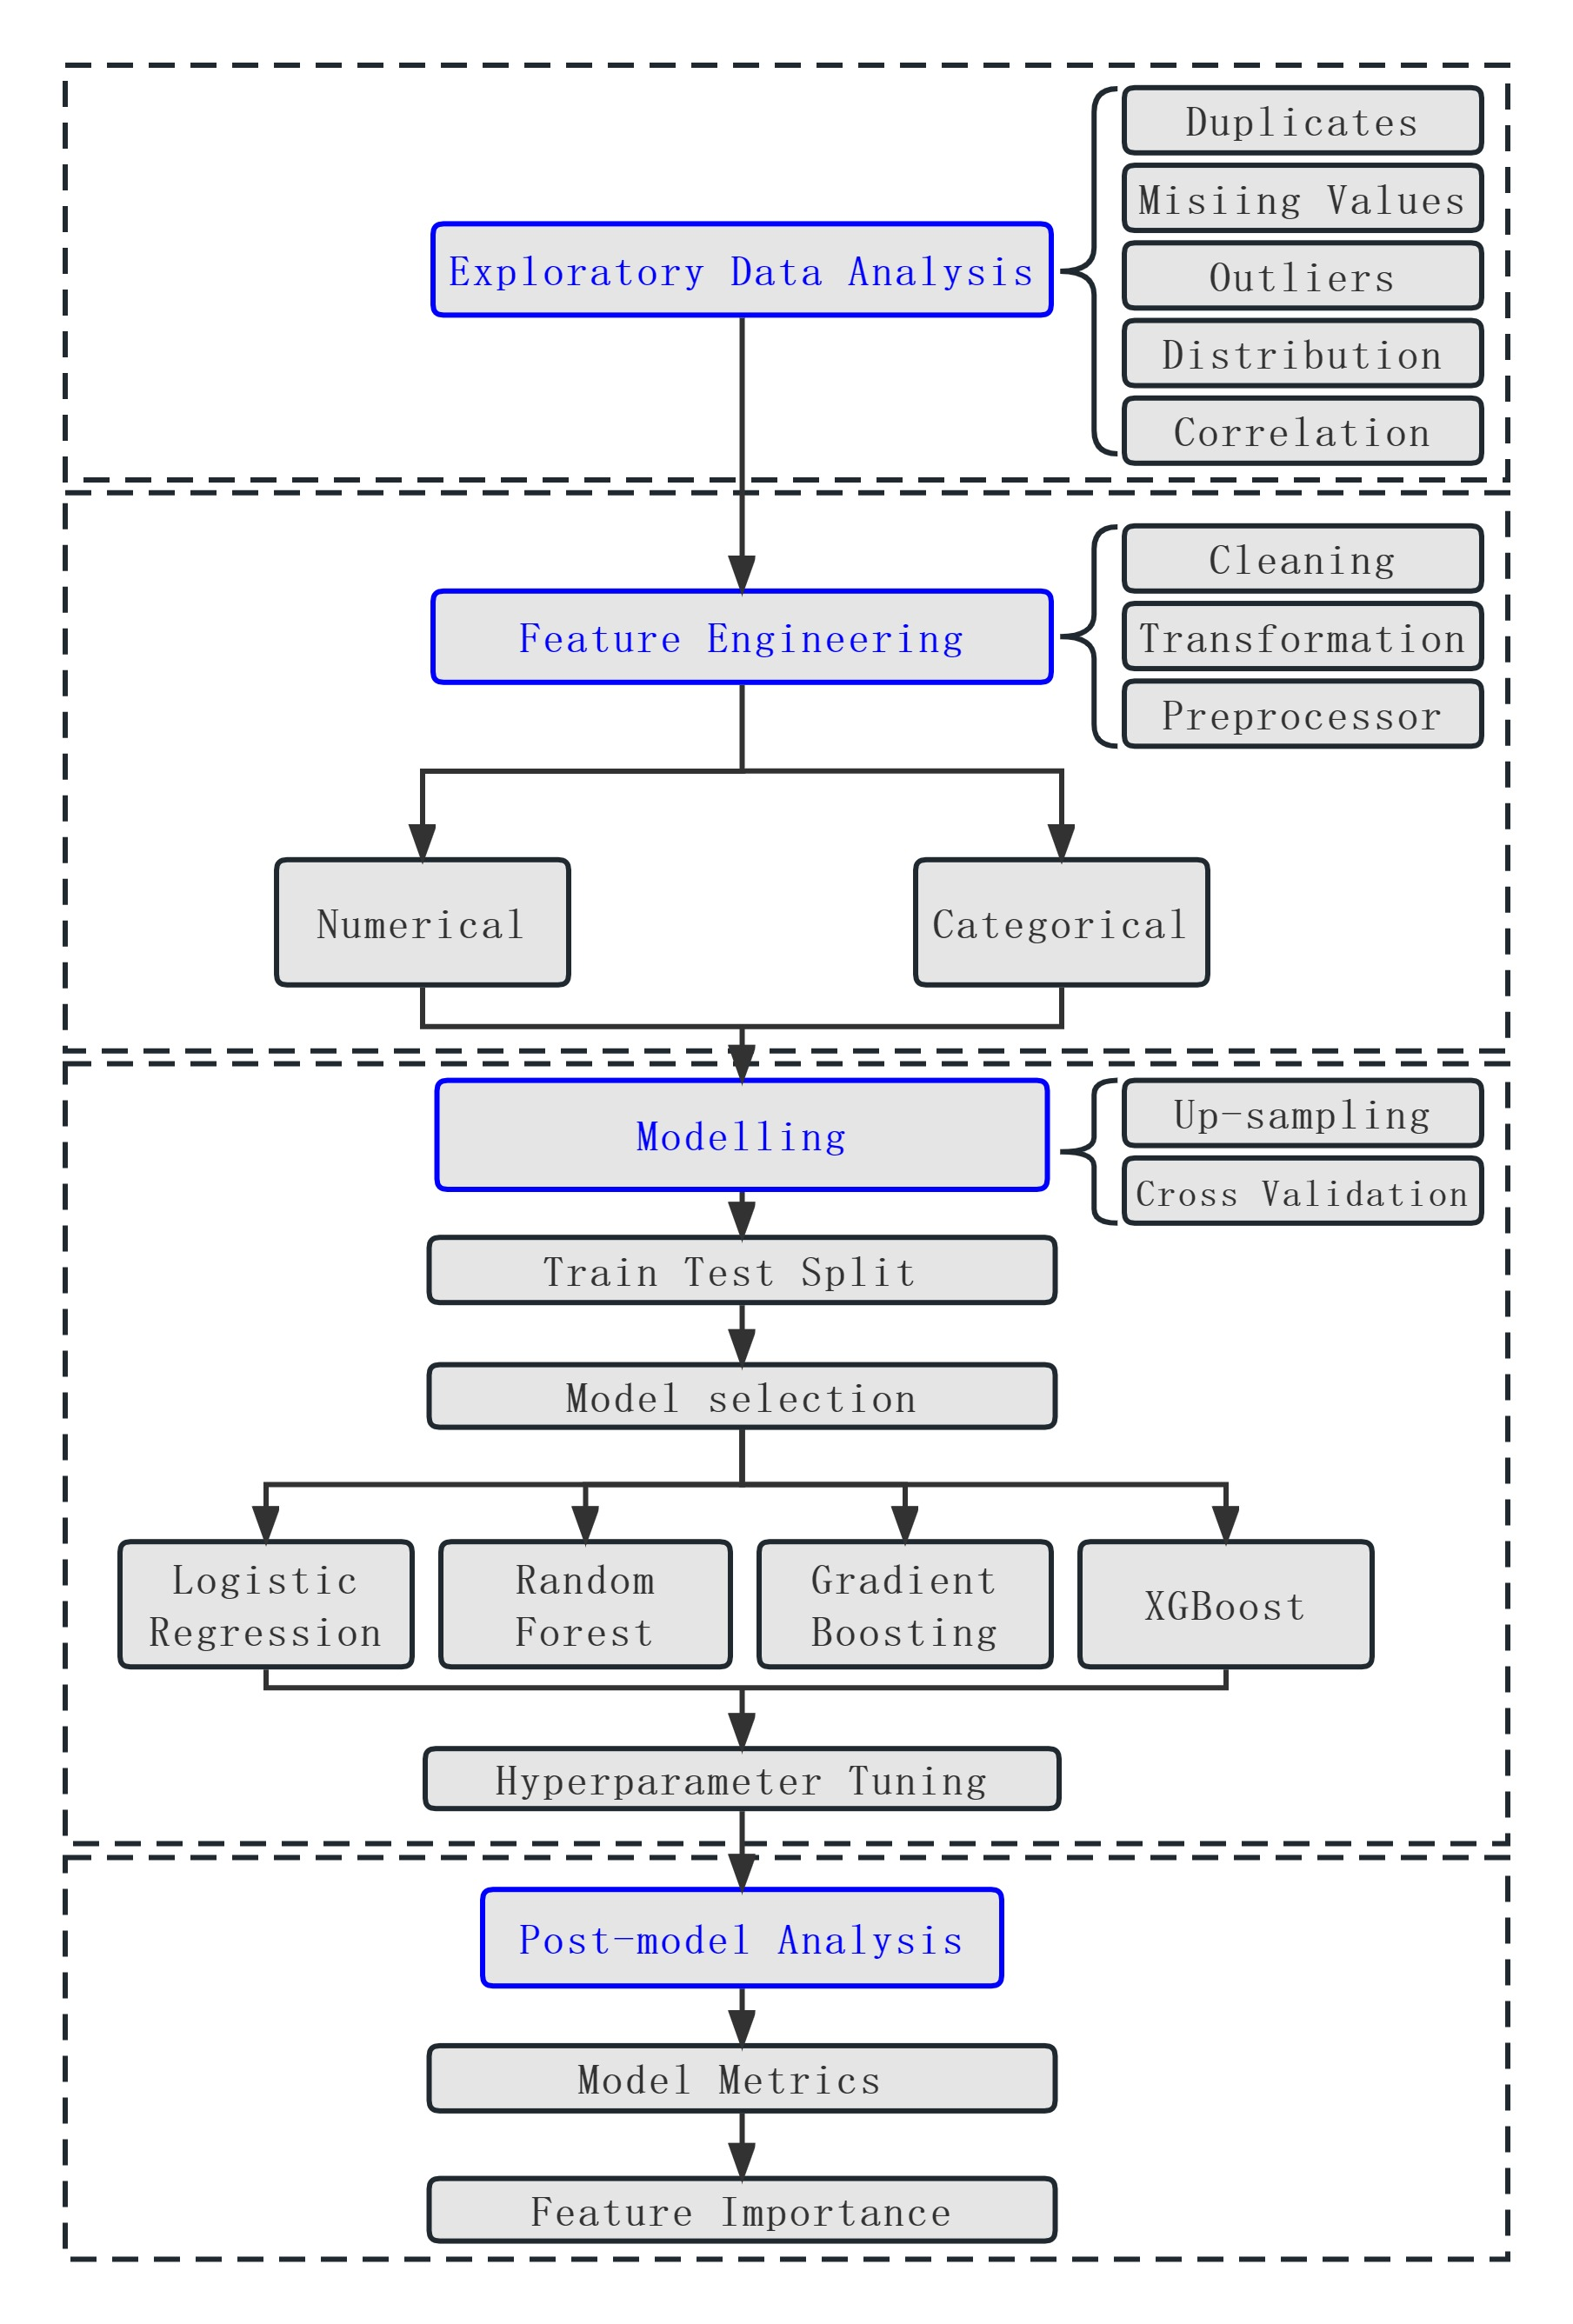

# Exploratory Data Analysis

## Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import math
import phik
import statsmodels.api as sm
from scipy.stats import chi2_contingency, randint, uniform,ttest_ind
from scipy import stats
from phik import resources, report
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings('ignore')

## Common functions

In [4]:
def t_test(df, target_column, value_column):
    """
    Perform a t-test to compare the mean values between two groups.

    Parameters:
    df : pandas.DataFrame
        The DataFrame to use.
    target_column : str
        The name of the target variable/column in the DataFrame.
    value_column : str
        The name of the variable/column to compare in the DataFrame.

    Returns:
    float, float
        The t-statistic and the p-value of the test.
    """
    group1 = df[df[target_column]==1][value_column].dropna()
    group0 = df[df[target_column]==0][value_column].dropna()

    t_stat, p_value = stats.ttest_ind(group1, group0)

    return t_stat, p_value

In [5]:
def chi_square_test(df, var1, var2):
    """
    Perform a Chi-square test of independence.

    Parameters:
    df : pandas.DataFrame
        The DataFrame to use.
    var1 : str
        The name of the first variable/column in the DataFrame.
    var2 : str
        The name of the second variable/column in the DataFrame.

    Returns:
    float, float
        The Chi-square statistic and the p-value of the test.
    """
    # Create a cross-tabulation table
    table = pd.crosstab(df[var1], df[var2])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(table)

    return chi2, p

In [6]:
def plot_roc_curve(model, X_train, y_train, X_test, y_test, model_name):
    # Compute predicted probabilities
    y_train_pred_proba = model.predict_proba(X_train)[:,1]
    y_test_pred_proba = model.predict_proba(X_test)[:,1]

    # Compute ROC AUC scores
    roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

    print(f"{model_name} ROC AUC (train): {roc_auc_train:.3f}")
    print(f"{model_name} ROC AUC (test): {roc_auc_test:.3f}")

    # Compute ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'ROC curve (train) (area = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'ROC curve (test) (area = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualize the confusion matrix as a heatmap
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Load data

In [ ]:
# Load the dataset
file1_df = pd.read_excel('processed.cleveland.xlsx')
file1_df.replace('?', np.nan, inplace=True)
file2_df = pd.read_excel('processed.hungarian.xlsx')
file2_df.replace('?', np.nan, inplace=True)
file3_df = pd.read_excel('processed.switzerland.xlsx')
file3_df.replace('?', np.nan, inplace=True)

df = pd.concat([file1_df, file2_df, file3_df], ignore_index=True)

df.to_excel('combined_data.xlsx', index=False)


In [ ]:

pd.set_option('display.max_columns', None)
df.head()

## Basic information of the dataframe

In [2]:
# Check how many rows and columns
df.shape

NameError: name 'df' is not defined

In [3]:
# Display the info
df.info()

NameError: name 'df' is not defined

In [4]:
#df['fbs'] = df['fbs'].astype(int)


In [11]:
# Count nemerical and categorical columns
#cat_col = [x for x in df.columns if df[x].dtype == 'O']
#num_col = [x for x in df.columns if x not in cat_col]
cat_col = ['sex','cp','fbs','restecg','exang','slope','thal','target']
num_col = ['age','trestbps','chol','thalach','oldpeak','ca']
# Print number of categorical and numerical columns in df
print('Number of categorical columns in df: {}'.format(len(cat_col)))
print('Number of numerical columns in df: {}'.format(len(num_col)))

# Print the names of the categorical columns in df
print('Categorical columns in df:')
for col in cat_col:
    print(col)

# Print the names of the numerical columns in df
print('Numerical columns in df:')
for col in num_col:
    print(col)

Number of categorical columns in df: 8
Number of numerical columns in df: 6
Categorical columns in df:
sex
cp
fbs
restecg
exang
slope
thal
target
Numerical columns in df:
age
trestbps
chol
thalach
oldpeak
ca


### Duplicates

In [12]:
# Check number of duplicates in dataframe
df.duplicated().sum()

1

In [13]:
df = df.drop_duplicates()
df

age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1    145.00 233.00 1.00     2.00   150.00   0.00     2.30   
1     67    1   4    160.00 286.00 0.00     2.00   108.00   1.00     1.50   
2     67    1   4    120.00 229.00 0.00     2.00   129.00   1.00     2.60   
3     37    1   3    130.00 250.00 0.00     0.00   187.00   0.00     3.50   
4     41    0   2    130.00 204.00 0.00     2.00   172.00   0.00     1.40   
..   ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
715   70    1   4    115.00   0.00 0.00     1.00    92.00   1.00     0.00   
716   70    1   4    140.00   0.00 1.00     0.00   157.00   1.00     2.00   
717   72    1   3    160.00   0.00  NaN     2.00   114.00   0.00     1.60   
718   73    0   3    160.00   0.00 0.00     1.00   121.00   0.00     0.00   
719   74    1   2    145.00   0.00  NaN     1.00   123.00   0.00     1.30   

     slope   ca  thal  target  
0     3.00 0.00  6.00       0  
1     2.00 3.00  3.00       2  
2     2.00 2.00  7.00       1  
3     3.00 0.00  3.00       0  
4     1.00 0.00  3.00       0  
..     ...  ...   ...     ...  
715   2.00  NaN  7.00       1  
716   2.00  NaN  7.00       3  
717   2.00 2.00   NaN       0  
718   1.00  NaN  3.00       1  
719   1.00  NaN   NaN       1  

[719 rows x 14 columns]

- No duplicates.

### Missing values 

In [14]:
# Create a dataframe for missing data analysis
missing_data = pd.DataFrame({'Total Missing': df.isnull().sum(), 'Percentage Missing': (df.isnull().sum()/len(df))*100})

# Print the dataframe
missing_data

Total Missing  Percentage Missing
age                   0                0.00
sex                   0                0.00
cp                    0                0.00
trestbps              3                0.42
chol                 22                3.06
fbs                  83               11.54
restecg               2                0.28
thalach               2                0.28
exang                 2                0.28
oldpeak               6                0.83
slope               206               28.65
ca                  412               57.30
thal                319               44.37
target                0                0.00

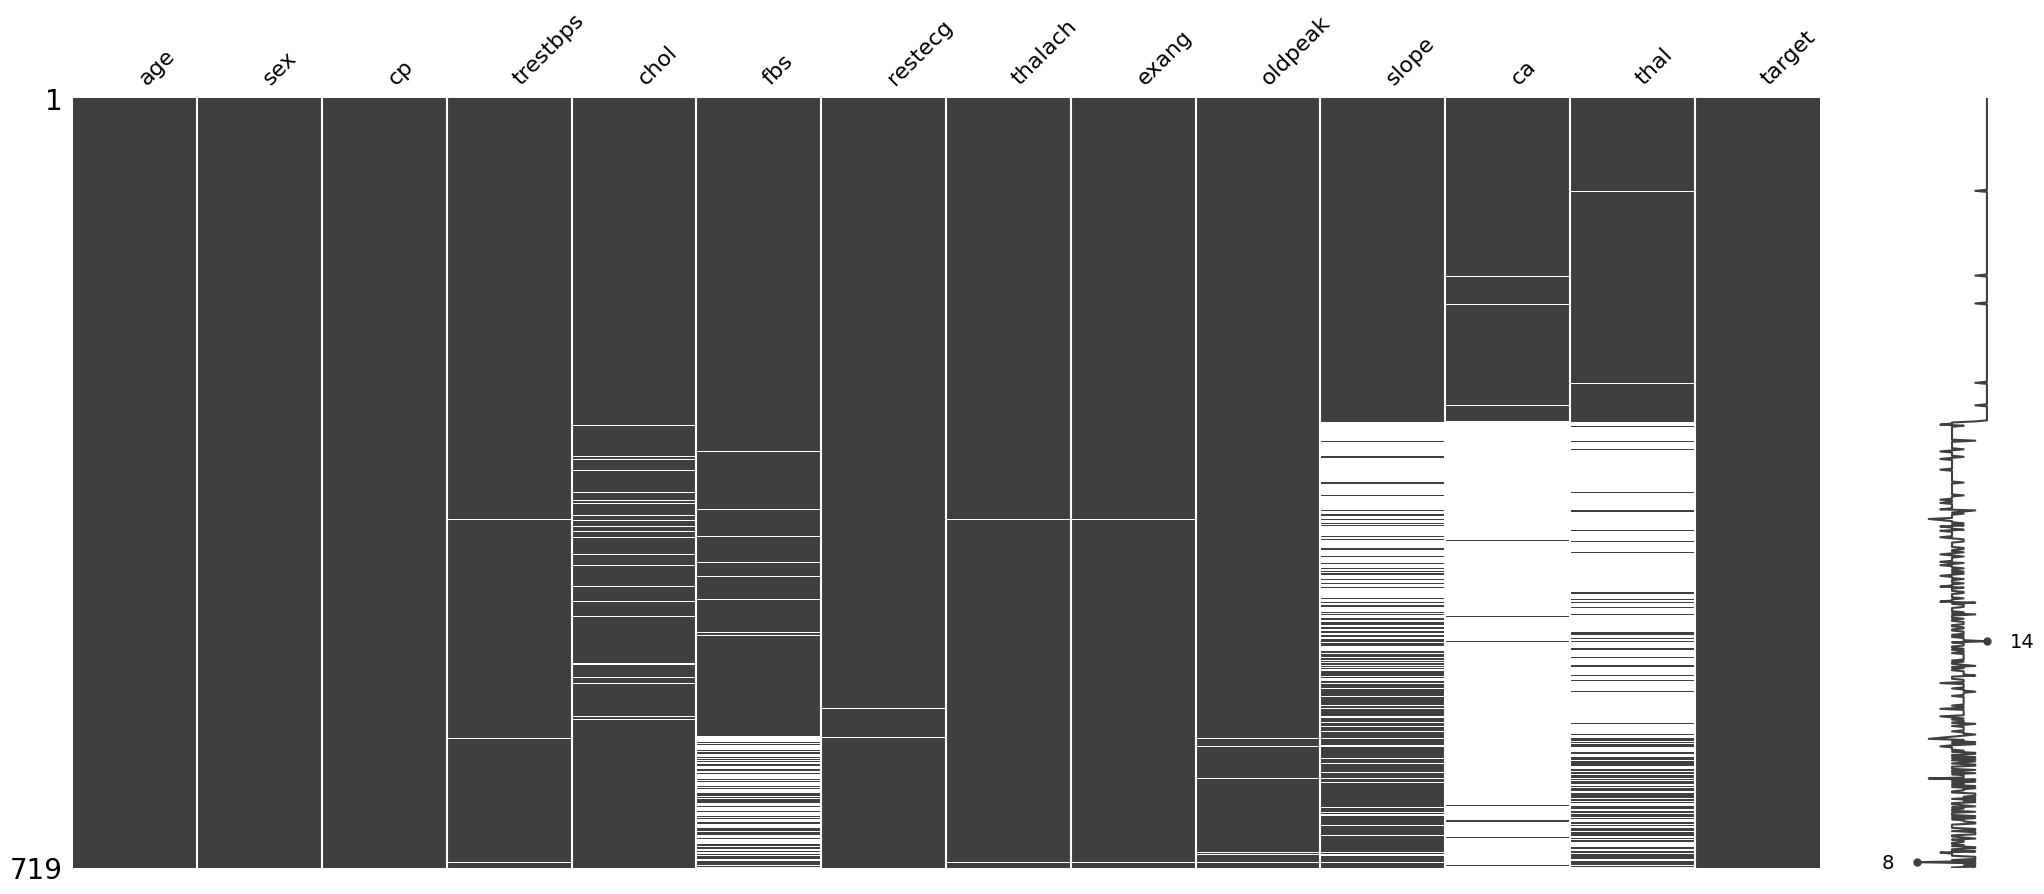

In [15]:
# Visualize missing values
msno.matrix(df)
plt.show()

# If the data point is filled, it means there is a value present in that cell. 
# If it's blank, it means the cell is missing a value.

- 10 columns of hungarian and switzerland data have missing values.
- Percentage of missing is high for slope, ca, thal:28.65%, 57.30%, 44.37%.
  slope: the slope of the peak exercise ST segment( Value 1: upsloping,Value 2: flat,Value 3: downsloping)
  ca: number of major vessels (0-3) colored by flourosopy
  thal:A blood disorder called thalassemia. (3 = normal; 6 = fixed defect; 7 = reversable defect)
- These 3 columns could not be aquired during the transport of ambulence service, which are not useful for the prediction.
- So I will drop them.

## Target - num Value

- We have 1 columns referring whether people are diagnosed to have heart disease, called 'num'.

In [16]:
df['target'].value_counts()

target
0    359
1    209
2     68
3     65
4     18
Name: count, dtype: int64

Target Value: A binary outcome indicating if diagnosis of heart disease.
- 1: have heart disease
- 0: not have heart disease

In [17]:
# Define a mapping dictionary
mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
# Apply the mapping to the 'target' column
df['target'] = df['target'].map(mapping)
df

age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1    145.00 233.00 1.00     2.00   150.00   0.00     2.30   
1     67    1   4    160.00 286.00 0.00     2.00   108.00   1.00     1.50   
2     67    1   4    120.00 229.00 0.00     2.00   129.00   1.00     2.60   
3     37    1   3    130.00 250.00 0.00     0.00   187.00   0.00     3.50   
4     41    0   2    130.00 204.00 0.00     2.00   172.00   0.00     1.40   
..   ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
715   70    1   4    115.00   0.00 0.00     1.00    92.00   1.00     0.00   
716   70    1   4    140.00   0.00 1.00     0.00   157.00   1.00     2.00   
717   72    1   3    160.00   0.00  NaN     2.00   114.00   0.00     1.60   
718   73    0   3    160.00   0.00 0.00     1.00   121.00   0.00     0.00   
719   74    1   2    145.00   0.00  NaN     1.00   123.00   0.00     1.30   

     slope   ca  thal  target  
0     3.00 0.00  6.00       0  
1     2.00 3.00  3.00       1  
2     2.00 2.00  7.00       1  
3     3.00 0.00  3.00       0  
4     1.00 0.00  3.00       0  
..     ...  ...   ...     ...  
715   2.00  NaN  7.00       1  
716   2.00  NaN  7.00       1  
717   2.00 2.00   NaN       0  
718   1.00  NaN  3.00       1  
719   1.00  NaN   NaN       1  

[719 rows x 14 columns]

In [18]:
# Percentage of each target class
df['target'].value_counts(normalize=True) * 100

target
1   50.07
0   49.93
Name: proportion, dtype: float64

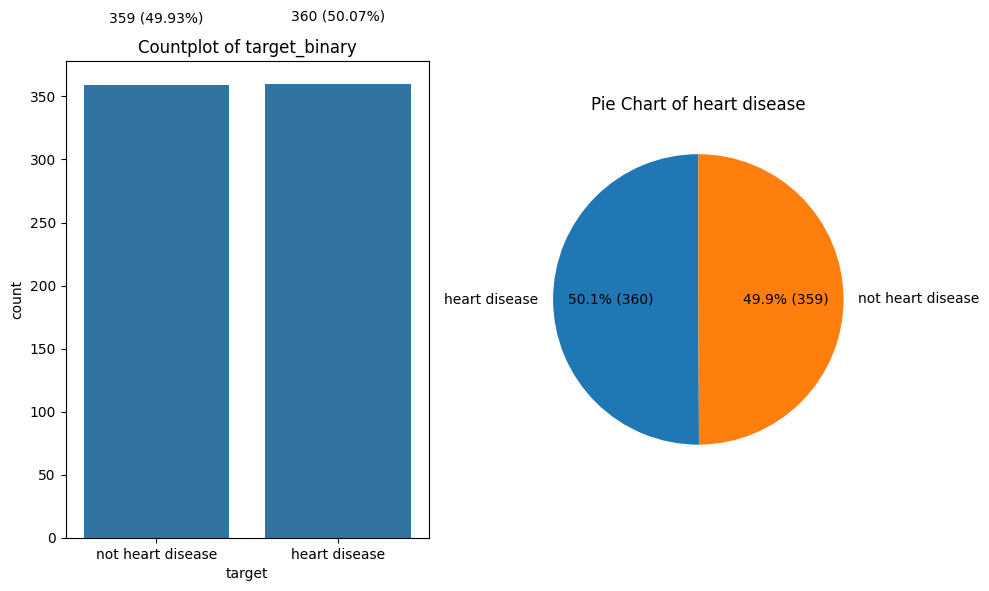

In [19]:
# Visualization
counts = df['target'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Create countplot
sns.countplot(x='target', data=df, ax=axs[0])
axs[0].set_title('Countplot of target_binary')
axs[0].set_xticklabels(['not heart disease', 'heart disease'])

# Add counts and proportions on top of each bar
total = len(df)
for i in range(counts.shape[0]):
    count = counts[i]
    proportion = 100 * count / total
    axs[0].text(i, count+50, f'{count} ({proportion:.2f}%)', ha='center')

# Create pie chart
axs[1].pie(counts, labels=['heart disease', 'not heart disease'], autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*counts.sum()), startangle=90)
axs[1].set_title('Pie Chart of heart disease')

plt.tight_layout()
plt.show()

## Overview of Numerical Features

### Summary statistics 

In [20]:
# Get the summary statistics
df[num_col].describe()

age  trestbps   chol  thalach  oldpeak     ca
count 719.00    716.00 697.00   717.00   713.00 307.00
mean   51.89    131.84 204.77   140.54     0.79   0.68
std     9.20     18.52 109.28    25.65     1.07   0.94
min    28.00     80.00   0.00    60.00    -2.60   0.00
25%    45.00    120.00 182.00   122.00     0.00   0.00
50%    53.00    130.00 227.00   142.00     0.20   0.00
75%    58.00    140.00 270.00   160.00     1.50   1.00
max    77.00    200.00 603.00   202.00     6.20   3.00

### Distribution

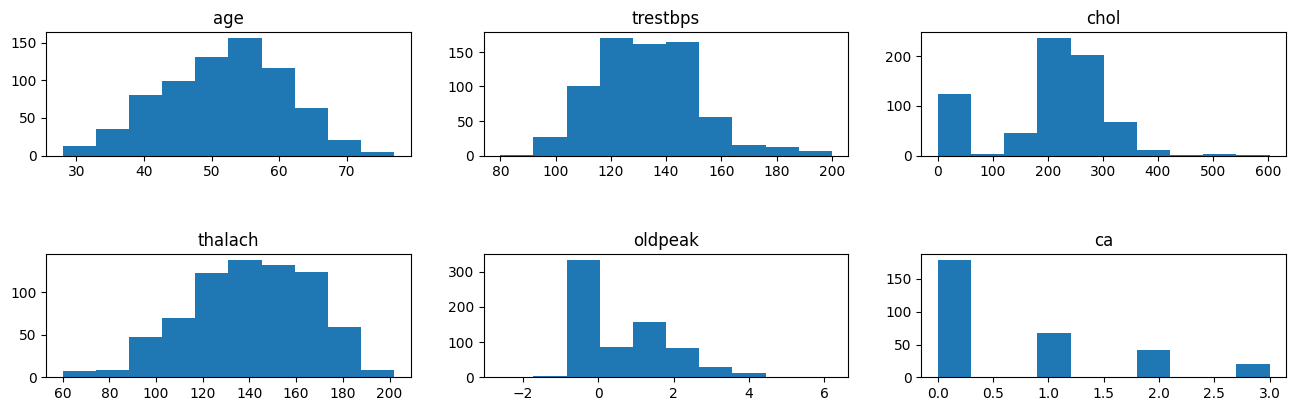

In [21]:
# Check the distribution of numerical columns
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.8)
for i,var in enumerate(num_col):
    ax = fig.add_subplot(6, 3, i+1)
    ax.hist(df[var])
    ax.set_title(var)

age        -0.12
trestbps    0.66
chol       -0.63
thalach    -0.33
oldpeak     1.23
ca          1.16
dtype: float64


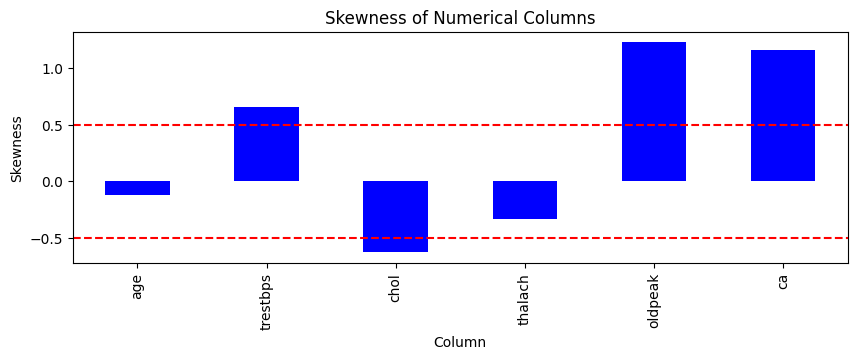

In [22]:
# Check and plot skewness of numrical columns
skewness = df[num_col].skew()
print(skewness)
plt.figure(figsize=(10,3))
ax = skewness.plot(kind='bar', color='blue')

# add dashed lines at the threshold values (0.5 and -0.5) for moderate skewness
ax.axhline(y=0.5, color='red', linestyle='--')
ax.axhline(y=-0.5, color='red', linestyle='--')

# add labels and title to the plot
ax.set_xlabel('Column')
ax.set_ylabel('Skewness')
ax.set_title('Skewness of Numerical Columns')
plt.show()

- 2 normally distributed features: age, thalach.
- 3 positively skewed features: trestbps, ddpeak, ca.
- 1 negatively skewed features: chol.

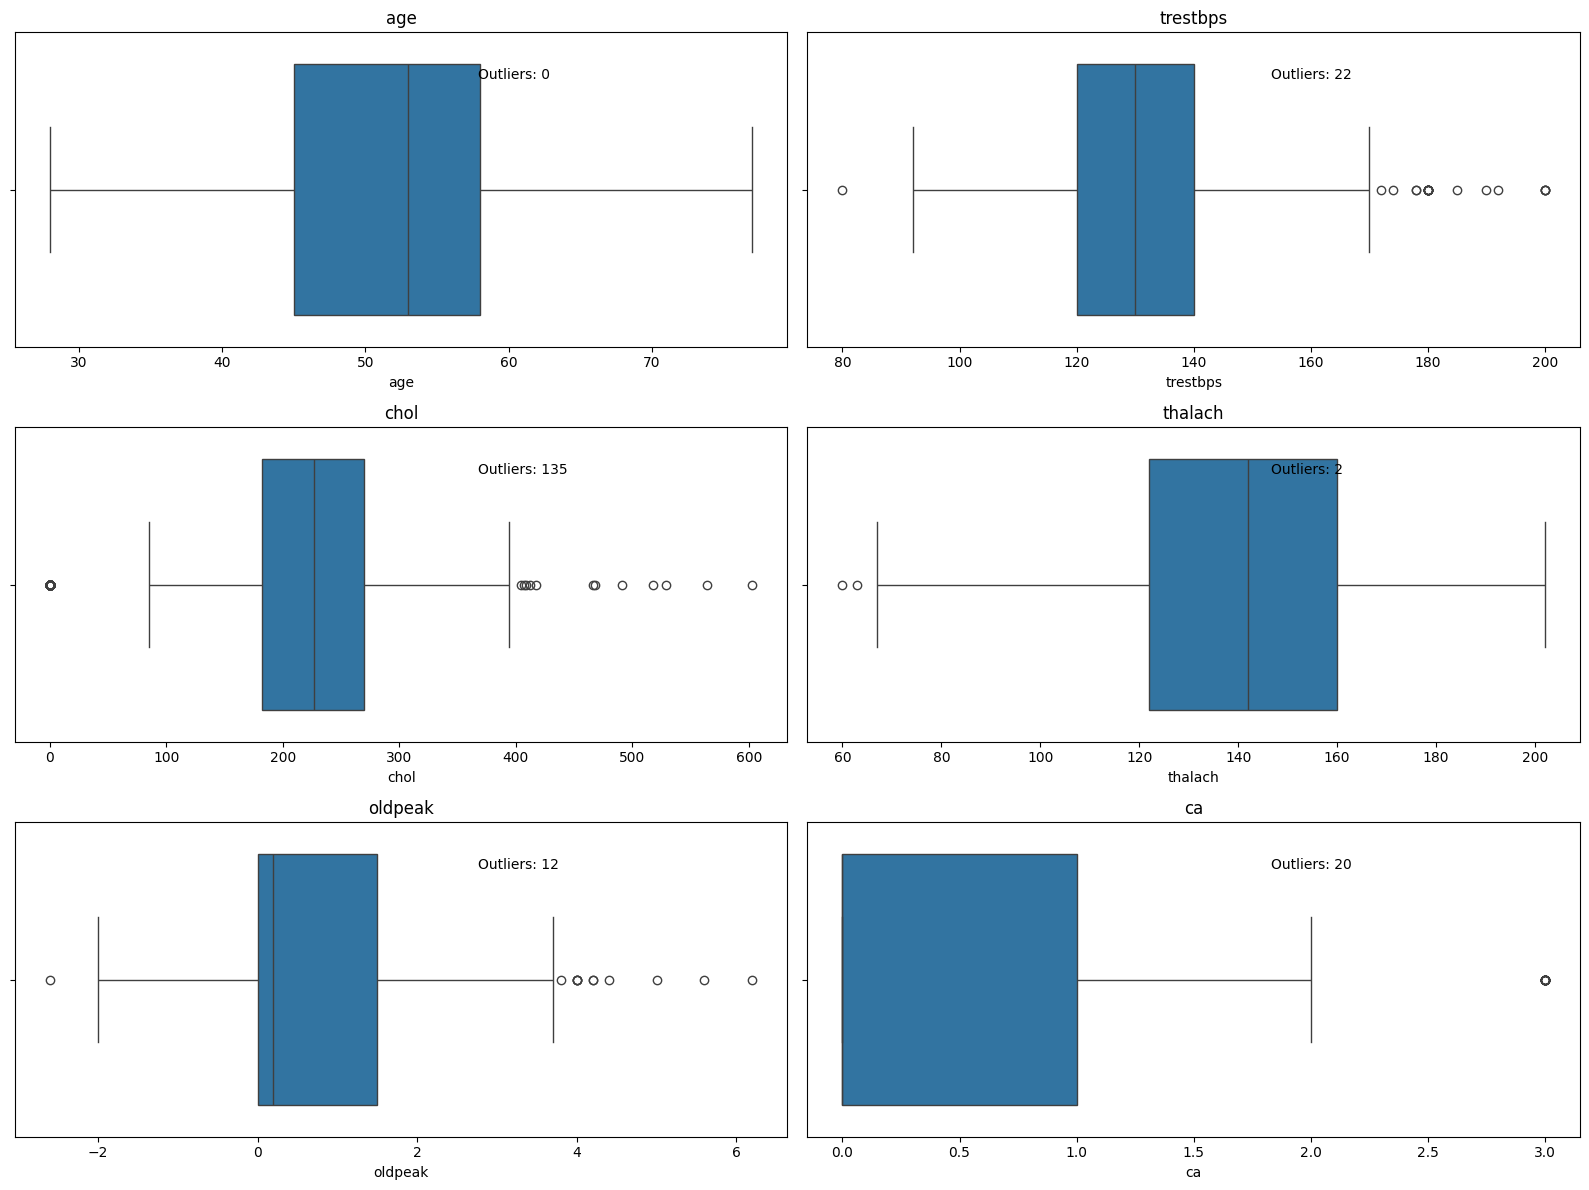

In [23]:
# Boxplot to check outliers:
n = len(num_col)
n_cols = 2
n_rows = n // n_cols + n % n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*4))

for i, column in enumerate(num_col):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(x=df[column], ax=axs[row, col])
    axs[row, col].set_title(column)

    # Calculate Q1, Q3 and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outliers
    outliers = ((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))

    # Count outliers and add to the plot
    num_outliers = outliers.sum()
    axs[row, col].annotate('Outliers: {}'.format(num_outliers), xy=(0.6, 0.85), xycoords='axes fraction')

# If number of num_col is odd, remove the last (empty) subplot
if n % 2:
    fig.delaxes(axs[row, col+1])

plt.tight_layout()
plt.show()


- 1 feature do not have outliers: age.
- 7 features have outliers: 'trestbps','chol','thalach','oldpeak','ca'.    

In [24]:
df.drop('ca', axis=1, inplace=True)
df.drop('thal', axis=1, inplace=True)
df.drop('slope', axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 719 entries, 0 to 719
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       719 non-null    int64  
 1   sex       719 non-null    int64  
 2   cp        719 non-null    int64  
 3   trestbps  716 non-null    float64
 4   chol      697 non-null    float64
 5   fbs       636 non-null    float64
 6   restecg   717 non-null    float64
 7   thalach   717 non-null    float64
 8   exang     717 non-null    float64
 9   oldpeak   713 non-null    float64
 10  target    719 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 67.4 KB


In [25]:
cat_col = ['sex','cp','fbs','restecg','exang']
num_col = ['age','trestbps','chol','thalach','oldpeak']

In [26]:
df = df.dropna().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       610 non-null    int64  
 1   sex       610 non-null    int64  
 2   cp        610 non-null    int64  
 3   trestbps  610 non-null    float64
 4   chol      610 non-null    float64
 5   fbs       610 non-null    float64
 6   restecg   610 non-null    float64
 7   thalach   610 non-null    float64
 8   exang     610 non-null    float64
 9   oldpeak   610 non-null    float64
 10  target    610 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 52.5 KB


### Univariate Analysis

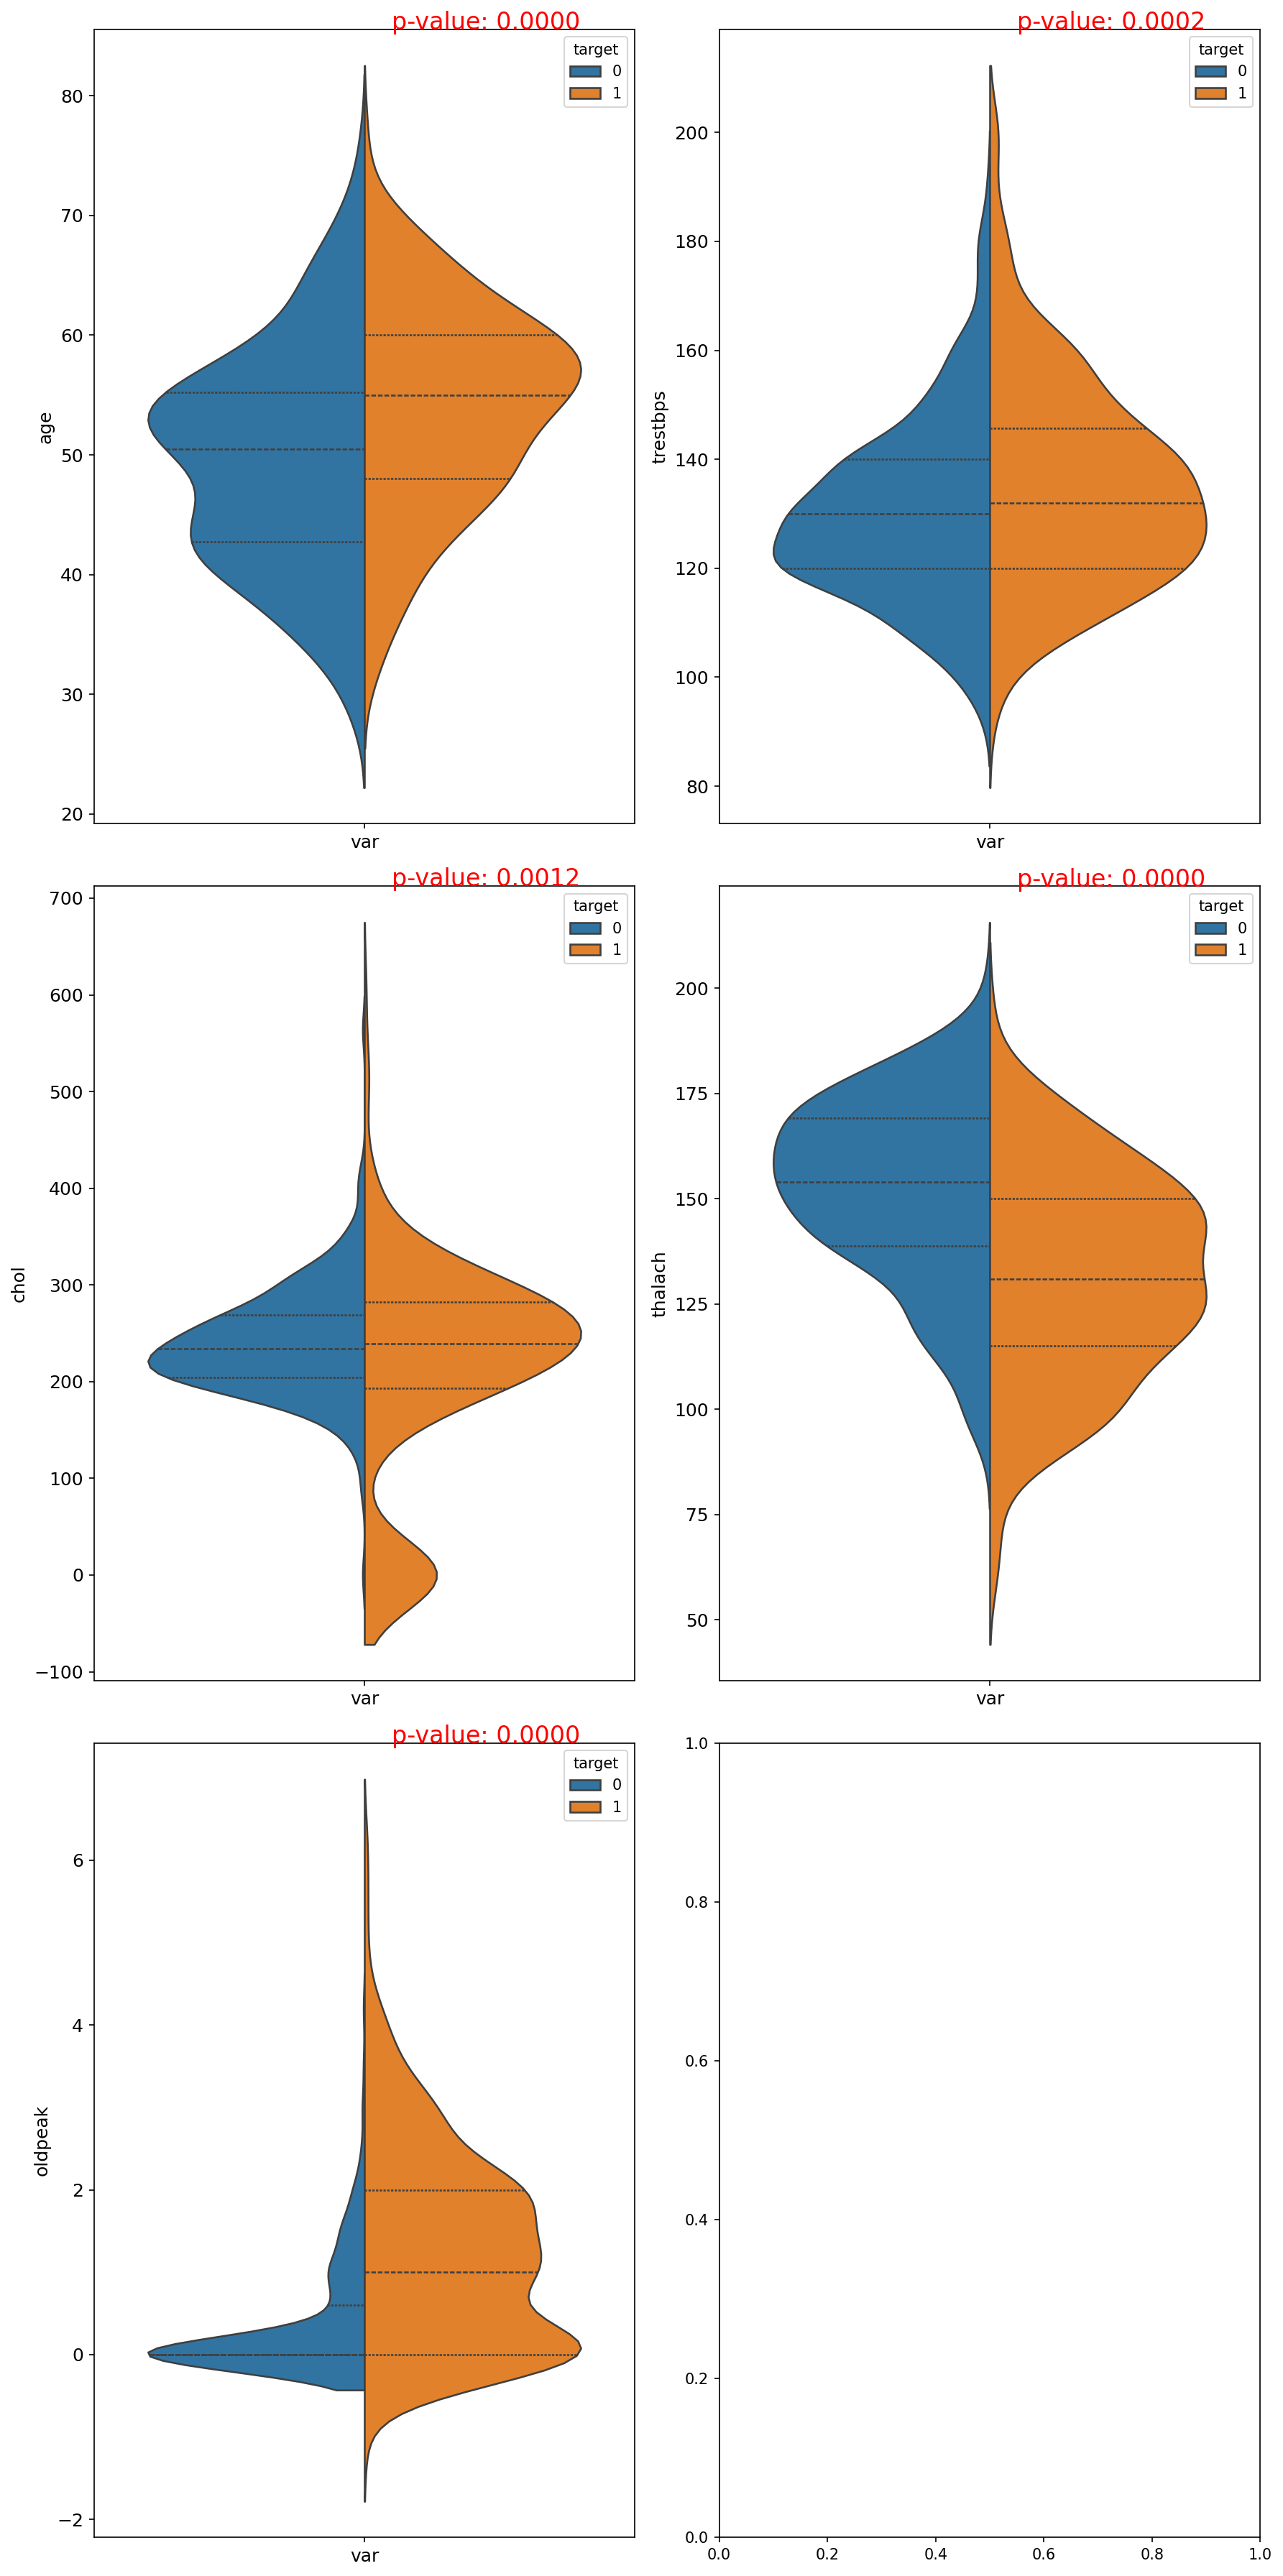

In [27]:
# Check distribution of target label 'target' in numerical features
#num_df = df[num_col].copy()
num_df = df[num_col + ['target']].copy()
num_df['var'] = 'var'
nrows = 3 
ncols = 2 
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 24), dpi=150)

for r in range(nrows):
    for c in range(ncols):
        i = r * ncols + c  # index of the current column
        if i >= len(num_col):  # check if we've reached the end of the columns
            break
        ax = sns.violinplot(x='var', y=num_col[i], data=num_df, hue='target', split=True, inner='quart', ax=axes[r, c])
        ax.set(xlabel=None)
        ax.set_ylabel(f'{num_col[i]}', fontsize=12)
        ax.tick_params(labelsize=12)
        
        # Perform t-test for the current numerical feature
        data_group_0 = num_df[num_df['target'] == 0][num_col[i]]
        data_group_1 = num_df[num_df['target'] == 1][num_col[i]]
        _, p_value = ttest_ind(data_group_0, data_group_1, nan_policy='omit')

        # Display the p-value on the plot in the top-left corner
        ax.text(0.05, ax.get_ylim()[1], f'p-value: {p_value:.4f}', ha='left', fontsize=16, color='red')

plt.tight_layout()
plt.show()

- all 6 numerical features show significant difference in distribution between heart_disease and not_heart_disease group. 

### Multivariate Analysis 

<Axes: >

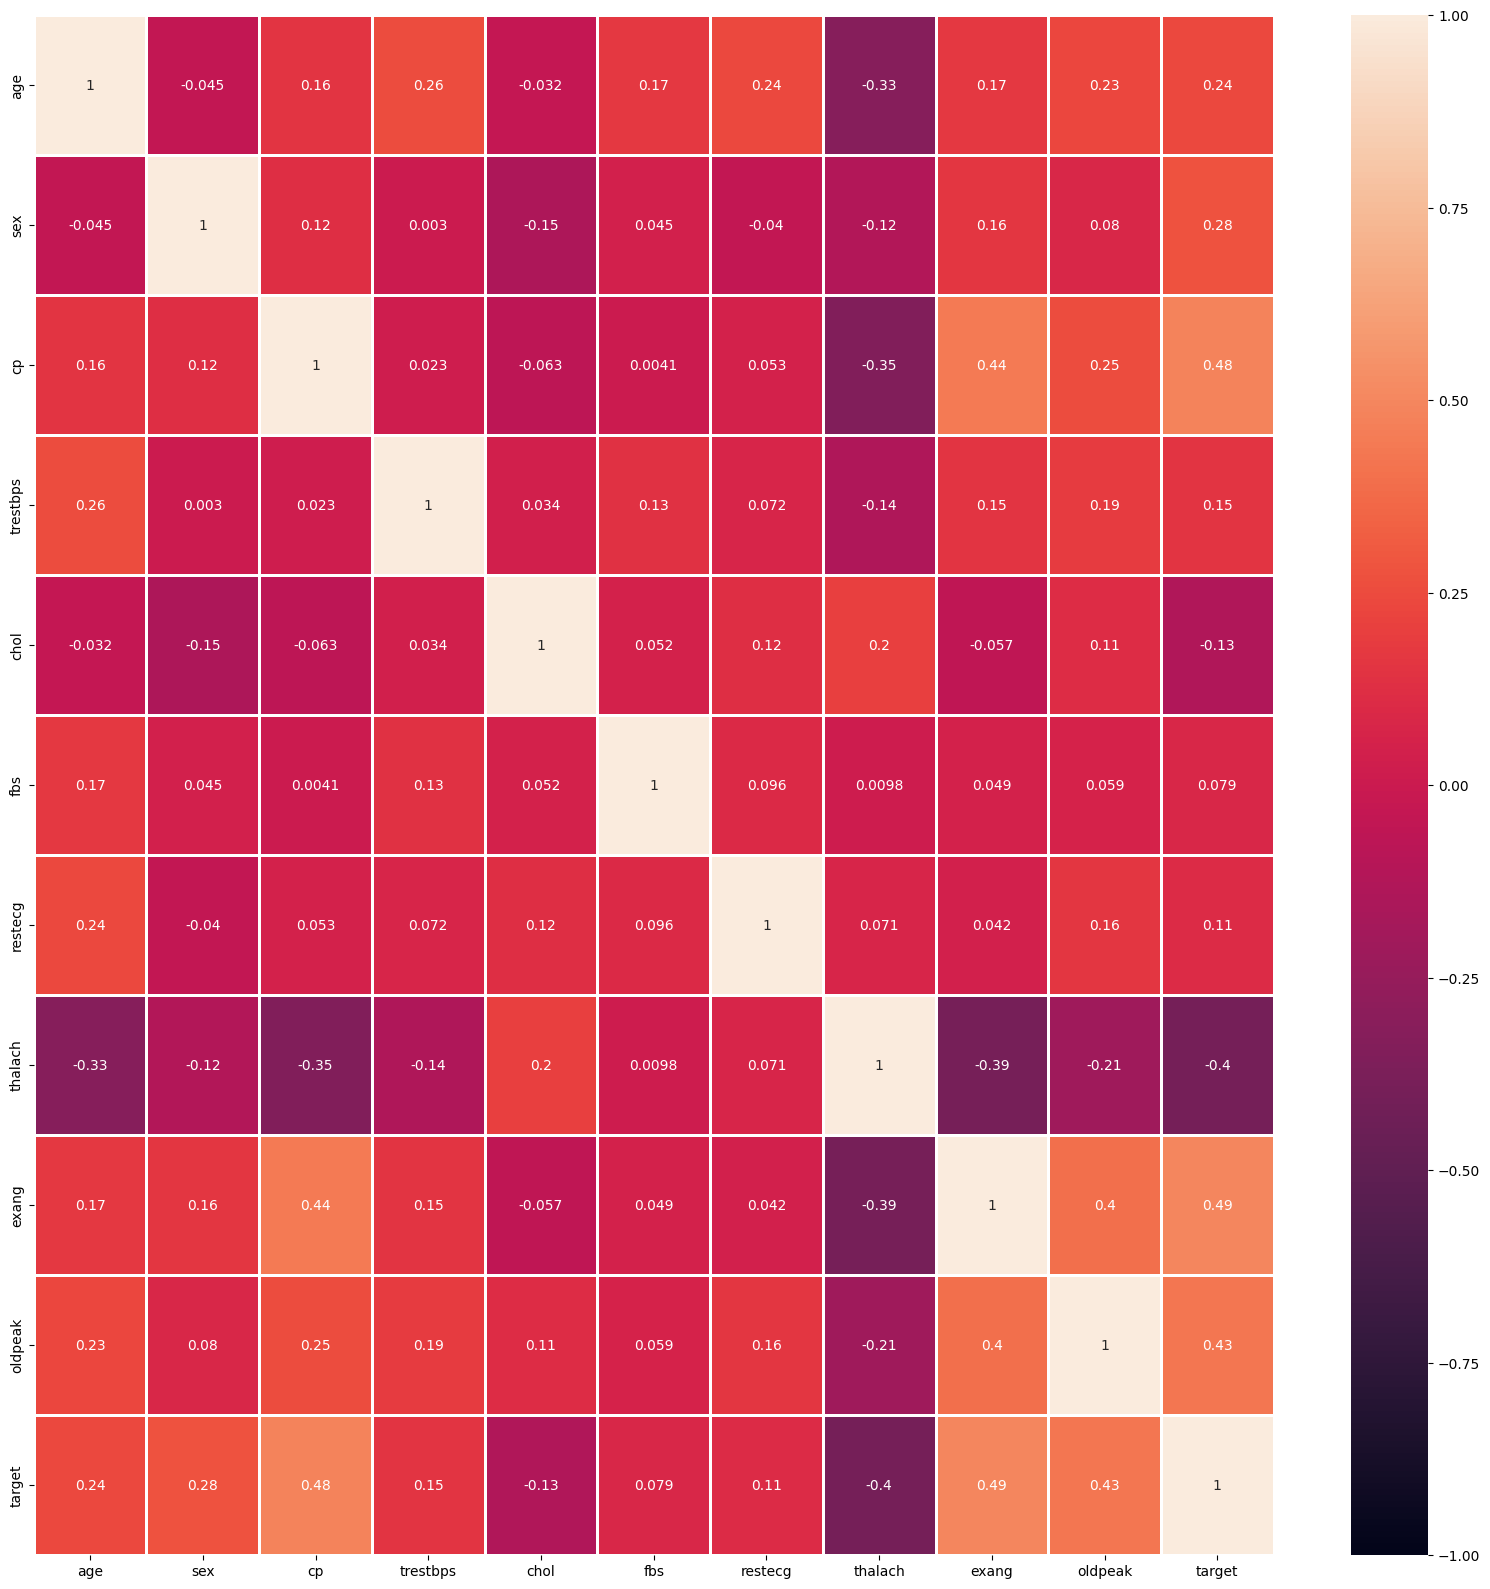

In [28]:
# Correlation analysis
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, lw=2, annot=True) 

- the highest correlation is 0.5 which is between thal and target.


In [29]:
# Check Variance Inflation Factor (VIF) score
# A VIF of 1 means that there is no correlation between a given independent variable and the other variables in the model; the independent variable is completely independent. 
# A VIF between 1 and 5 typically indicates moderate correlation, but is often considered acceptable. 
# A VIF greater than 5 can be a cause for concern and merits further investigation, as it suggests that the associated independent variable is highly collinear with the other variables in the model.

df_num = df[num_col]

# Calculate VIF for each numerical column
vif = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]
vif_df = pd.DataFrame({'Features': df_num.columns, 'VIF': vif})

vif_df

Features   VIF
0       age 28.88
1  trestbps 42.44
2      chol  8.58
3   thalach 22.76
4   oldpeak  1.78

## Overview of Categorical Features

### Summary statistics

In [30]:
# Get the summary statistics
df.describe

<bound method NDFrame.describe of      age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1    145.00 233.00 1.00     2.00   150.00   0.00     2.30   
1     67    1   4    160.00 286.00 0.00     2.00   108.00   1.00     1.50   
2     67    1   4    120.00 229.00 0.00     2.00   129.00   1.00     2.60   
3     37    1   3    130.00 250.00 0.00     0.00   187.00   0.00     3.50   
4     41    0   2    130.00 204.00 0.00     2.00   172.00   0.00     1.40   
..   ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
605   68    1   4    135.00   0.00 0.00     1.00   120.00   1.00     0.00   
606   69    1   4    135.00   0.00 0.00     0.00   130.00   0.00     0.00   
607   70    1   4    115.00   0.00 0.00     1.00    92.00   1.00     0.00   
608   70    1   4    140.00   0.00 1.00     0.00   157.00   1.00     2.00   
609   73    0   3    160.00   0.00 0.00     1.00   121.00   0.00     0.00   

     target  
0         0  
1         1  

### Distribution

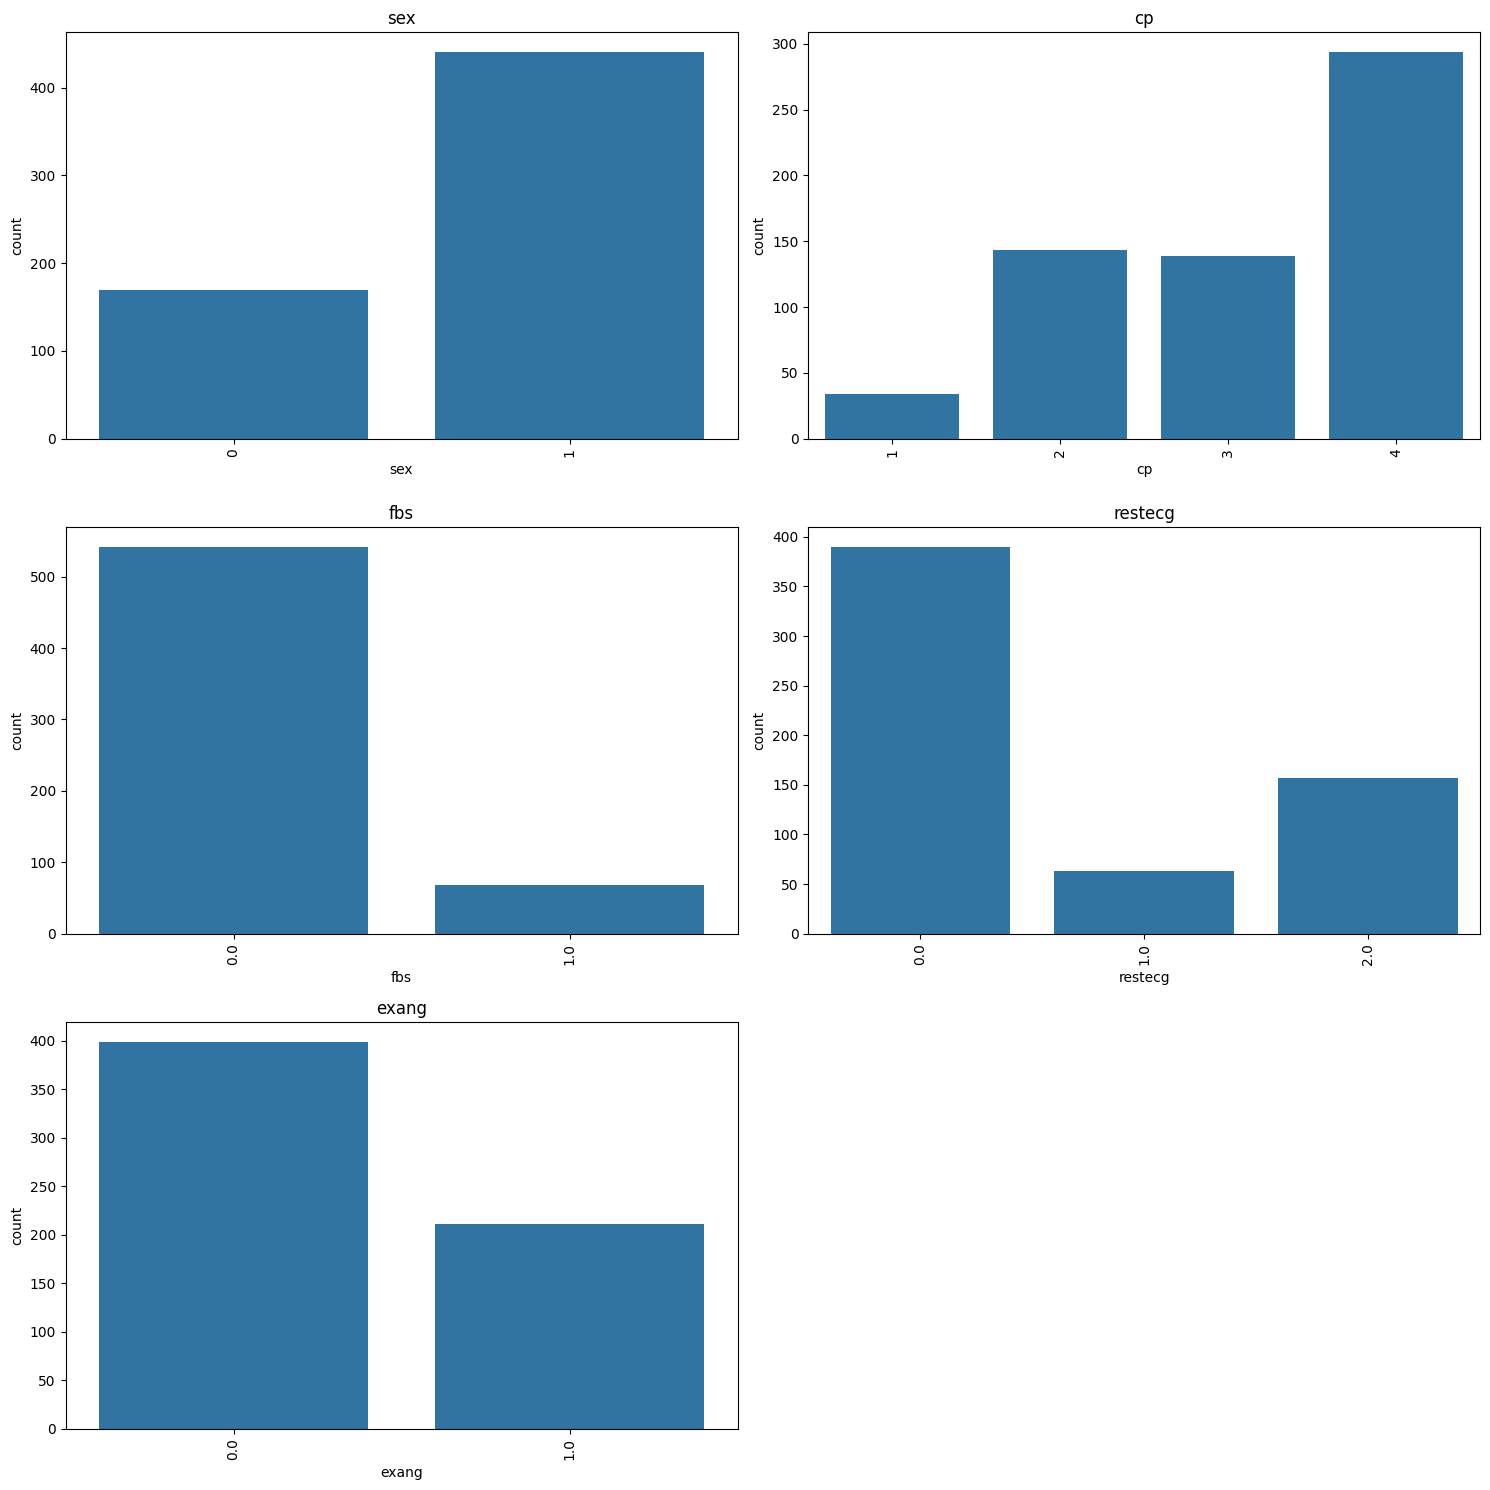

In [31]:
# Summary of group counts in all categorical columns
n = len(cat_col)
n_rows = math.ceil(n / 2) 

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 15), dpi=100)
fig.subplots_adjust(top=1.0, hspace=1.2)

for i in range(n):
    sns.countplot(x=cat_col[i], data=df, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(cat_col[i])
    axes[i//2, i%2].tick_params(axis="x", labelrotation=90)
    
# Remove the unused subplot if the total number of plots is odd
if len(cat_col) % 2:
    fig.delaxes(axes[i//2, 1])

plt.tight_layout()
plt.show()

### Univariate Analysis

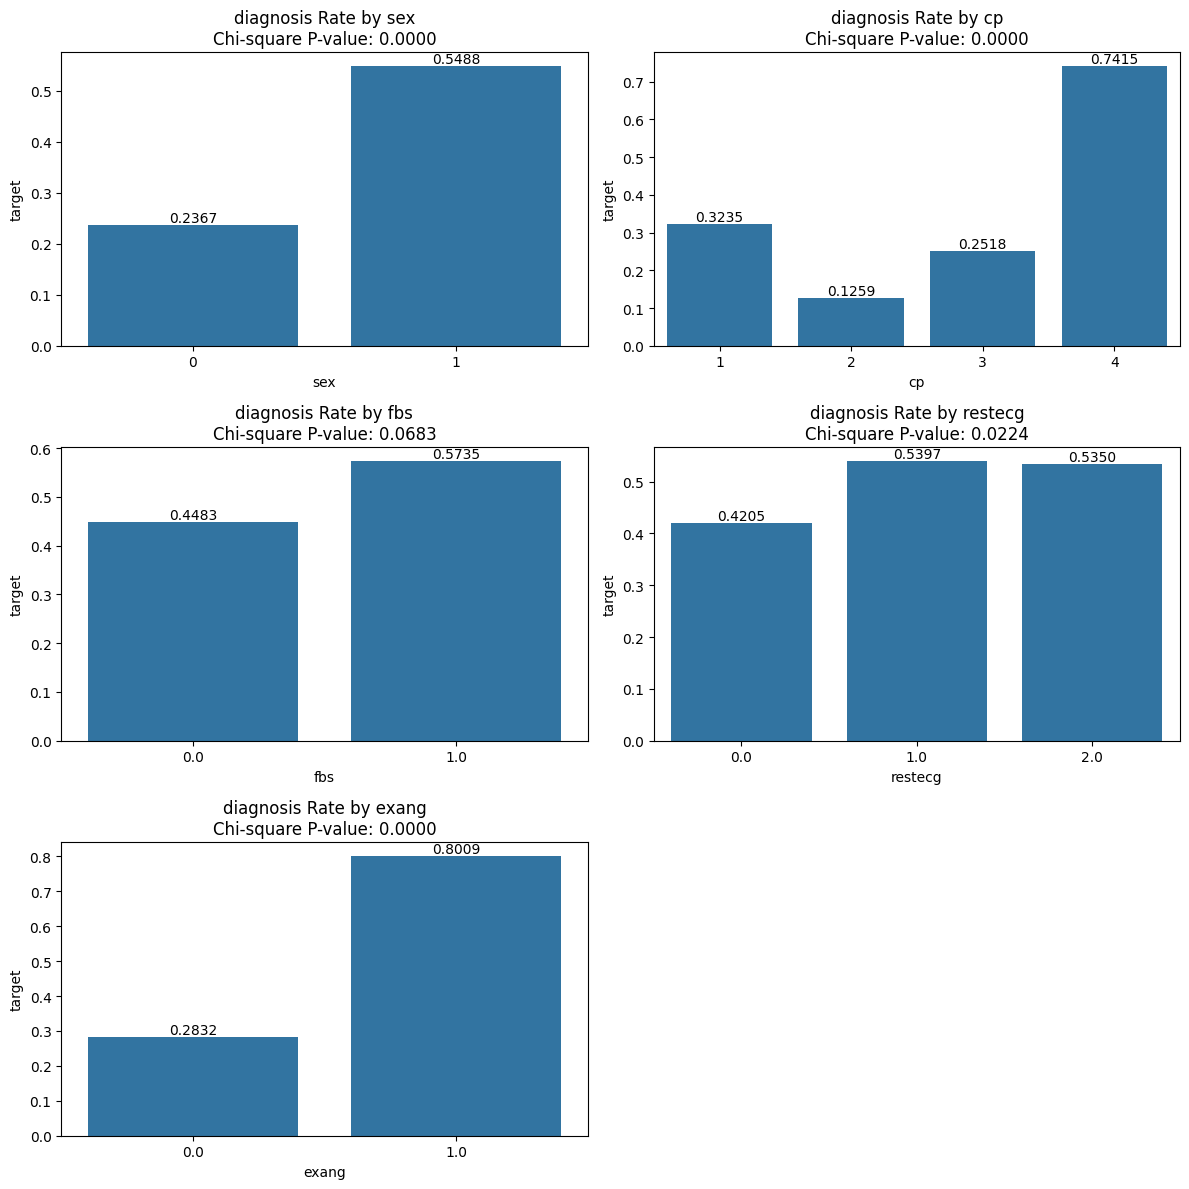

In [32]:
# Check the diagnosis rate for all categorical columns
fig, axes = plt.subplots(nrows=(len(cat_col)+1)//2, ncols=2, figsize=(12, 4*((len(cat_col)+1)//2)))

for i, col in enumerate(cat_col):
    ax = axes[i//2,i%2] # Determine the row and column number of the subplot

    # Calculate mean diagnosis rate for each category in the current column
    mean_rate = df.groupby(col)['target'].mean()
    mean_rate_df = mean_rate.reset_index()

    # Perform a chi-square test of independence
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[col], df['target']))

    # Create a bar plot for the churn rates
    sns.barplot(data=mean_rate_df, x=col, y='target', ax=ax)
    ax.set_title(f'diagnosis Rate by {col}\nChi-square P-value: {p:.4f}')  # display p-value in title
    ax.set_xlabel(col)
    ax.set_ylabel('target')

    # Add rate labels over the bars
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.4f}'.format(p.get_height()), ha='center', va='bottom')

# Remove the unused subplot if the total number of plots is odd
if len(cat_col) % 2:
    fig.delaxes(axes[i//2, 1])
    
plt.tight_layout()
plt.show()

### Multivariate Analysis

interval columns not set, guessing: ['sex', 'cp', 'fbs', 'restecg', 'exang']


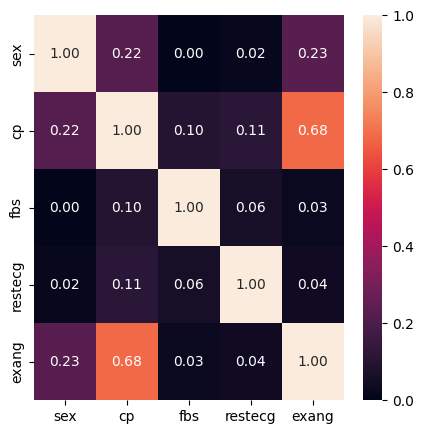

In [33]:
#  PhiK analysis of categorical columns

# Select only the categorical columns
df_categorical = df[cat_col]

# Calculate the phik correlation matrix for categorical columns
phik_overview = df_categorical.phik_matrix()

# Visualize the matrix
plt.figure(figsize=(5,5))
sns.heatmap(phik_overview, annot=True, fmt=".2f")
plt.show()


- 'exang' & 'cp' are highly correlated.

## Features - deeply explore 

### Features - exclude

### Features - numerical

#### Age

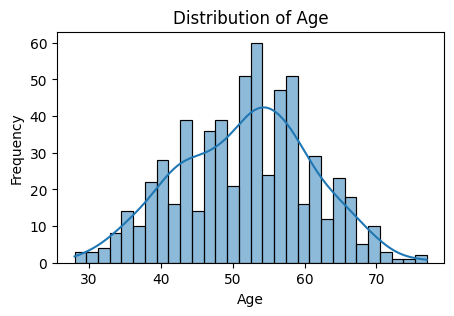

In [34]:
# Distribution of age
plt.figure(figsize=(5, 3))
sns.histplot(df['age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [35]:
# Check the skewness of age
df['age'].skew()

# If the skewness is less than -1 or greater than 1, the data are highly skewed. 
# If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed. 
# If the skewness is between -0.5 and 0.5, the data are approximately symmetric.

-0.08850193620076999

In [36]:
# Summary statistics
df['age'].describe()

count   610.00
mean     51.75
std       9.18
min      28.00
25%      45.00
50%      52.00
75%      58.00
max      77.00
Name: age, dtype: float64

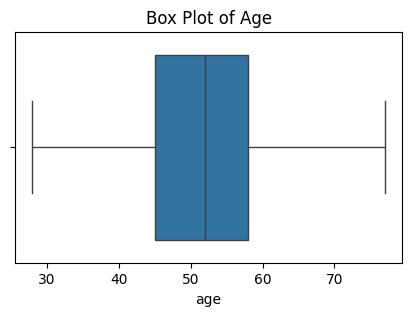

In [37]:
# Box plot to check for outliers
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['age'])
plt.title('Box Plot of Age')
plt.show()

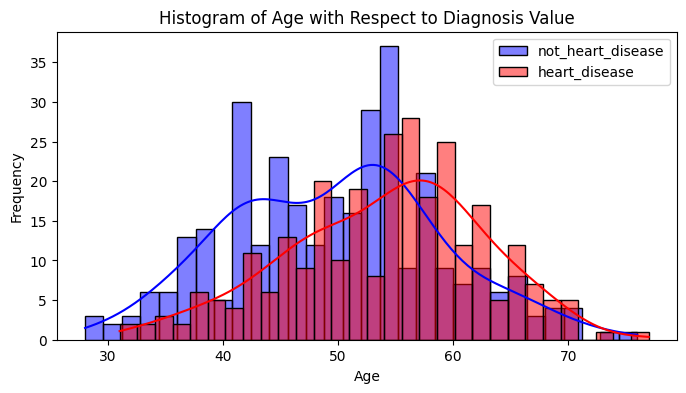

In [38]:
# Distribution of age with respect to Churn Value
plt.figure(figsize=(8, 4))
sns.histplot(data=df[df['target'] == 0], x='age', bins=30, kde=True, color='blue', label='not_heart_disease')
sns.histplot(data=df[df['target'] == 1], x='age', bins=30, kde=True, color='red', label='heart_disease')
plt.title('Histogram of Age with Respect to Diagnosis Value')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [39]:
# Summary statistics of age with respect to target
df.groupby('target')['age'].describe()

count  mean  std   min   25%   50%   75%   max
target                                                
0      328.00 49.72 9.24 28.00 42.75 50.50 55.25 76.00
1      282.00 54.12 8.54 31.00 48.00 55.00 60.00 77.00

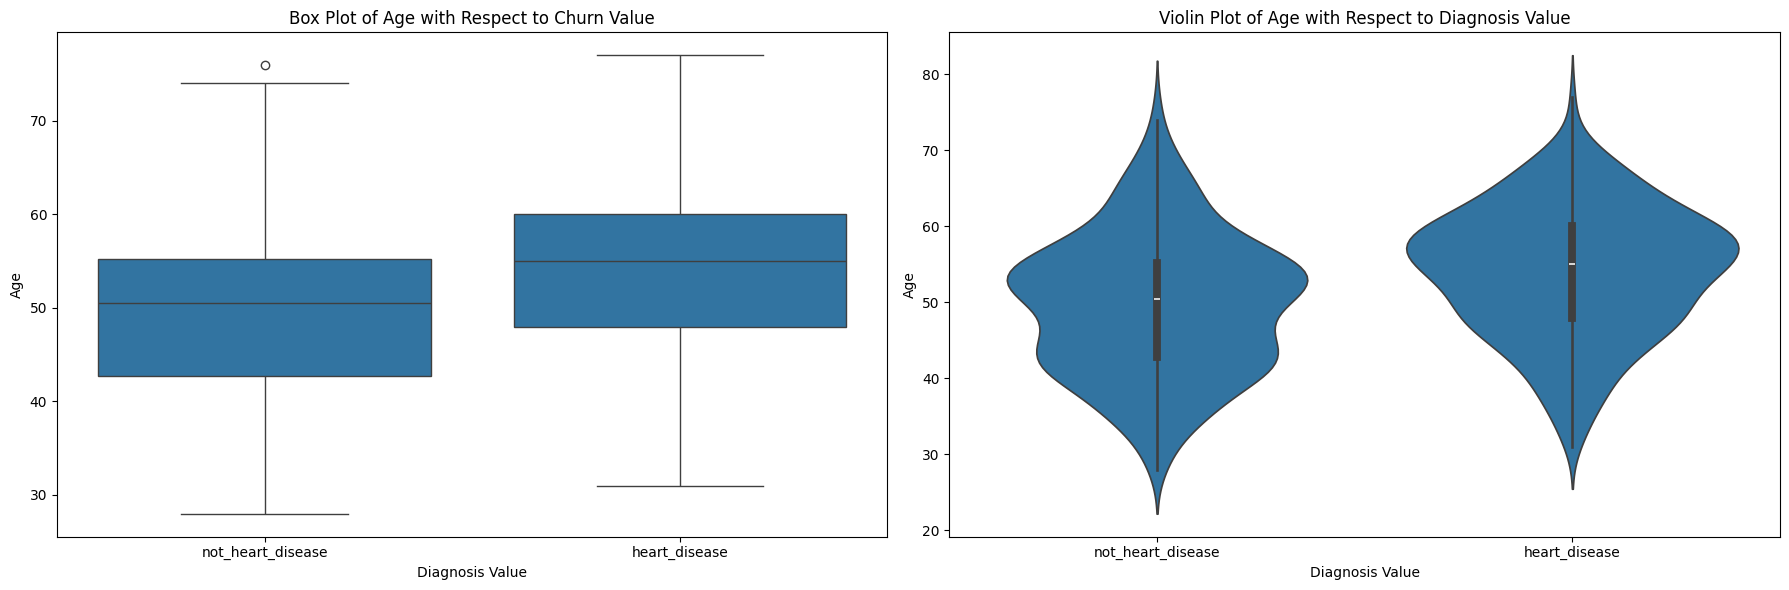

In [40]:
# Visualization by Box plot and Violin plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot of age with respect to Churn Value
sns.boxplot(ax=axes[0], x='target', y='age', data=df)
axes[0].set_title('Box Plot of Age with Respect to Churn Value')
axes[0].set_xlabel('Diagnosis Value')
axes[0].set_ylabel('Age')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['not_heart_disease', 'heart_disease'])

# Violin plot of age with respect to Churn Value
sns.violinplot(ax=axes[1], x='target', y='age', data=df)
axes[1].set_title('Violin Plot of Age with Respect to Diagnosis Value')
axes[1].set_xlabel('Diagnosis Value')
axes[1].set_ylabel('Age')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['not_heart_disease', 'heart_disease'])

plt.tight_layout()
plt.show()

In [41]:
# T test with target
t_stat, p_value = t_test(df, 'target', 'age')

print(f"T-statistic : {t_stat}")
print(f"P-value : {p_value}")

T-statistic : 6.07297242445036
P-value : 2.2131417698546506e-09


- The p-value is less than the significance level (0.05), we can reject the null hypothesis and conclude that the two groups have significantly different means (the 'age' for heart_disease and not_heart_disease).


#### trestbps: resting blood pressure 

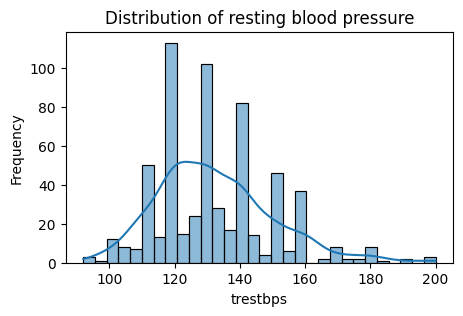

In [42]:
# Distribution of resting blood pressure
plt.figure(figsize=(5, 3))
sns.histplot(df['trestbps'], kde=True, bins=30)
plt.title('Distribution of resting blood pressure')
plt.xlabel('trestbps')
plt.ylabel('Frequency')
plt.show()

In [43]:
# Check the skewness of age
df['trestbps'].skew()

# If the skewness is less than -1 or greater than 1, the data are highly skewed. 
# If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed. 
# If the skewness is between -0.5 and 0.5, the data are approximately symmetric.

0.7562681644659539

In [44]:
# Summary statistics
df['trestbps'].describe()

count   610.00
mean    132.41
std      17.84
min      92.00
25%     120.00
50%     130.00
75%     140.00
max     200.00
Name: trestbps, dtype: float64

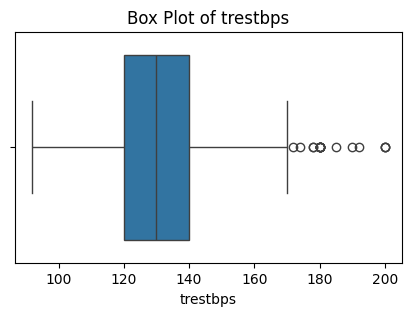

In [45]:
# Box plot to check for outliers
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['trestbps'])
plt.title('Box Plot of trestbps')
plt.show()

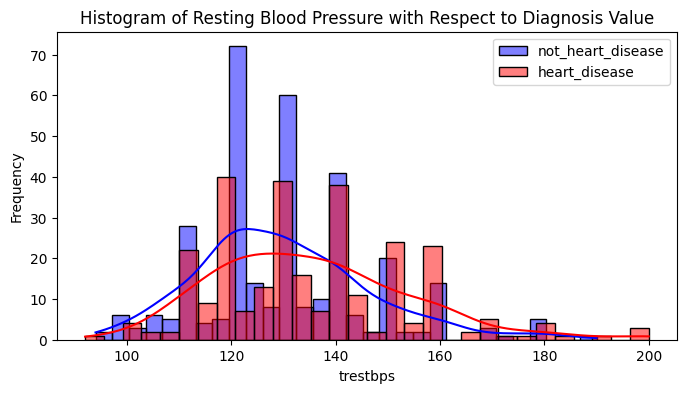

In [46]:
# Distribution of age with respect to Churn Value
plt.figure(figsize=(8, 4))
sns.histplot(data=df[df['target'] == 0], x='trestbps', bins=30, kde=True, color='blue', label='not_heart_disease')
sns.histplot(data=df[df['target'] == 1], x='trestbps', bins=30, kde=True, color='red', label='heart_disease')
plt.title('Histogram of Resting Blood Pressure with Respect to Diagnosis Value')
plt.xlabel('trestbps')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [47]:
# Summary statistics of age with respect to target
df.groupby('target')['trestbps'].describe()

count   mean   std   min    25%    50%    75%    max
target                                                      
0      328.00 129.90 16.44 94.00 120.00 130.00 140.00 190.00
1      282.00 135.34 18.96 92.00 120.00 132.00 145.75 200.00

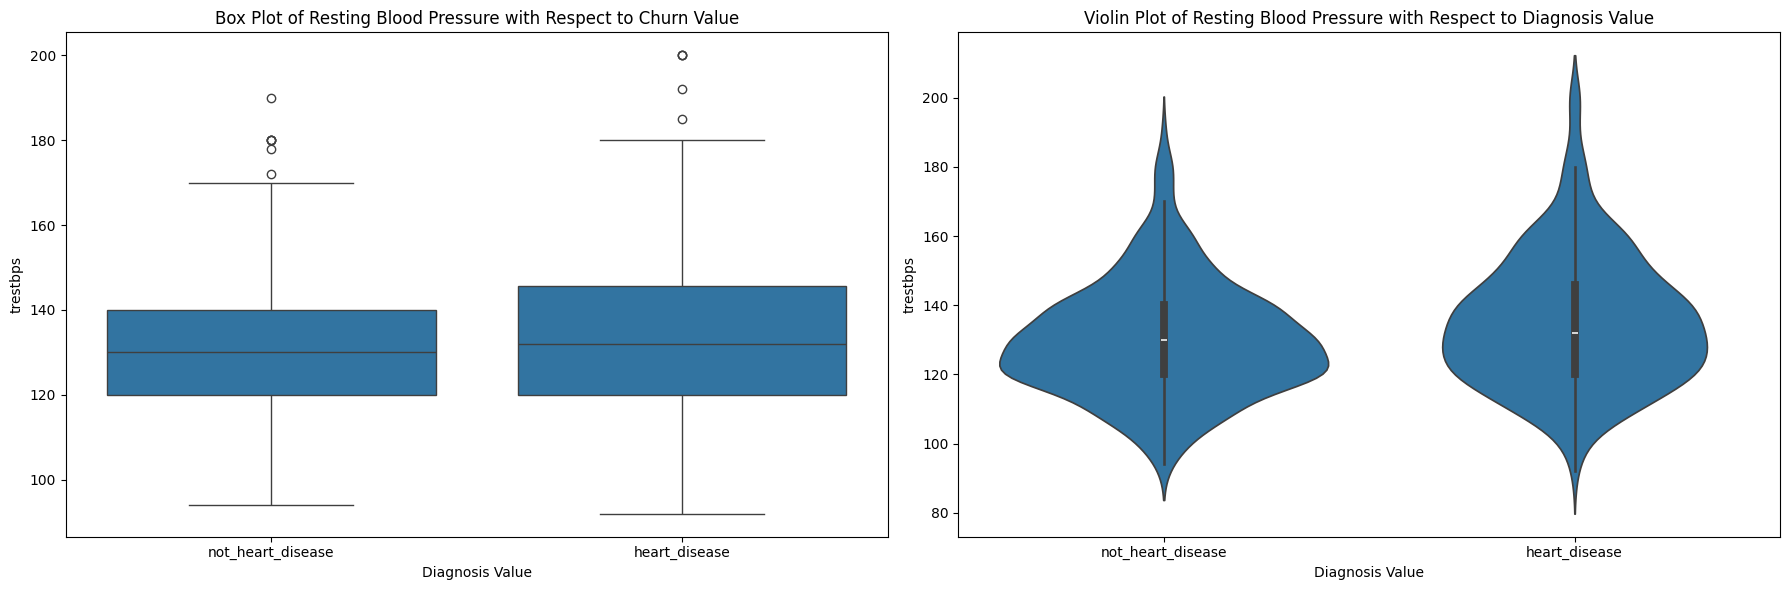

In [48]:
# Visualization by Box plot and Violin plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot of Resting Blood Pressure with Respect to Diagnosis Value
sns.boxplot(ax=axes[0], x='target', y='trestbps', data=df)
axes[0].set_title('Box Plot of Resting Blood Pressure with Respect to Churn Value')
axes[0].set_xlabel('Diagnosis Value')
axes[0].set_ylabel('trestbps')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['not_heart_disease', 'heart_disease'])

# Violin plot of Resting Blood Pressure with Respect to Diagnosis Value
sns.violinplot(ax=axes[1], x='target', y='trestbps', data=df)
axes[1].set_title('Violin Plot of Resting Blood Pressure with Respect to Diagnosis Value')
axes[1].set_xlabel('Diagnosis Value')
axes[1].set_ylabel('trestbps')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['not_heart_disease', 'heart_disease'])

plt.tight_layout()
plt.show()

In [49]:
# T test with target
t_stat, p_value = t_test(df, 'target', 'trestbps')

print(f"T-statistic : {t_stat}")
print(f"P-value : {p_value}")

T-statistic : 3.795878273562532
P-value : 0.0001618631598425485


- The p-value is less than the significance level (0.05), we can reject the null hypothesis and conclude that the two groups have significantly different means (the 'trestbps'(Resting Blood Pressure) for heart_disease and not_heart_disease).


#### chol: serum cholestoral in mg/dl

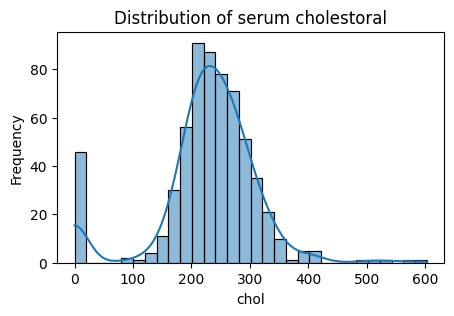

In [50]:
# Distribution of serum cholestoral
plt.figure(figsize=(5, 3))
sns.histplot(df['chol'], kde=True, bins=30)
plt.title('Distribution of serum cholestoral')
plt.xlabel('chol')
plt.ylabel('Frequency')
plt.show()

In [51]:
# Check the skewness of chol
df['chol'].skew()

# If the skewness is less than -1 or greater than 1, the data are highly skewed. 
# If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed. 
# If the skewness is between -0.5 and 0.5, the data are approximately symmetric.

-0.7320494771503451

In [52]:
# Summary statistics
df['chol'].describe()

count   610.00
mean    229.00
std      86.35
min       0.00
25%     201.00
50%     235.00
75%     274.00
max     603.00
Name: chol, dtype: float64

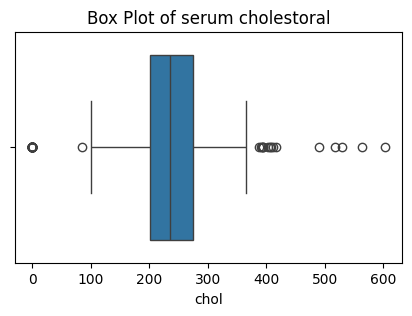

In [53]:
# Box plot to check for outliers
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['chol'])
plt.title('Box Plot of serum cholestoral')
plt.show()

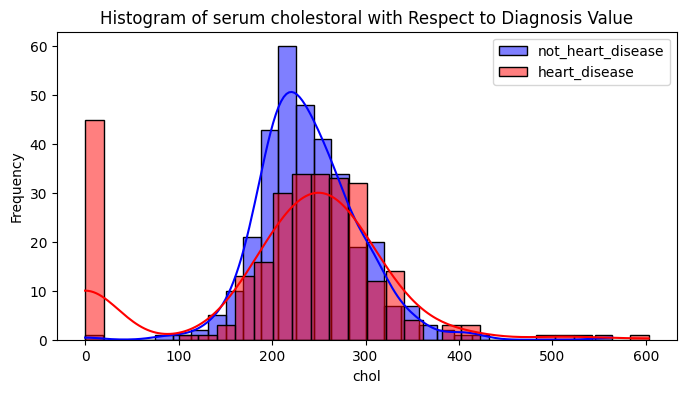

In [54]:
# Distribution of serum cholestoral with respect to Churn Value
plt.figure(figsize=(8, 4))
sns.histplot(data=df[df['target'] == 0], x='chol', bins=30, kde=True, color='blue', label='not_heart_disease')
sns.histplot(data=df[df['target'] == 1], x='chol', bins=30, kde=True, color='red', label='heart_disease')
plt.title('Histogram of serum cholestoral with Respect to Diagnosis Value')
plt.xlabel('chol')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [55]:
# Summary statistics of age with respect to target
df.groupby('target')['chol'].describe()

count   mean    std  min    25%    50%    75%    max
target                                                      
0      328.00 239.47  55.17 0.00 204.00 234.00 269.25 564.00
1      282.00 216.83 111.08 0.00 193.00 239.00 282.00 603.00

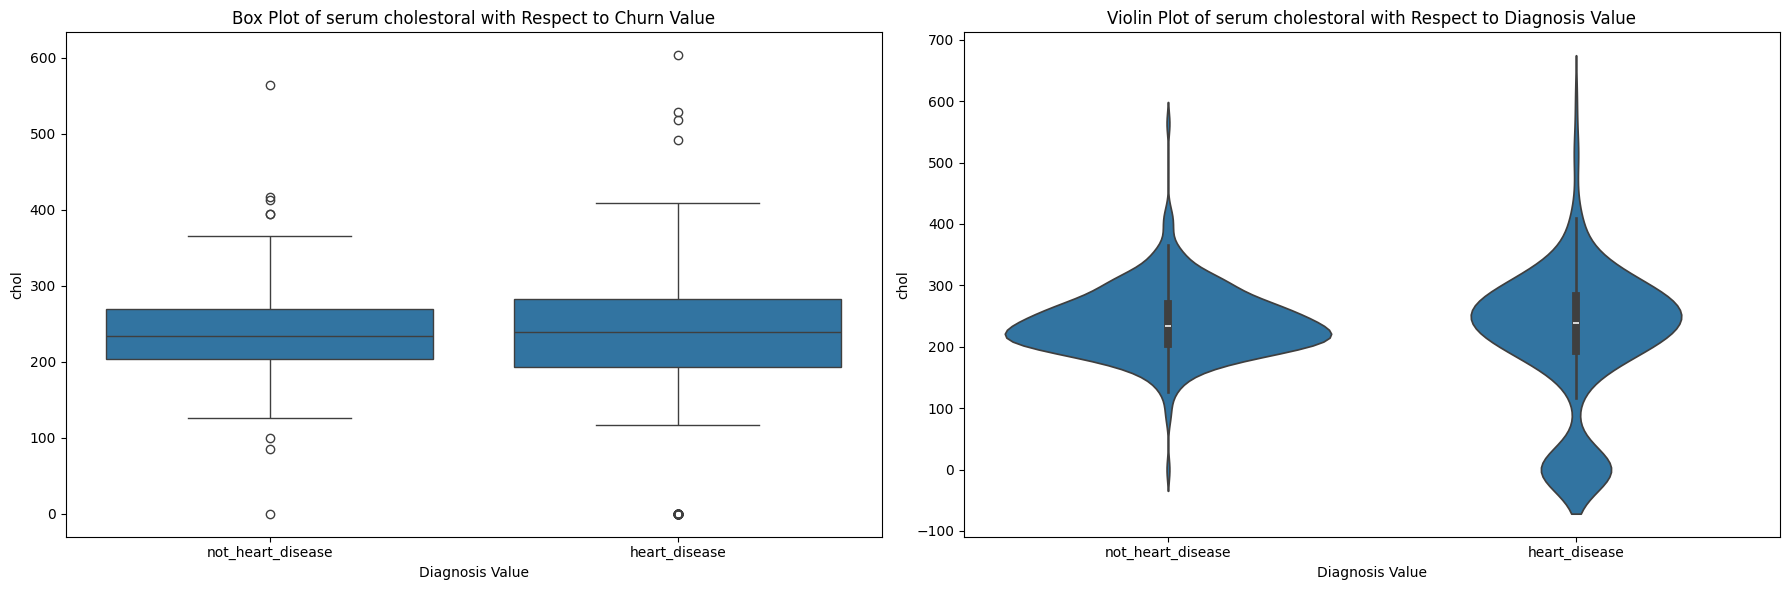

In [56]:
# Visualization by Box plot and Violin plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot of Resting Blood Pressure with Respect to Diagnosis Value
sns.boxplot(ax=axes[0], x='target', y='chol', data=df)
axes[0].set_title('Box Plot of serum cholestoral with Respect to Churn Value')
axes[0].set_xlabel('Diagnosis Value')
axes[0].set_ylabel('chol')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['not_heart_disease', 'heart_disease'])

# Violin plot of Resting Blood Pressure with Respect to Diagnosis Value
sns.violinplot(ax=axes[1], x='target', y='chol', data=df)
axes[1].set_title('Violin Plot of serum cholestoral with Respect to Diagnosis Value')
axes[1].set_xlabel('Diagnosis Value')
axes[1].set_ylabel('chol')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['not_heart_disease', 'heart_disease'])

plt.tight_layout()
plt.show()

In [57]:
# T test with target
t_stat, p_value = t_test(df, 'target', 'chol')

print(f"T-statistic : {t_stat}")
print(f"P-value : {p_value}")

T-statistic : -3.254506588173268
P-value : 0.0011989299118344836


- The p-value is less than the significance level (0.05), we can reject the null hypothesis and conclude that the two groups have significantly different means (the 'chol'(serum cholestoral) for heart_disease and not_heart_disease).


#### thalach: maximum heart rate achieved

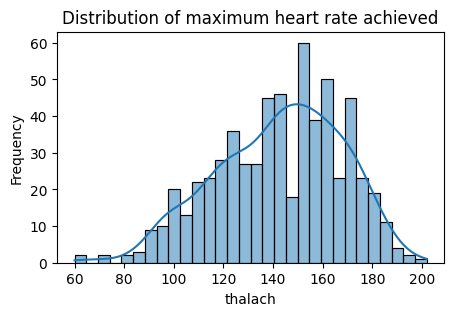

In [58]:
# Distribution of maximum heart rate achieved
plt.figure(figsize=(5, 3))
sns.histplot(df['thalach'], kde=True, bins=30)
plt.title('Distribution of maximum heart rate achieved')
plt.xlabel('thalach')
plt.ylabel('Frequency')
plt.show()

In [59]:
# Check the skewness of chol
df['thalach'].skew()

# If the skewness is less than -1 or greater than 1, the data are highly skewed. 
# If the skewness is between -1 and -0.5 or between 0.5 and 1, the data are moderately skewed. 
# If the skewness is between -0.5 and 0.5, the data are approximately symmetric.

-0.3716690270460204

In [60]:
# Summary statistics
df['thalach'].describe()

count   610.00
mean    142.45
std      25.20
min      60.00
25%     125.00
50%     145.00
75%     161.00
max     202.00
Name: thalach, dtype: float64

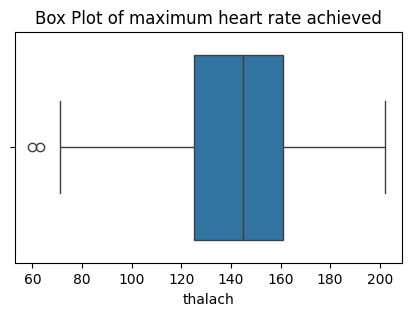

In [61]:
# Box plot to check for outliers
plt.figure(figsize=(5, 3))
sns.boxplot(x=df['thalach'])
plt.title('Box Plot of maximum heart rate achieved')
plt.show()

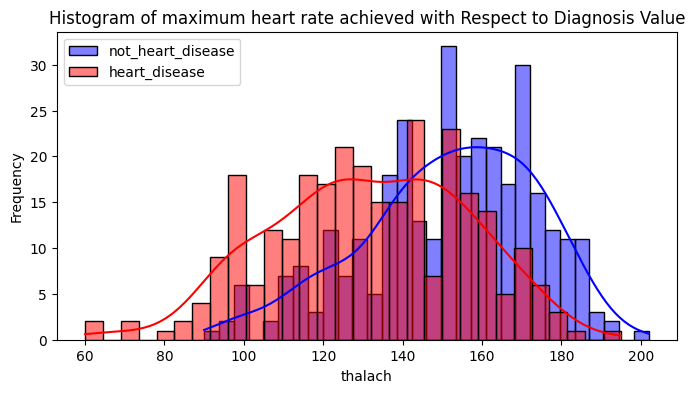

In [62]:
# Distribution of serum cholestoral with respect to Diagnosis Value
plt.figure(figsize=(8, 4))
sns.histplot(data=df[df['target'] == 0], x='thalach', bins=30, kde=True, color='blue', label='not_heart_disease')
sns.histplot(data=df[df['target'] == 1], x='thalach', bins=30, kde=True, color='red', label='heart_disease')
plt.title('Histogram of maximum heart rate achieved with Respect to Diagnosis Value')
plt.xlabel('thalach')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [63]:
# Summary statistics of age with respect to target
df.groupby('target')['thalach'].describe()

count   mean   std   min    25%    50%    75%    max
target                                                      
0      328.00 151.83 21.74 90.00 138.75 154.00 169.25 202.00
1      282.00 131.55 24.59 60.00 115.00 131.00 150.00 195.00

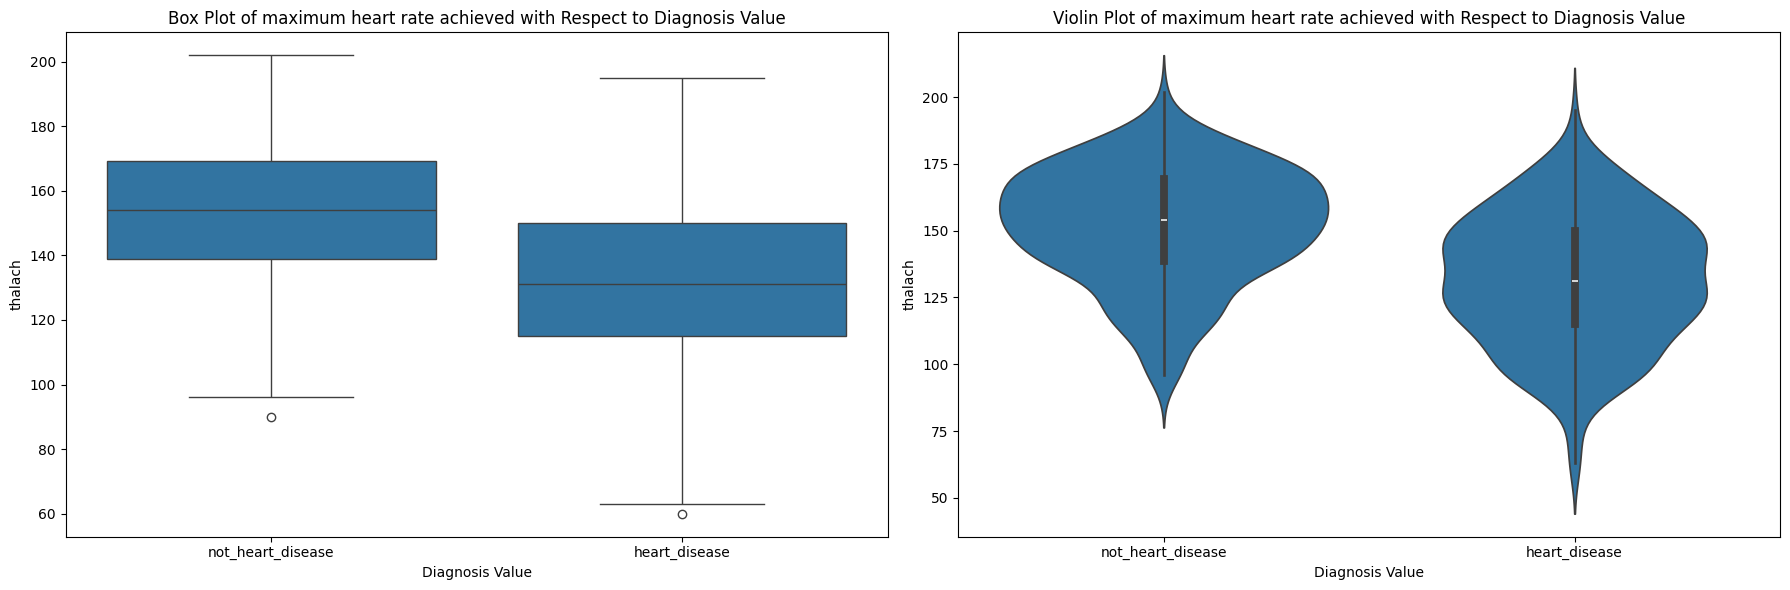

In [64]:
# Visualization by Box plot and Violin plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Box plot of Resting Blood Pressure with Respect to Diagnosis Value
sns.boxplot(ax=axes[0], x='target', y='thalach', data=df)
axes[0].set_title('Box Plot of maximum heart rate achieved with Respect to Diagnosis Value')
axes[0].set_xlabel('Diagnosis Value')
axes[0].set_ylabel('thalach')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['not_heart_disease', 'heart_disease'])

# Violin plot of Resting Blood Pressure with Respect to Diagnosis Value
sns.violinplot(ax=axes[1], x='target', y='thalach', data=df)
axes[1].set_title('Violin Plot of maximum heart rate achieved with Respect to Diagnosis Value')
axes[1].set_xlabel('Diagnosis Value')
axes[1].set_ylabel('thalach')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['not_heart_disease', 'heart_disease'])

plt.tight_layout()
plt.show()

In [65]:
# T test with target
t_stat, p_value = t_test(df, 'target', 'thalach')

print(f"T-statistic : {t_stat}")
print(f"P-value : {p_value}")

T-statistic : -10.809364212691788
P-value : 4.9561823266942725e-25


- The p-value is less than the significance level (0.05), we can reject the null hypothesis and conclude that the two groups have significantly different means (the 'chol'(serum cholestoral) for heart_disease and not_heart_disease).


### Features - categorical

#### Sex

In [66]:
# Count of each Under 30 class
df['sex'].value_counts()

sex
1    441
0    169
Name: count, dtype: int64

In [67]:
# Percentage of each sex
df['sex'].value_counts(normalize=True) * 100

sex
1   72.30
0   27.70
Name: proportion, dtype: float64

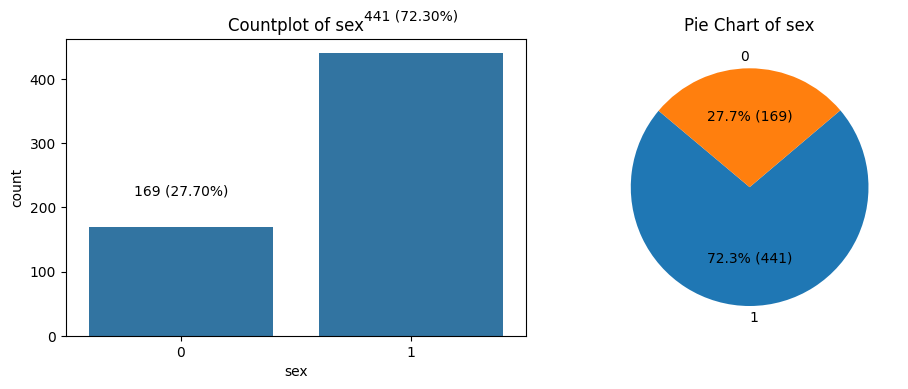

In [68]:
# Visualization
counts = df['sex'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Create countplot
sns.countplot(x='sex', data=df, ax=axs[0])
axs[0].set_title('Countplot of sex')
# Add counts and proportions on top of each bar
total = len(df)
for i in range(counts.shape[0]):
    count = counts[i]
    proportion = 100 * count / total
    axs[0].text(i, count+50, f'{count} ({proportion:.2f}%)', ha='center')

# Create pie chart
axs[1].pie(counts, labels=counts.index, autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*counts.sum()), startangle=140)
axs[1].set_title('Pie Chart of sex')

plt.tight_layout()
plt.show()

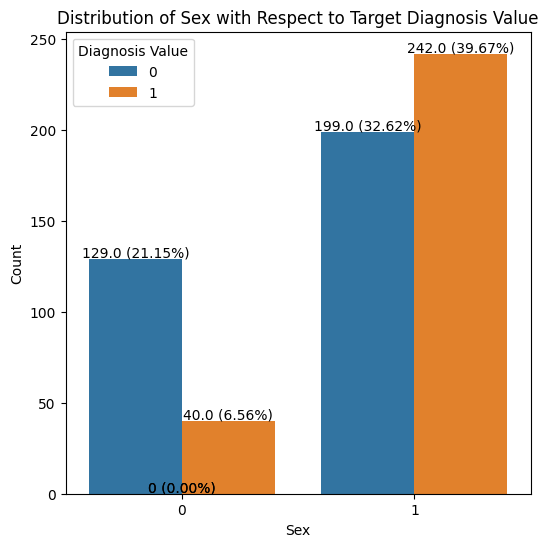

In [69]:
# Visualization with respect to target
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=df, x='sex', hue='target')
plt.title('Distribution of Sex with Respect to Target Diagnosis Value')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Diagnosis Value')

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 1, f'{p.get_height()} ({percentage})', ha='center')
    
plt.show()

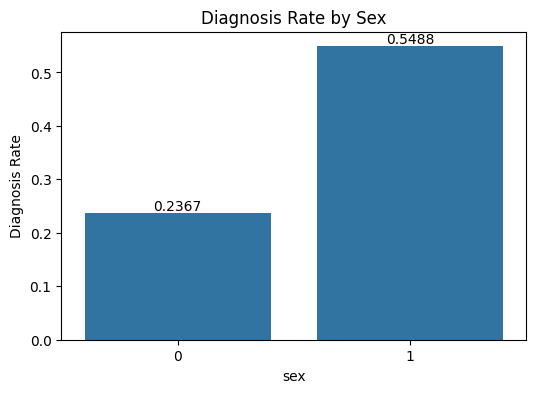

In [70]:
# Check the diagnosis rate for each sex
diagnosis_rate = df.groupby('sex')['target'].mean()
diagnosis_rate_df = diagnosis_rate.reset_index()

# Create a bar plot for the churn rates
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=diagnosis_rate_df, x='sex', y='target')
plt.title('Diagnosis Rate by Sex')
plt.xlabel('sex')
plt.ylabel('Diagnosis Rate')

# Add rate labels over the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.4f}'.format(p.get_height()), ha = 'center', va = 'bottom')

plt.show()

In [71]:
# Statistical Test: perform a chi-square test of independence to check if 'Under 30' is independent of 'Churn Value'.
chi2, p = chi_square_test(df, 'sex', 'target')

print(f"Chi-square Statistic : {chi2}")
print(f"P-value : {p}")

Chi-square Statistic : 46.61873687933027
P-value : 8.623178238764412e-12


The p-value is less than the significance level (0.05), we can reject the null hypothesis and conclude that the two groups have significantly different means (the 'sex' for heart_disease and not_heart_disease).

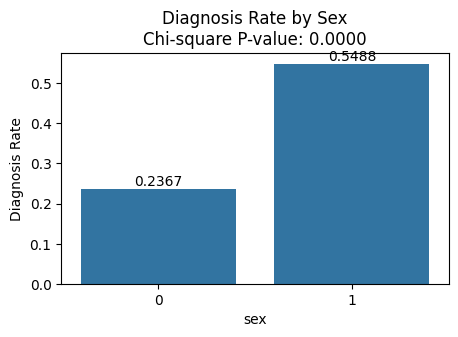

In [72]:
from scipy.stats import chi2_contingency

# Calculate diagnosis rate for each Under 30 category
diagnosis_rate = df.groupby('sex')['target'].mean()
diagnosis_rate_df = diagnosis_rate.reset_index()

# Perform a chi-square test of independence
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['sex'], df['target']))

# Create a bar plot for the churn rates
plt.figure(figsize=(5, 3))
ax = sns.barplot(data=diagnosis_rate_df, x='sex', y='target')
plt.title('Diagnosis Rate by Sex\nChi-square P-value: {:.4f}'.format(p))  # display p-value in title
plt.xlabel('sex')
plt.ylabel('Diagnosis Rate')

# Add rate labels over the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.4f}'.format(p.get_height()), ha='center', va='bottom')

plt.show()


#### cp: chest pain type

In [73]:
# Count of each cp class
df['cp'].value_counts()

cp
4    294
2    143
3    139
1     34
Name: count, dtype: int64

In [74]:
# Percentage of each cp class
df['cp'].value_counts(normalize=True) * 100

cp
4   48.20
2   23.44
3   22.79
1    5.57
Name: proportion, dtype: float64

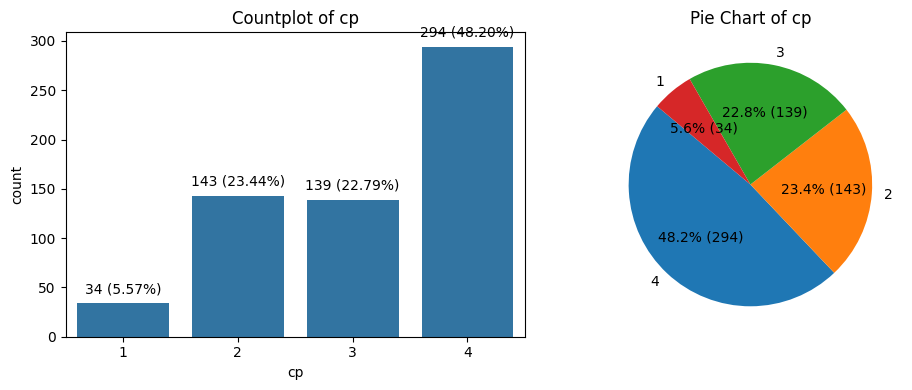

In [75]:
# Visualization
counts = df['cp'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Create countplot
sns.countplot(x='cp', data=df, ax=axs[0])
axs[0].set_title('Countplot of cp')
# Add counts and proportions on top of each bar
total = len(df)
for i in range(counts.shape[0]):
    count = counts[i+1]
    proportion = 100 * count / total
    axs[0].text(i, count+10, f'{count} ({proportion:.2f}%)', ha='center')

# Create pie chart
axs[1].pie(counts, labels=counts.index, autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*counts.sum()), startangle=140)
axs[1].set_title('Pie Chart of cp')

plt.tight_layout()
plt.show()

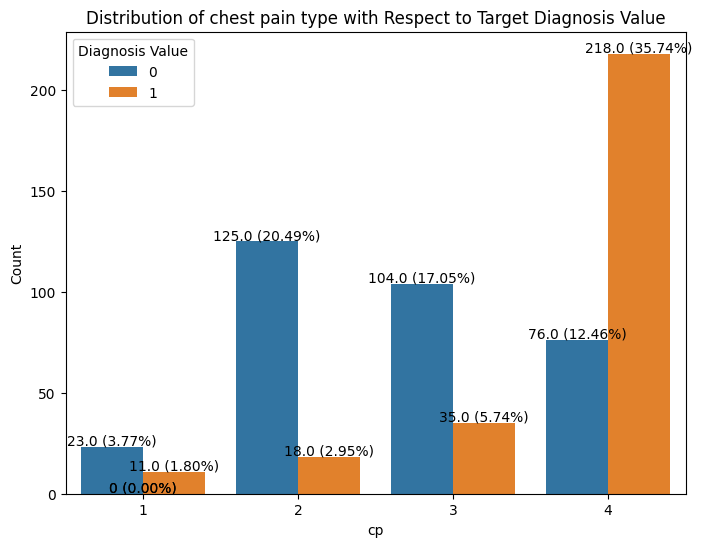

In [76]:
# Visualization with respect to target
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='cp', hue='target')
plt.title('Distribution of chest pain type with Respect to Target Diagnosis Value')
plt.xlabel('cp')
plt.ylabel('Count')
plt.legend(title='Diagnosis Value')

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 1, f'{p.get_height()} ({percentage})', ha='center')
    
plt.show()

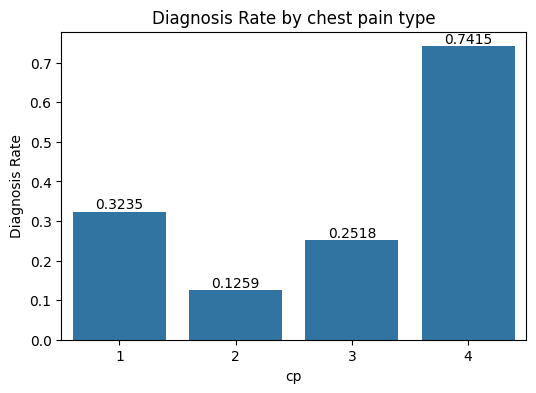

In [77]:
# Check the churn rate for each Gender
churn_rate = df.groupby('cp')['target'].mean()
churn_rate_df = churn_rate.reset_index()

# Create a bar plot for the churn rates
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=churn_rate_df, x='cp', y='target')
plt.title('Diagnosis Rate by chest pain type')
plt.xlabel('cp')
plt.ylabel('Diagnosis Rate')

# Add rate labels over the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.4f}'.format(p.get_height()), ha = 'center', va = 'bottom')

plt.show()

In [78]:
# Statistical Test: perform a chi-square test of independence to check if 'chest pain type' is independent of 'diagnosis Value'.
chi2, p = chi_square_test(df, 'cp', 'target')

print(f"Chi-square Statistic : {chi2}")
print(f"P-value : {p}")

Chi-square Statistic : 184.7166288903365
P-value : 8.449267795550947e-40


- The p-value is less than the significance level (0.05), we can reject the null hypothesis of independence and conclude that 'cp' and 'diagnosis Value' are associated.


#### fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

In [79]:
# Count of each fasting blood sugar class
df['fbs'].value_counts()

fbs
0.00    542
1.00     68
Name: count, dtype: int64

In [80]:
# Percentage of each fbs class
df['fbs'].value_counts(normalize=True) * 100

fbs
0.00   88.85
1.00   11.15
Name: proportion, dtype: float64

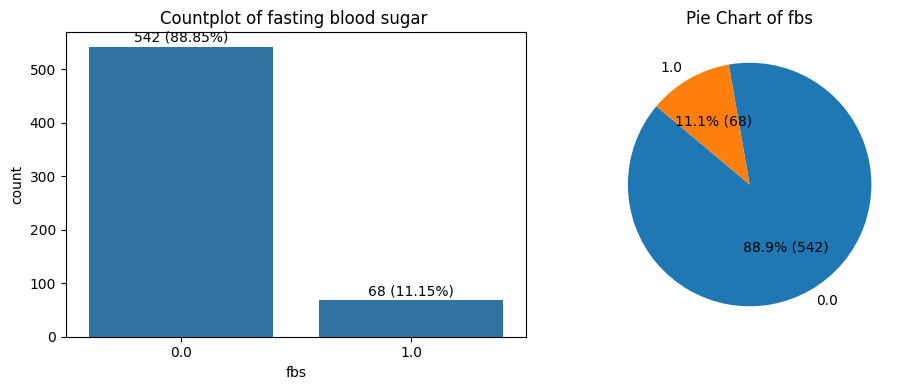

In [81]:
# Visualization
counts = df['fbs'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Create countplot
sns.countplot(x='fbs', data=df, ax=axs[0])
axs[0].set_title('Countplot of fasting blood sugar ')
# Add counts and proportions on top of each bar
total = len(df)
for i in range(counts.shape[0]):
    count = counts[i]
    proportion = 100 * count / total
    axs[0].text(i, count+10, f'{count} ({proportion:.2f}%)', ha='center')

# Create pie chart
axs[1].pie(counts, labels=counts.index, autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*counts.sum()), startangle=140)
axs[1].set_title('Pie Chart of fbs')

plt.tight_layout()
plt.show()

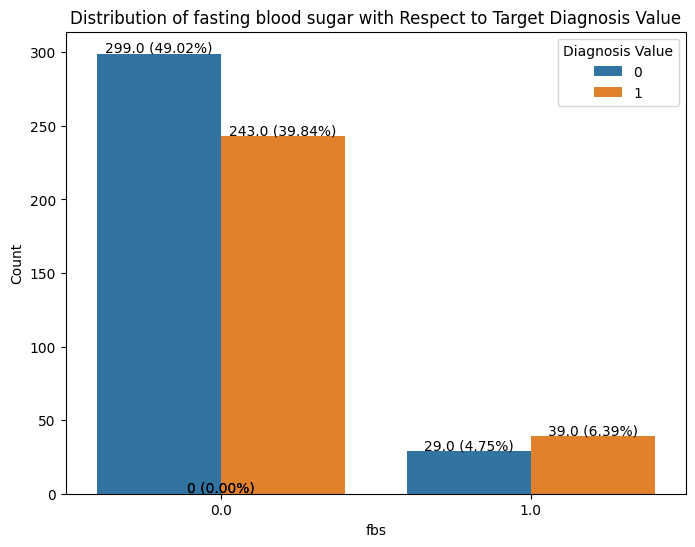

In [82]:
# Visualization with respect to target
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='fbs', hue='target')
plt.title('Distribution of fasting blood sugar with Respect to Target Diagnosis Value')
plt.xlabel('fbs')
plt.ylabel('Count')
plt.legend(title='Diagnosis Value')

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 1, f'{p.get_height()} ({percentage})', ha='center')
    
plt.show()

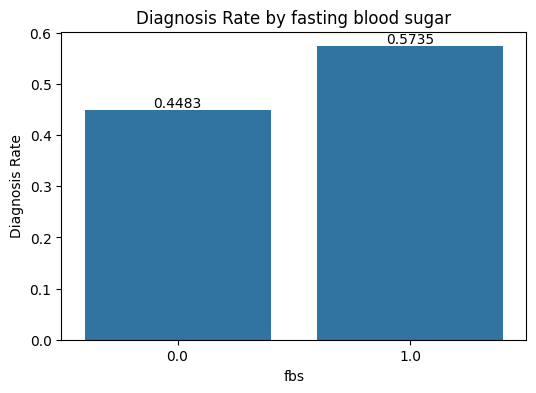

In [83]:
# Check the churn rate for each Gender
churn_rate = df.groupby('fbs')['target'].mean()
churn_rate_df = churn_rate.reset_index()

# Create a bar plot for the diagnosis rates
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=churn_rate_df, x='fbs', y='target')
plt.title('Diagnosis Rate by fasting blood sugar')
plt.xlabel('fbs')
plt.ylabel('Diagnosis Rate')

# Add rate labels over the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.4f}'.format(p.get_height()), ha = 'center', va = 'bottom')

plt.show()

In [84]:
# Statistical Test: perform a chi-square test of independence to check if 'fbs' is independent of 'diagnosis Value'.
chi2, p = chi_square_test(df, 'fbs', 'target')

print(f"Chi-square Statistic : {chi2}")
print(f"P-value : {p}")

Chi-square Statistic : 3.3223981166204015
P-value : 0.06834207195868934


#### restecg: resting electrocardiographic results

In [85]:
# Count of each resting electrocardiographic results class
df['restecg'].value_counts()

restecg
0.00    390
2.00    157
1.00     63
Name: count, dtype: int64

In [86]:
# Percentage of each resting electrocardiographic results class
df['restecg'].value_counts(normalize=True) * 100

restecg
0.00   63.93
2.00   25.74
1.00   10.33
Name: proportion, dtype: float64

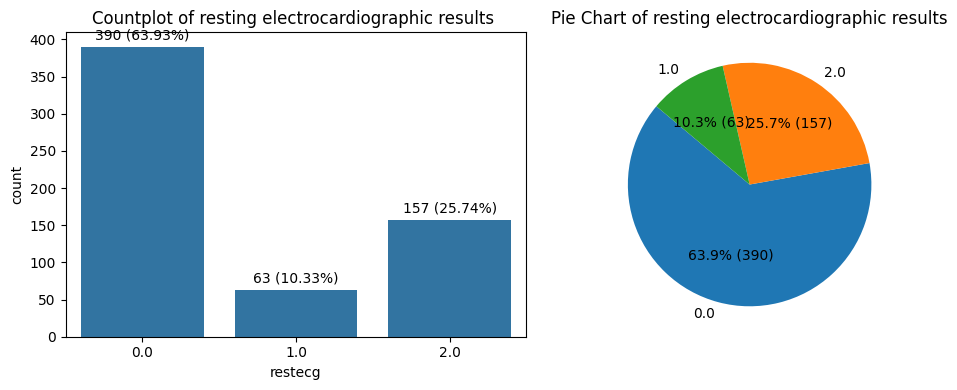

In [87]:
# Visualization
counts = df['restecg'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Create countplot
sns.countplot(x='restecg', data=df, ax=axs[0])
axs[0].set_title('Countplot of resting electrocardiographic results ')
# Add counts and proportions on top of each bar
total = len(df)
for i in range(counts.shape[0]):
    count = counts[i]
    proportion = 100 * count / total
    axs[0].text(i, count+10, f'{count} ({proportion:.2f}%)', ha='center')

# Create pie chart
axs[1].pie(counts, labels=counts.index, autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*counts.sum()), startangle=140)
axs[1].set_title('Pie Chart of resting electrocardiographic results')

plt.tight_layout()
plt.show()

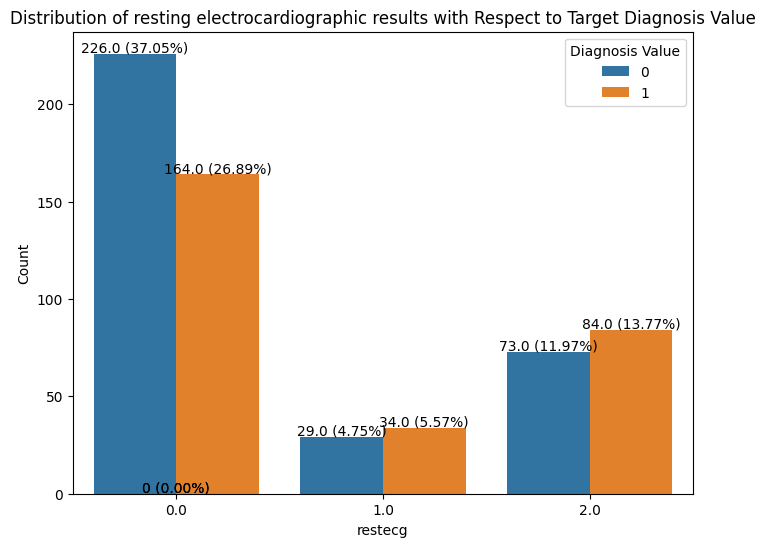

In [88]:
# Visualization with respect to target
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='restecg', hue='target')
plt.title('Distribution of resting electrocardiographic results with Respect to Target Diagnosis Value')
plt.xlabel('restecg')
plt.ylabel('Count')
plt.legend(title='Diagnosis Value')

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + 1, f'{p.get_height()} ({percentage})', ha='center')
    
plt.show()

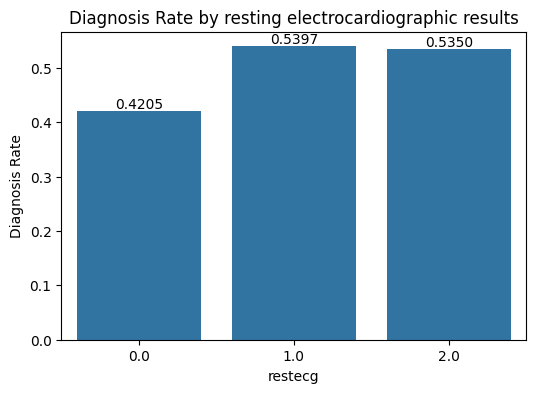

In [89]:
# Check the churn rate for each Gender
churn_rate = df.groupby('restecg')['target'].mean()
churn_rate_df = churn_rate.reset_index()

# Create a bar plot for the diagnosis rates
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=churn_rate_df, x='restecg', y='target')
plt.title('Diagnosis Rate by resting electrocardiographic results')
plt.xlabel('restecg')
plt.ylabel('Diagnosis Rate')

# Add rate labels over the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.4f}'.format(p.get_height()), ha = 'center', va = 'bottom')

plt.show()

In [90]:
# Statistical Test: perform a chi-square test of independence to check if 'fbs' is independent of 'diagnosis Value'.
chi2, p = chi_square_test(df, 'restecg', 'target')

print(f"Chi-square Statistic : {chi2}")
print(f"P-value : {p}")

Chi-square Statistic : 7.598292611505784
P-value : 0.02238987780956347


## Summary of EDA 

**Target**:

- 58 - num: diagnosis of heart disease (angiographic disease status): binary


**Features**:

- age: age in years

 
- sex: sex (1 = male; 0 = female)


- cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic



- trestbps: resting blood pressure (in mm Hg on admission to the hospital)


- chol: serum cholestoral in mg/dl


- fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)


- restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria



- thalach: maximum heart rate achieved



- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing

 

**Useless columns (9)**: drop
- slope: the slope of the peak exercise ST segment 
- ca: number of major vessels (0-3) colored by flourosopy
- thal:A blood disorder called thalassemia.
- Percentage of missing is high for slope, ca, thal:28.65%, 57.30%, 44.37%. These 3 columns could not be aquired during the transport of ambulence service, which are not useful for the prediction.


# Feature Engineering

In [8]:
df = pd.read_excel('combined_data.xlsx')

### Duplicates

In [9]:
# Check number of duplicates in dataframe
df.duplicated().sum()

1

In [10]:
df = df.drop_duplicates()

## Drop useless columns

In [11]:
# Remove 9 useless columns
df_clean = df.drop(columns=['slope','ca','thal'])
df_clean

age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1    145.00 233.00 1.00     2.00   150.00   0.00     2.30   
1     67    1   4    160.00 286.00 0.00     2.00   108.00   1.00     1.50   
2     67    1   4    120.00 229.00 0.00     2.00   129.00   1.00     2.60   
3     37    1   3    130.00 250.00 0.00     0.00   187.00   0.00     3.50   
4     41    0   2    130.00 204.00 0.00     2.00   172.00   0.00     1.40   
..   ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
715   70    1   4    115.00   0.00 0.00     1.00    92.00   1.00     0.00   
716   70    1   4    140.00   0.00 1.00     0.00   157.00   1.00     2.00   
717   72    1   3    160.00   0.00  NaN     2.00   114.00   0.00     1.60   
718   73    0   3    160.00   0.00 0.00     1.00   121.00   0.00     0.00   
719   74    1   2    145.00   0.00  NaN     1.00   123.00   0.00     1.30   

     target  
0         0  
1         2  
2         1  
3         0  
4         0  
..      ...  
715       1  
716       3  
717       0  
718       1  
719       1  

[719 rows x 11 columns]

## Drop NaN

In [12]:
df_clean = df_clean.dropna().reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       610 non-null    int64  
 1   sex       610 non-null    int64  
 2   cp        610 non-null    int64  
 3   trestbps  610 non-null    float64
 4   chol      610 non-null    float64
 5   fbs       610 non-null    float64
 6   restecg   610 non-null    float64
 7   thalach   610 non-null    float64
 8   exang     610 non-null    float64
 9   oldpeak   610 non-null    float64
 10  target    610 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 52.5 KB


## Drop Outliers

## Target & Features

- We have 1 columns referring whether people are diagnosed to have heart disease, called 'num'.

In [13]:
df_clean['target'].value_counts()

target
0    328
1    165
3     51
2     50
4     16
Name: count, dtype: int64

Target Value: A binary outcome indicating if diagnosis of heart disease.
- 1: have heart disease
- 0: not have heart disease

In [14]:
# Define a mapping dictionary
mapping = {0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
# Apply the mapping to the 'target' column
df_clean['target'] = df_clean['target'].map(mapping)
df_clean

age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1    145.00 233.00 1.00     2.00   150.00   0.00     2.30   
1     67    1   4    160.00 286.00 0.00     2.00   108.00   1.00     1.50   
2     67    1   4    120.00 229.00 0.00     2.00   129.00   1.00     2.60   
3     37    1   3    130.00 250.00 0.00     0.00   187.00   0.00     3.50   
4     41    0   2    130.00 204.00 0.00     2.00   172.00   0.00     1.40   
..   ...  ...  ..       ...    ...  ...      ...      ...    ...      ...   
605   68    1   4    135.00   0.00 0.00     1.00   120.00   1.00     0.00   
606   69    1   4    135.00   0.00 0.00     0.00   130.00   0.00     0.00   
607   70    1   4    115.00   0.00 0.00     1.00    92.00   1.00     0.00   
608   70    1   4    140.00   0.00 1.00     0.00   157.00   1.00     2.00   
609   73    0   3    160.00   0.00 0.00     1.00   121.00   0.00     0.00   

     target  
0         0  
1         1  
2         1  
3         0  
4         0  
..      ...  
605       1  
606       1  
607       1  
608       1  
609       1  

[610 rows x 11 columns]

In [15]:
cat_col = ['sex','cp','fbs','restecg','exang','target']
num_col = ['age','trestbps','chol','thalach','oldpeak']
# Convert the float column to a categorical column

df_clean[cat_col] = df_clean[cat_col].astype(int)
df_clean[cat_col] = df_clean[cat_col].astype('category')
df_clean[cat_col]

sex cp fbs restecg exang target
0     1  1   1       2     0      0
1     1  4   0       2     1      1
2     1  4   0       2     1      1
3     1  3   0       0     0      0
4     0  2   0       2     0      0
..   .. ..  ..     ...   ...    ...
605   1  4   0       1     1      1
606   1  4   0       0     0      1
607   1  4   0       1     1      1
608   1  4   1       0     1      1
609   0  3   0       1     0      1

[610 rows x 6 columns]

## Drop non-selected features

In [16]:
# Remove zero non-selected features: not associated with target, highly correlated and delivering similar information
#df_train = df_clean.drop(columns=['Gender','Zip Code','Phone Service','Avg Monthly Long Distance Charges', 'Total Extra Data Charges', 'Under 30', 'Senior Citizen', 'Number of Dependents','Latitude','Longitude','Referred a Friend','Streaming Movies','Streaming Music','Unlimited Data','Total Charges','Total Long Distance Charges','Total Revenue'])
df_train = df_clean
df_train

age sex cp  trestbps   chol fbs restecg  thalach exang  oldpeak target
0     63   1  1    145.00 233.00   1       2   150.00     0     2.30      0
1     67   1  4    160.00 286.00   0       2   108.00     1     1.50      1
2     67   1  4    120.00 229.00   0       2   129.00     1     2.60      1
3     37   1  3    130.00 250.00   0       0   187.00     0     3.50      0
4     41   0  2    130.00 204.00   0       2   172.00     0     1.40      0
..   ...  .. ..       ...    ...  ..     ...      ...   ...      ...    ...
605   68   1  4    135.00   0.00   0       1   120.00     1     0.00      1
606   69   1  4    135.00   0.00   0       0   130.00     0     0.00      1
607   70   1  4    115.00   0.00   0       1    92.00     1     0.00      1
608   70   1  4    140.00   0.00   1       0   157.00     1     2.00      1
609   73   0  3    160.00   0.00   0       1   121.00     0     0.00      1

[610 rows x 11 columns]

## Double check selected features for modelling

In [17]:
# Count nemerical and categorical columns in df_train
cat_col_train = [x for x in df_train.columns if df_train[x].dtype == 'category']
num_col_train = [x for x in df_train.columns if x not in cat_col_train]

# Print number of categorical and numerical columns in df_train
print('Number of categorical columns in df_train: {}'.format(len(cat_col_train)))
print('Number of numerical columns in df_train: {}'.format(len(num_col_train)))

# Print the names of the categorical columns in df_train
print('Categorical columns in df_train:')
for col in cat_col_train:
    print(col)

# Print the names of the numerical columns in df_train
print('Numerical columns in df_train:')
for col in num_col_train:
    print(col)

Number of categorical columns in df_train: 6
Number of numerical columns in df_train: 5
Categorical columns in df_train:
sex
cp
fbs
restecg
exang
target
Numerical columns in df_train:
age
trestbps
chol
thalach
oldpeak


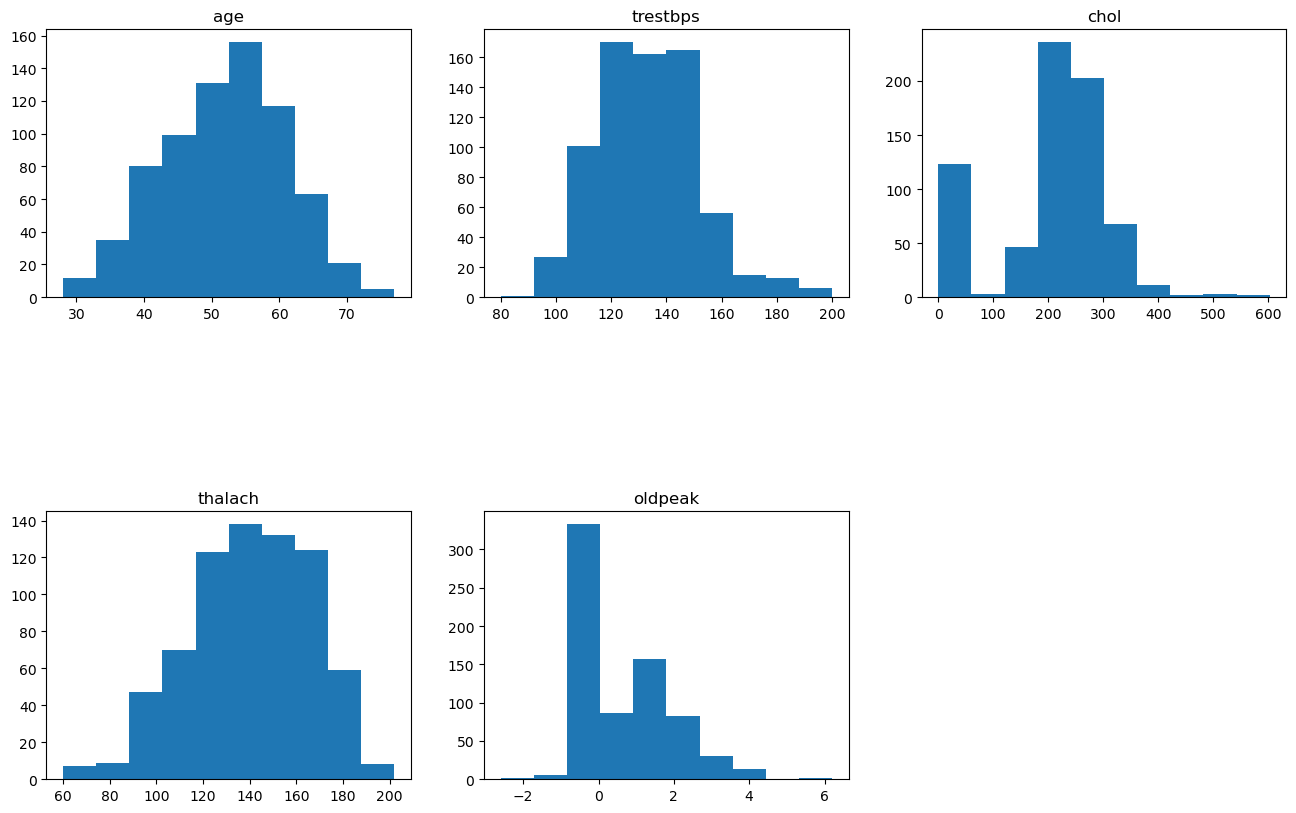

In [18]:
# Check the distribution of numerical columns
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.8)
for i,var in enumerate(num_col_train):
    ax = fig.add_subplot(3, 3, i+1)
    ax.hist(df[var])
    ax.set_title(var)

age        -0.12
trestbps    0.66
chol       -0.63
thalach    -0.33
oldpeak     1.23
dtype: float64


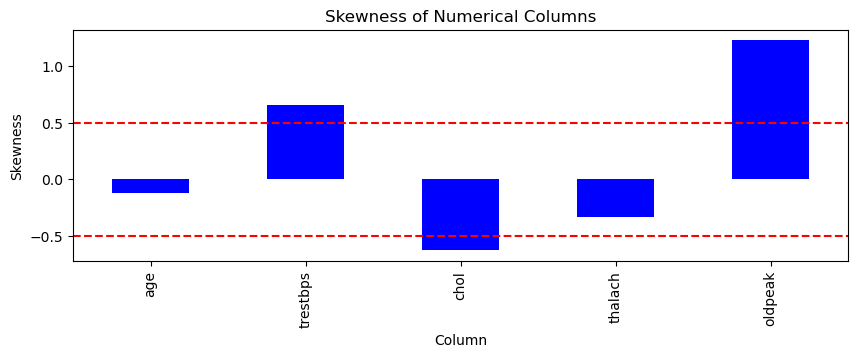

In [19]:
# Check and plot skewness of numrical columns
skewness = df[num_col_train].skew()
print(skewness)
plt.figure(figsize=(10,3))
ax = skewness.plot(kind='bar', color='blue')

# add dashed lines at the threshold values (0.5 and -0.5) for moderate skewness
ax.axhline(y=0.5, color='red', linestyle='--')
ax.axhline(y=-0.5, color='red', linestyle='--')

# add labels and title to the plot
ax.set_xlabel('Column')
ax.set_ylabel('Skewness')
ax.set_title('Skewness of Numerical Columns')
plt.show()

- oldpeak, chol and trestbps are higly skewed, let's deep explore them.

<Axes: >

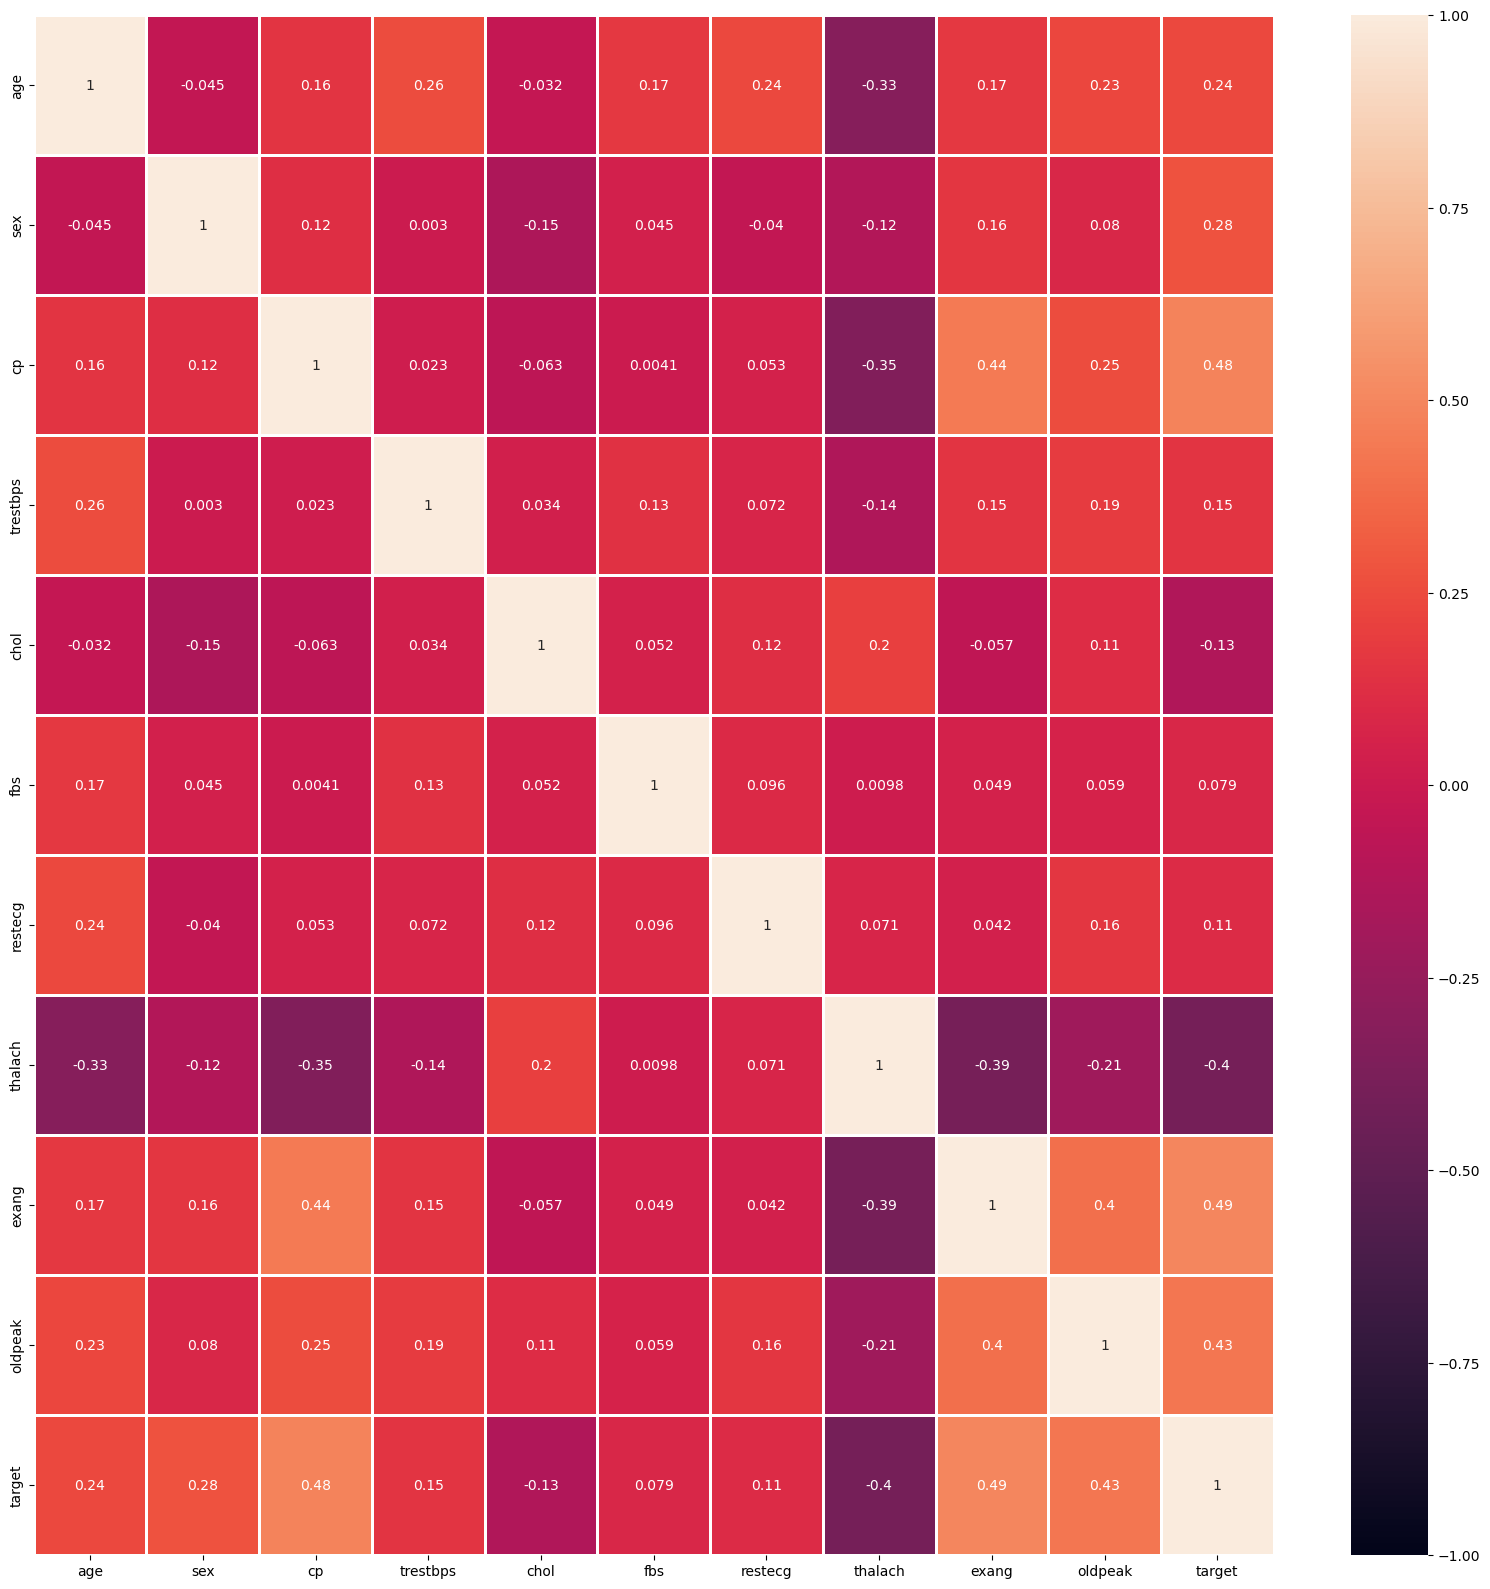

In [20]:
# Correlation analysis for numerical columns in df_train
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_train.corr(method='pearson'), vmin=-1, vmax=1, lw=2, annot=True) 

- Not obvious higly correlated numerical features.

In [21]:
# Check Variance Inflation Factor (VIF) score
df_num = df_train[num_col_train]

# Calculate VIF for each numerical column
vif = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]
vif_df = pd.DataFrame({'Features': df_num.columns, 'VIF': vif})

vif_df

Features   VIF
0       age 28.88
1  trestbps 42.44
2      chol  8.58
3   thalach 22.76
4   oldpeak  1.78

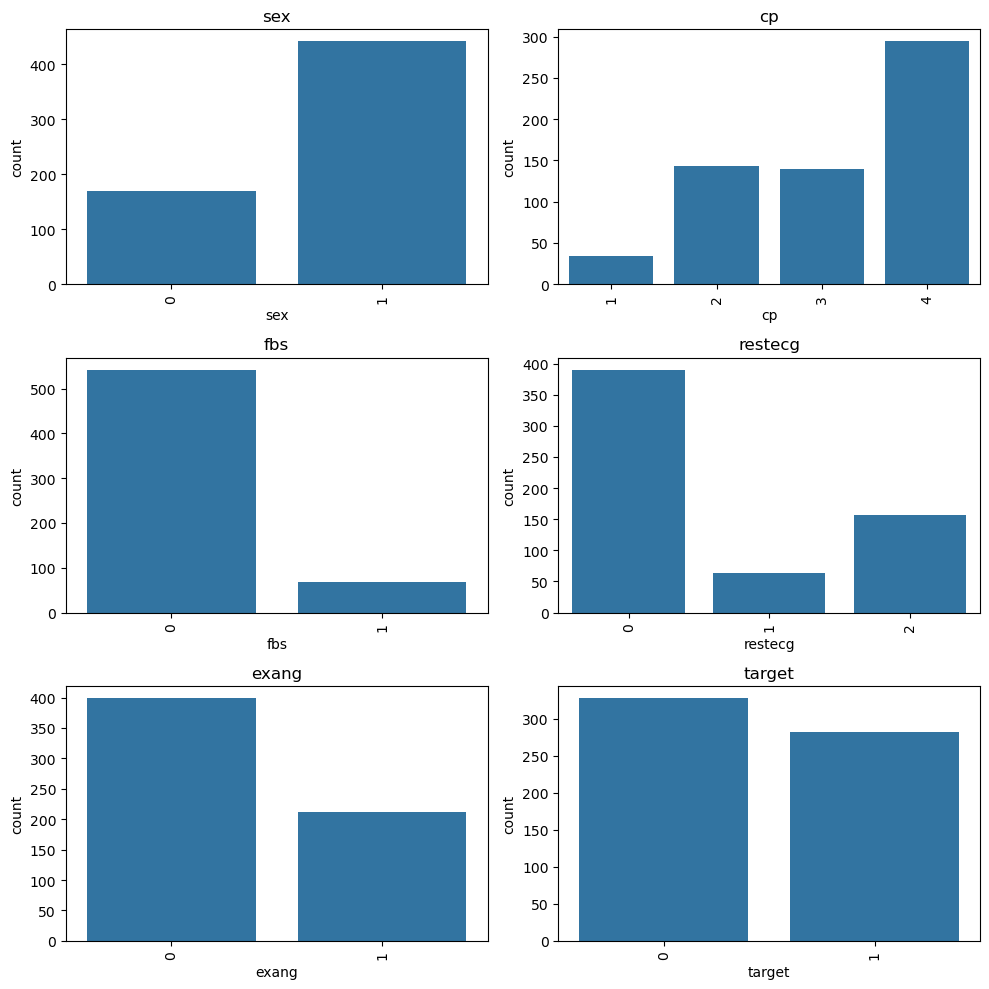

In [22]:
# Check the distribution of categorical columns
n = len(cat_col_train)
n_rows = math.ceil(n / 2) 

fig, axes = plt.subplots(n_rows, 2, figsize=(10, 10), dpi=100)
fig.subplots_adjust(top=1.0, hspace=1.2)

for i in range(n):
    sns.countplot(x=cat_col_train[i], data=df_train, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(cat_col_train[i])
    axes[i//2, i%2].tick_params(axis="x", labelrotation=90)

plt.tight_layout()
plt.show()

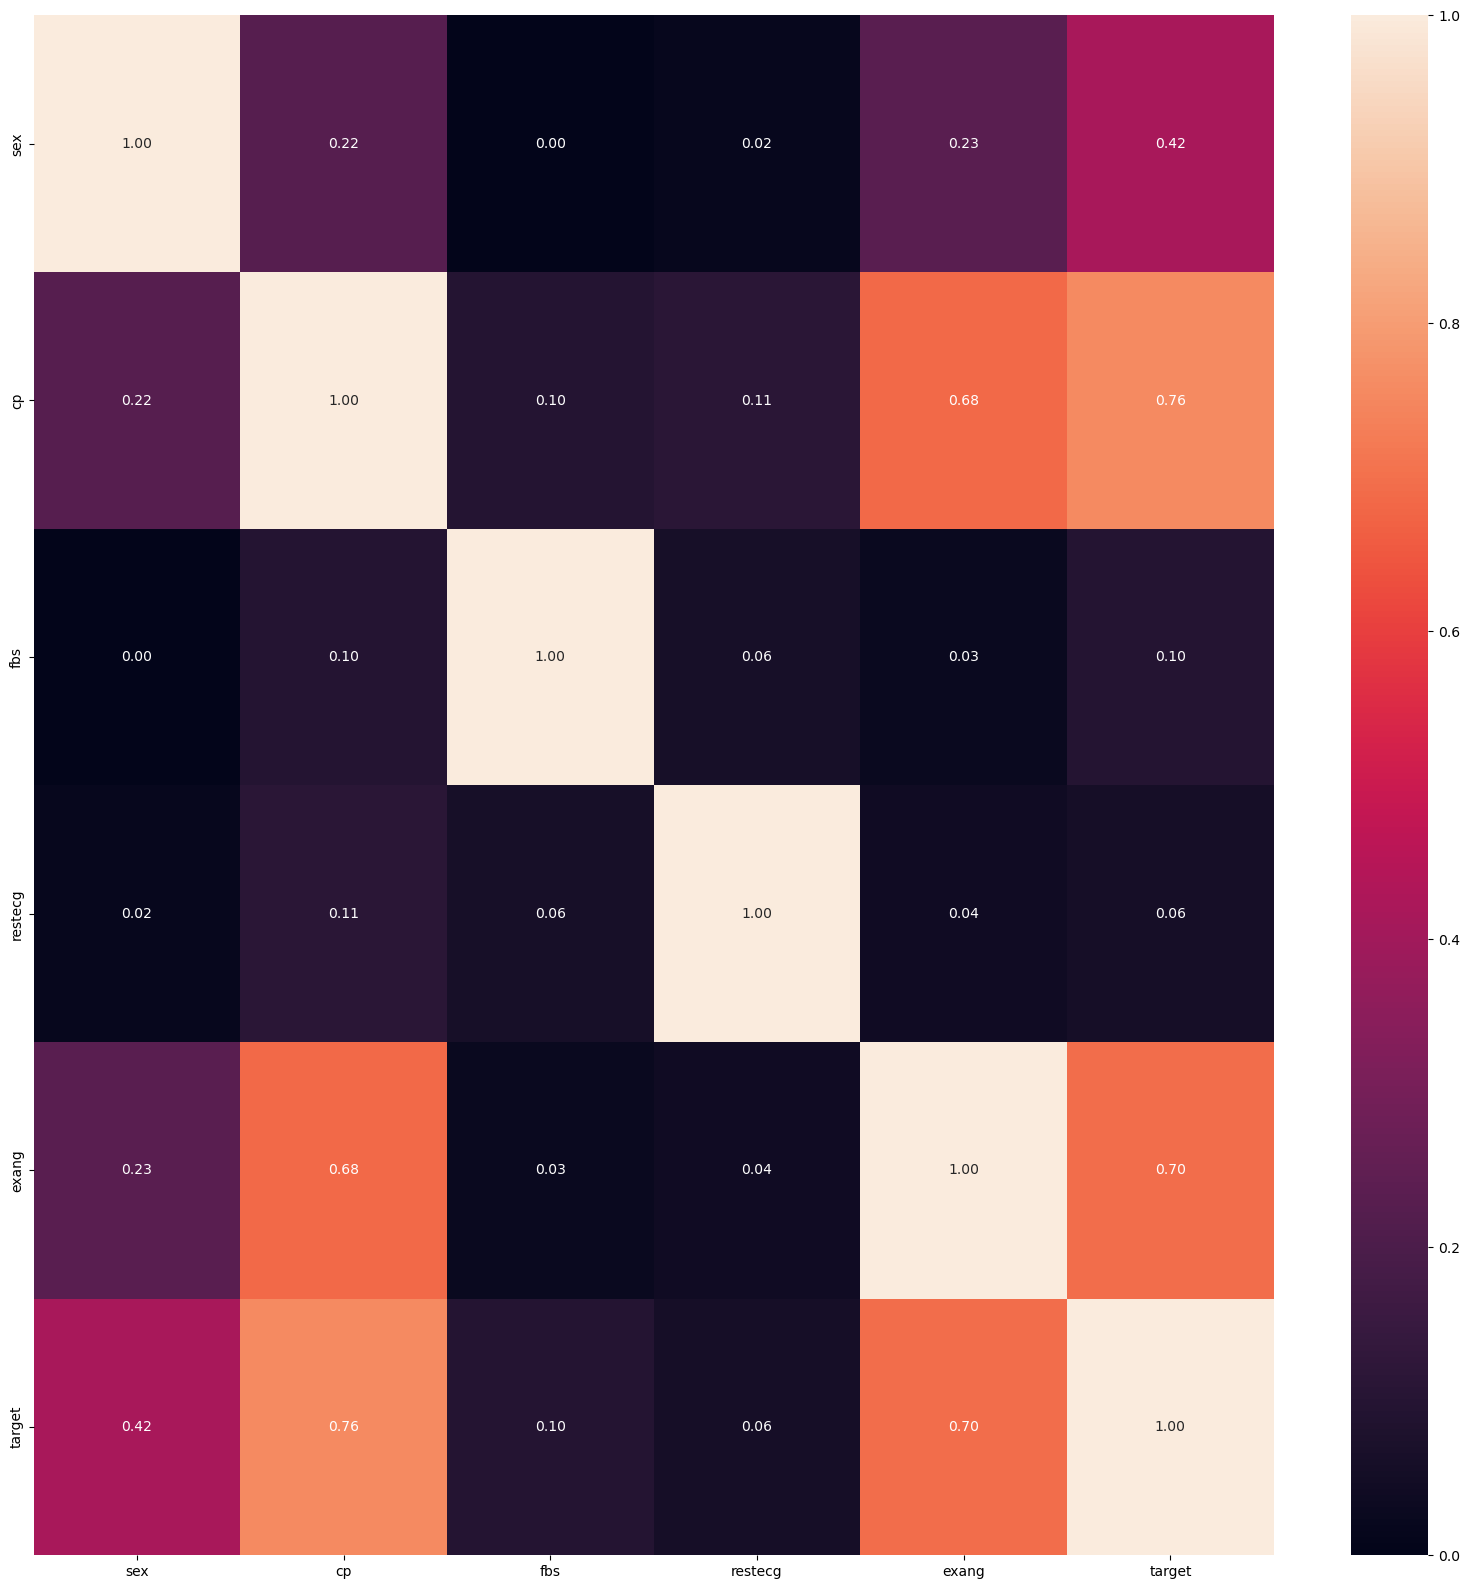

In [23]:
#  PhiK analysis of categorical columns

# Select only the categorical columns
df_train_categorical = df_train[cat_col_train]

# Calculate the phik correlation matrix for categorical columns
phik_overview = df_train_categorical.phik_matrix()

# Visualize the matrix
plt.figure(figsize=(20,20))
sns.heatmap(phik_overview, annot=True, fmt=".2f")
plt.show()


interval columns not set, guessing: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


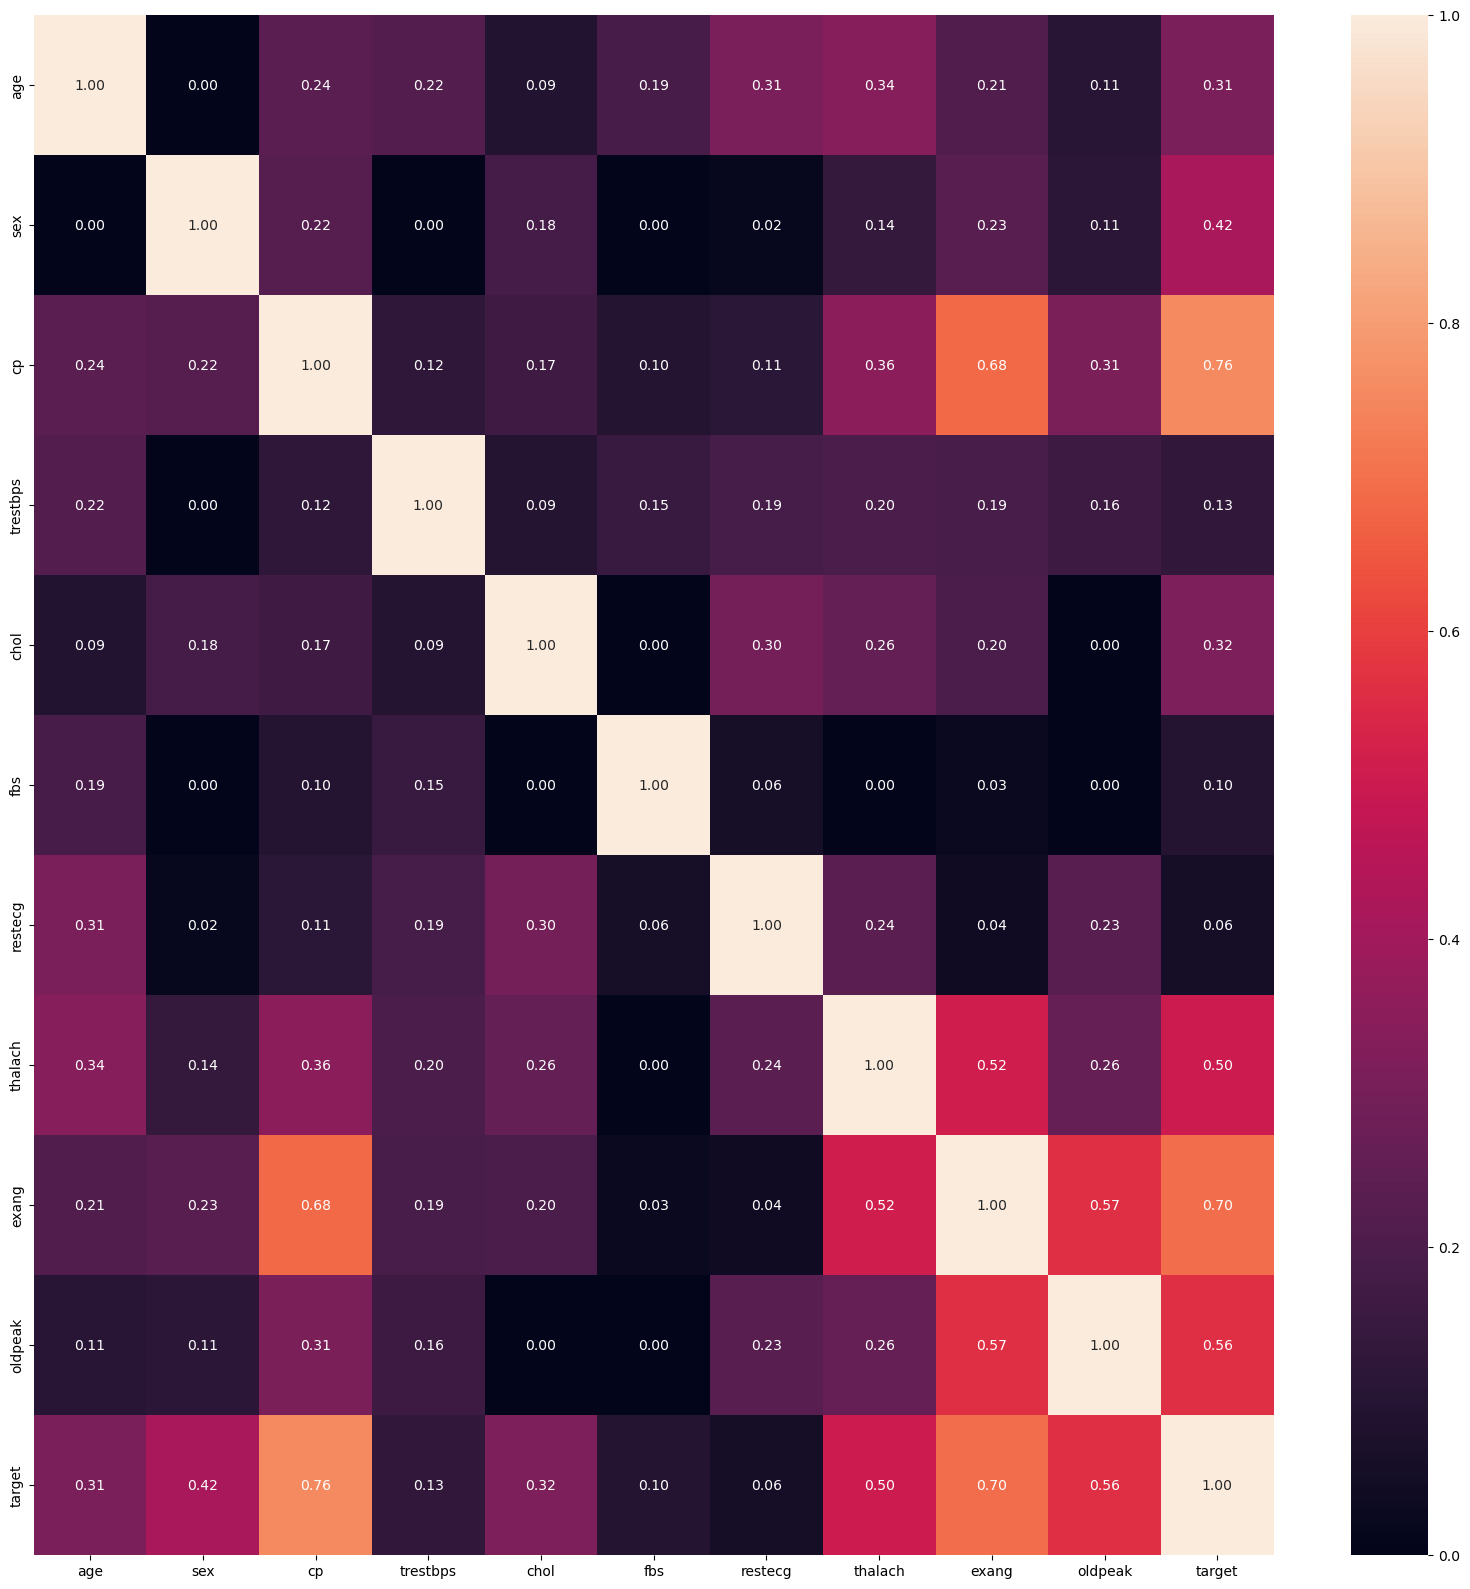

In [24]:
#  PhiK analysis of all selected numerical and categorical columns

plt.figure(figsize=(20,20))
sns.heatmap(df_train.phik_matrix(), annot=True, fmt=".2f")
plt.show()


- 

## train test split

In [25]:
# stratify train test split
train, test = train_test_split(df_train, 
                               test_size = 0.2, 
                               stratify=df_train['target'], 
                               shuffle=True,
                               random_state = 2023)

In [26]:
# check value counts in train
train['target'].value_counts(normalize=True)

target
0   0.54
1   0.46
Name: proportion, dtype: float64

In [27]:
# check value counts in test
test['target'].value_counts(normalize=True)

target
0   0.54
1   0.46
Name: proportion, dtype: float64

In [28]:
# Seperate features and target
features = list(train.columns)
target = 'target'
features.remove(target)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## Data transformation

In [29]:
# Define a function to encode binary features
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, positive_label=1, negative_label=0):
        self.positive_label = positive_label
        self.negative_label = negative_label

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Ensure the input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        for col in X.columns:
            X[col] = X[col].map({self.positive_label: 1, self.negative_label: 0})

        # Return a numpy array
        return X.values


In [30]:
# Numerical features and transformer
numerical_features = num_col_train
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categorical features and transformer
categorical_features_1 = ['cp','restecg']
categorical_transformer_1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])



# BinaryEncoder for Yes & No binary features
categorical_features_2 = ['sex', 'fbs','exang']
categorical_transformer_2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binaryencoder', BinaryEncoder())])

In [31]:
# build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat1', categorical_transformer_1, categorical_features_1),
        ('cat2', categorical_transformer_2, categorical_features_2),
    ])

In [32]:
# Check the transformed dataframe

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)

# Convert back to DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed)

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(input_features=categorical_features_1)
ohe_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(input_features=categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + list(ohe_feature_names) + categorical_features_2 

# Set the column names of the DataFrame
X_train_transformed_df.columns = all_feature_names

# Check the transformed DataFrame with column names
X_train_transformed_df


age  trestbps  chol  thalach  oldpeak  cp_1  cp_2  cp_3  cp_4  \
0   -0.39     -0.69 -0.37    -0.69    -0.76  0.00  0.00  1.00  0.00   
1    0.39      0.74  1.12     0.49    -0.76  0.00  1.00  0.00  0.00   
2   -1.72     -0.69 -0.70     1.48    -0.76  0.00  1.00  0.00  0.00   
3    0.17     -0.69  0.21    -1.05    -0.76  0.00  0.00  0.00  1.00   
4   -0.06     -0.40  0.20     0.93     1.49  0.00  0.00  1.00  0.00   
..    ...       ...   ...      ...      ...   ...   ...   ...   ...   
483 -1.17     -0.12  0.20     0.30    -0.76  0.00  1.00  0.00  0.00   
484 -0.17      0.45  1.29    -0.69     1.58  0.00  0.00  0.00  1.00   
485 -1.83      1.02  0.42     1.01    -0.76  0.00  1.00  0.00  0.00   
486 -0.94      0.45 -2.59    -0.10    -0.29  0.00  0.00  0.00  1.00   
487  1.39      0.45  0.97    -0.38    -0.58  0.00  0.00  1.00  0.00   

     restecg_0  restecg_1  restecg_2  sex  fbs  exang  
0         1.00       0.00       0.00 0.00 0.00   0.00  
1         1.00       0.00       0.00 1.00 0.00   0.00  
2         1.00       0.00       0.00 1.00 0.00   0.00  
3         1.00       0.00       0.00 1.00 0.00   1.00  
4         0.00       0.00       1.00 1.00 1.00   0.00  
..         ...        ...        ...  ...  ...    ...  
483       1.00       0.00       0.00 0.00 0.00   0.00  
484       0.00       1.00       0.00 1.00 0.00   1.00  
485       1.00       0.00       0.00 1.00 0.00   0.00  
486       0.00       1.00       0.00 1.00 0.00   1.00  
487       1.00       0.00       0.00 0.00 0.00   0.00  

[488 rows x 15 columns]

In [33]:
X_train_transformed_df.shape

(488, 15)

## Recursive Feature Elimination with cross validation (RFECV)

### LogisticRegression

In [34]:
# Transform the data using preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Define the estimator
model = LogisticRegression()

# Perform RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train_transformed, y_train)


RFECV(cv=5, estimator=LogisticRegression(), scoring='accuracy')

Optimal number of features: 15
Selected features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp_1', 'cp_2', 'cp_3', 'cp_4', 'restecg_0', 'restecg_1', 'restecg_2', 'sex', 'fbs', 'exang']


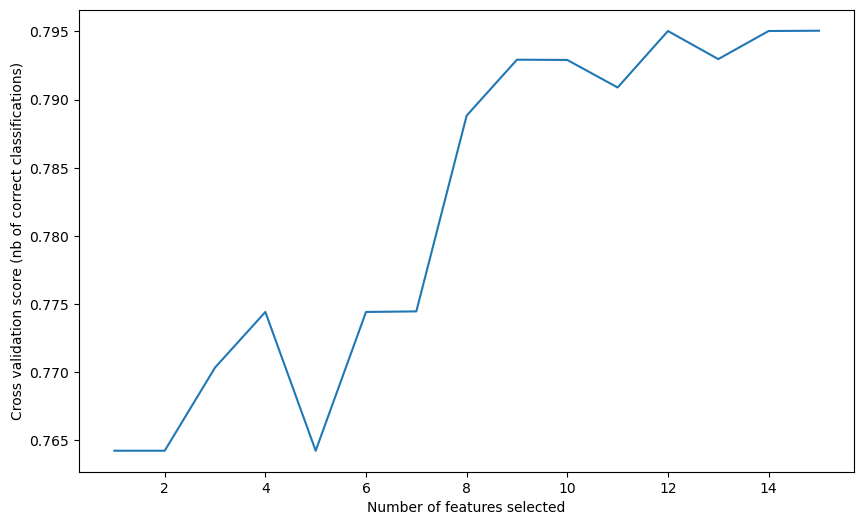

In [35]:
# Transform the data using preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Define the estimator
model = LogisticRegression()

# Perform RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train_transformed, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(input_features=categorical_features_1)
ohe_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(input_features=categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + list(ohe_feature_names) + categorical_features_2 
# Convert the list to a numpy array
all_feature_names = np.array(all_feature_names)
# Index the numpy array with the boolean mask
print('Selected features: %s' % list(all_feature_names[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()


In [36]:
# Fit the logistic regression model
model = LogisticRegression().fit(preprocessor.transform(X_train), y_train)

# Get the absolute value of coefficients
feature_importances = np.abs(model.coef_[0])

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importance_df.head(16))

      Feature  Importance
8        cp_4        1.28
12        sex        1.24
14      exang        0.80
6        cp_2        0.76
4     oldpeak        0.62
3     thalach        0.39
5        cp_1        0.34
2        chol        0.30
1    trestbps        0.23
11  restecg_2        0.21
7        cp_3        0.18
9   restecg_0        0.17
0         age        0.15
13        fbs        0.15
10  restecg_1        0.04


### RandomForestClassifier

Optimal number of features: 12
Selected features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'cp_2', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'sex', 'exang']


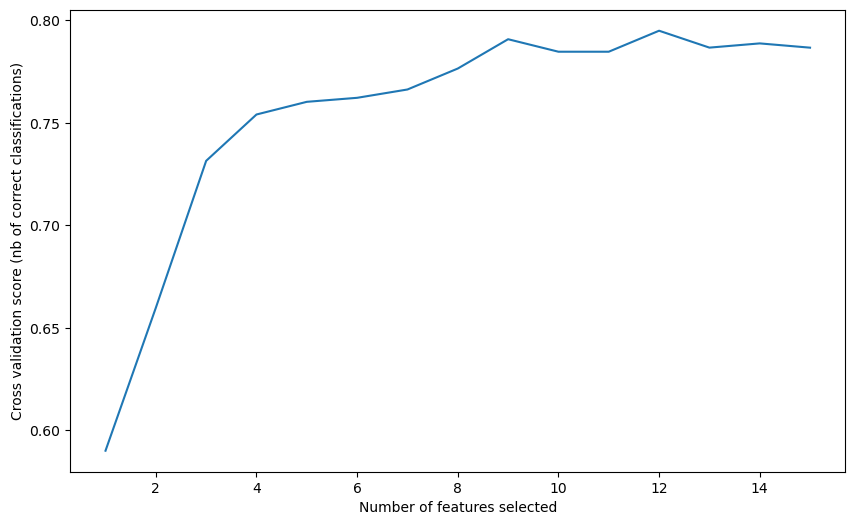

In [37]:
# Transform the data using preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Define the estimator
model = RandomForestClassifier(random_state=2023)

# Perform RFECV
rfecv = RFECV(estimator=model, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train_transformed, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(categorical_features_1)
ohe_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(input_features=categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + list(ohe_feature_names) + categorical_features_2 
# Convert the list to a numpy array
all_feature_names = np.array(all_feature_names)
# Index the numpy array with the boolean mask
print('Selected features: %s' % list(all_feature_names[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()


In [38]:
# Fit the RandomForestClassifier on preprocessed data
model.fit(preprocessor.transform(X_train), y_train)

# Get feature importances
importances = model.feature_importances_

# Combine feature names and importances into a DataFrame and sort by importance
feature_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top features
print(feature_importances.head(21))


      Feature  Importance
2        chol        0.15
3     thalach        0.14
4     oldpeak        0.12
8        cp_4        0.12
0         age        0.12
1    trestbps        0.10
14      exang        0.08
6        cp_2        0.05
12        sex        0.05
7        cp_3        0.02
11  restecg_2        0.01
9   restecg_0        0.01
13        fbs        0.01
5        cp_1        0.01
10  restecg_1        0.01


# Modelling

## Model 1 - use 12 features

- Let's try Logistic Regression, Random Forest, Gradient Boosting and XGBoost.

### Logistic Regression

#### Default 

In [163]:
# Define pipeline
model_lg = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('lg', LogisticRegression())
                    ])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg = model_lg.fit(X_train, y_train)
y_train_pred_lg = model_lg.predict(X_train)
y_test_pred_lg = model_lg.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg))

Cross-validation scores: [0.77777778 0.86666667 0.74358974 0.87804878 0.71428571]
Mean cross-validation score: 0.7960737365615415
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       262
           1       0.82      0.77      0.79       226

    accuracy                           0.81       488
   macro avg       0.81      0.81      0.81       488
weighted avg       0.81      0.81      0.81       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        66
           1       0.85      0.91      0.88        56

    accuracy                           0.89       122
   macro avg       0.88      0.89      0.88       122
weighted avg       0.89      0.89      0.89       122



#### SMOTE

In [164]:
# Define pipeline
model_lg_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('lg', LogisticRegression())
])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg_smote = model_lg_smote.fit(X_train, y_train)
y_train_pred_lg_smote = model_lg_smote.predict(X_train)
y_test_pred_lg_smote = model_lg_smote.predict(X_test)

# Print classification reports
print('Logistic Regression SMOTE Train', '\n',classification_report(y_train, y_train_pred_lg_smote))
print("Logistic Regression SMOTE Test", '\n',classification_report(y_test, y_test_pred_lg_smote))

Cross-validation scores: [0.76086957 0.86666667 0.775      0.84090909 0.69565217]
Mean cross-validation score: 0.7878194993412385
Logistic Regression SMOTE Train 
               precision    recall  f1-score   support

           0       0.82      0.81      0.81       262
           1       0.78      0.79      0.79       226

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488

Logistic Regression SMOTE Test 
               precision    recall  f1-score   support

           0       0.92      0.82      0.86        66
           1       0.81      0.91      0.86        56

    accuracy                           0.86       122
   macro avg       0.86      0.86      0.86       122
weighted avg       0.87      0.86      0.86       122



#### class_weight='balanced'

In [165]:
# Define pipeline
model_lg_bal = Pipeline(steps=
                    [('preprocessor', preprocessor),
                     ('lg', LogisticRegression(class_weight='balanced'))
                     ])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg_bal, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg_bal = model_lg_bal.fit(X_train, y_train)
y_train_pred_lg_bal = model_lg_bal.predict(X_train)
y_test_pred_lg_bal = model_lg_bal.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg_bal))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg_bal))

Cross-validation scores: [0.76086957 0.84782609 0.73809524 0.84090909 0.67391304]
Mean cross-validation score: 0.7723226049313006
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.81      0.82      0.81       262
           1       0.79      0.78      0.78       226

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.91      0.80      0.85        66
           1       0.80      0.91      0.85        56

    accuracy                           0.85       122
   macro avg       0.86      0.86      0.85       122
weighted avg       0.86      0.85      0.85       122



- Performace: defualt > SMOTE > Balanced weight, so plot ROC AUC Curve based on the defualt model

Logistic Regression ROC AUC (train): 0.885
Logistic Regression ROC AUC (test): 0.933


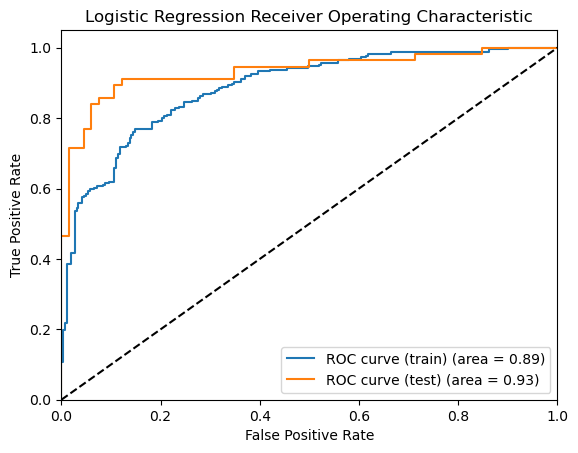

In [166]:
# Plot ROC AUC Curve
plot_roc_curve(model_lg, X_train, y_train, X_test, y_test, 'Logistic Regression')

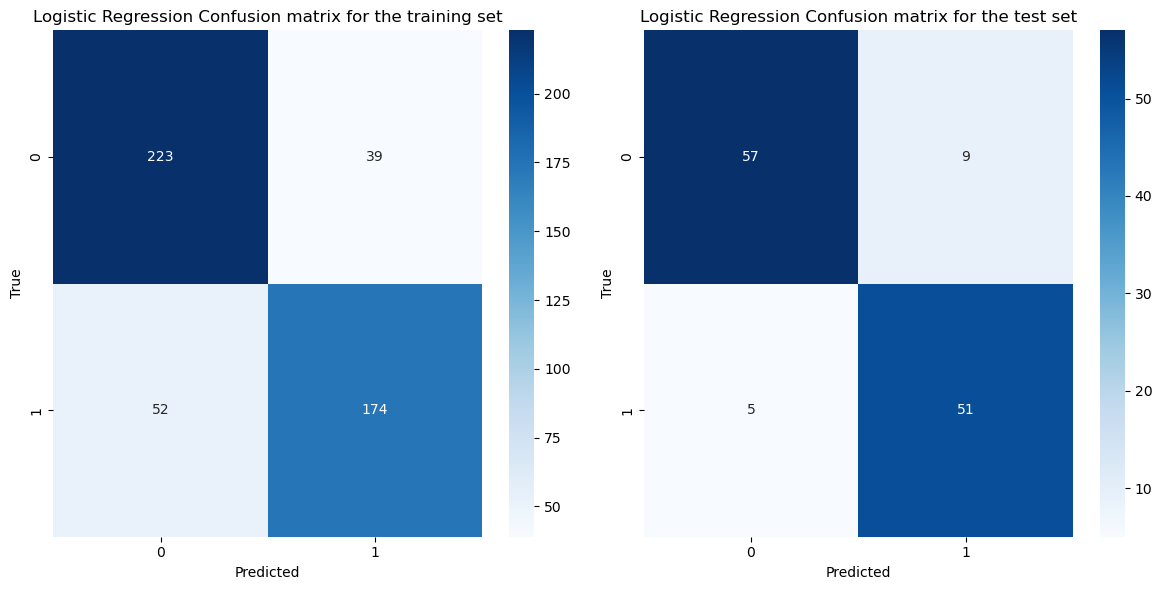

In [167]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_lg)
cm_test = confusion_matrix(y_test,  y_test_pred_lg)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### Hyperparameter tuning

In [159]:
# Define pipeline
model_lg = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('lg', LogisticRegression())
                    ])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg = model_lg.fit(X_train, y_train)
y_train_pred_lg = model_lg.predict(X_train)
y_test_pred_lg = model_lg.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg))

Cross-validation scores: [0.77777778 0.86666667 0.74358974 0.87804878 0.71428571]
Mean cross-validation score: 0.7960737365615415
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       262
           1       0.82      0.77      0.79       226

    accuracy                           0.81       488
   macro avg       0.81      0.81      0.81       488
weighted avg       0.81      0.81      0.81       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        66
           1       0.85      0.91      0.88        56

    accuracy                           0.89       122
   macro avg       0.88      0.89      0.88       122
weighted avg       0.89      0.89      0.89       122



In [160]:
# Define pipeline
model_lg = Pipeline(steps=
                    [('preprocessor', preprocessor),
                     ('lg', LogisticRegression(class_weight='balanced'))
                     ])

# Define hyperparameters to tune
param_grid = {
    'lg__C': [0.01, 0.1, 1],
    'lg__penalty': ['l1', 'l2', 'elasticnet'],
    'lg__solver': [ 'liblinear', 'saga'],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model_lg, param_grid, cv=5, scoring='precision')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict using the model with the best parameters
y_train_pred_lg = grid_search.predict(X_train)
y_test_pred_lg = grid_search.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg))

Best Parameters:  {'lg__C': 0.1, 'lg__penalty': 'l2', 'lg__solver': 'saga'}
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.81      0.82      0.82       262
           1       0.79      0.78      0.78       226

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        66
           1       0.84      0.91      0.87        56

    accuracy                           0.88       122
   macro avg       0.88      0.88      0.88       122
weighted avg       0.88      0.88      0.88       122



#### Feature importance 

In [161]:
# Feature names from preprocessor
feature_names_num = numerical_features
feature_names_cat1 = list(model_lg.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features_1))
feature_names_cat2 = ['sex','fbs','exang']
#feature_names_cat3 = ['Married', 'Dependents','Multiple Lines','Online Security','Online Backup','Device Protection Plan','Premium Tech Support','Streaming TV','Paperless Billing']

feature_names = feature_names_num + feature_names_cat1 + feature_names_cat2 

# Get the coefficients
#coefficients = model_lg.named_steps['lg'].coef_[0]
coefficients =grid_search.best_estimator_.named_steps['lg'].coef_[0]

# Combine feature names and coefficients into a dataframe
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort by absolute value of coefficients
feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)

# Print feature importance
print(feature_importance)


      Feature  Importance
8        cp_4        0.93
12        sex        0.74
14      exang        0.62
4     oldpeak        0.57
6        cp_2       -0.56
3     thalach       -0.38
2        chol       -0.26
7        cp_3       -0.22
1    trestbps        0.18
5        cp_1       -0.15
0         age        0.14
9   restecg_0       -0.12
11  restecg_2        0.12
13        fbs        0.09
10  restecg_1        0.00


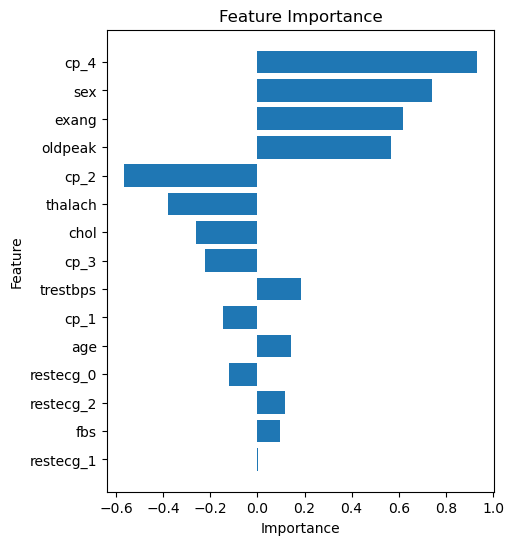

In [162]:
# First, create a new column with the absolute values of 'Importance'
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()

# Then, sort your DataFrame by 'Abs_Importance' in descending order
feature_importance = feature_importance.sort_values('Abs_Importance', ascending=True)

# Create a barh plot
plt.figure(figsize=(5, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Diagnosis Probability in test

In [118]:
# Predict the probability of churn for the test set
churn_probabilities_test = model_lg_bal.predict_proba(X_test)[:, 1]

# Convert the probabilities to a DataFrame for better visualization
churn_probabilities_test_df = pd.DataFrame(churn_probabilities_test, columns=['Diagnosis Probability'])

print(churn_probabilities_test_df)


     Diagnosis Probability
0                     0.52
1                     0.22
2                     0.13
3                     0.27
4                     0.10
..                     ...
117                   0.97
118                   0.86
119                   0.08
120                   0.99
121                   0.09

[122 rows x 1 columns]


### Random Forest

#### Default

In [51]:
# Define pipeline
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_rf = model_rf.fit(X_train, y_train)
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf))

Cross-validation scores: [0.80487805 0.86666667 0.81081081 0.81395349 0.67567568]
Mean cross-validation score: 0.7943969380611469
Random Forest Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        66
           1       0.82      0.82      0.82        56

    accuracy                           0.84       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.84      0.84      0.84       122



#### SMOTE

In [52]:
# Define pipeline
model_rf_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('rf', RandomForestClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_rf_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_rf_smote = model_rf_smote.fit(X_train, y_train)
y_train_pred_rf_smote = model_rf_smote.predict(X_train)
y_test_pred_rf_smote = model_rf_smote.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf_smote))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf_smote))

Cross-validation scores: [0.82926829 0.84444444 0.83333333 0.81395349 0.69230769]
Mean cross-validation score: 0.802661450228098
Random Forest Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        66
           1       0.81      0.82      0.81        56

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122



#### class_weight='balanced'

In [53]:
# Define pipeline
model_rf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_rf_bal, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_rf_bal = model_rf_bal.fit(X_train, y_train)
y_train_pred_rf_bal = model_rf_bal.predict(X_train)
y_test_pred_rf_bal = model_rf_bal.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf_bal))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf_bal))

Cross-validation scores: [0.83333333 0.88636364 0.81081081 0.81395349 0.69230769]
Mean cross-validation score: 0.8073537922375132
Random Forest Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87        66
           1       0.84      0.86      0.85        56

    accuracy                           0.86       122
   macro avg       0.86      0.86      0.86       122
weighted avg       0.86      0.86      0.86       122



- Performace: Balanced weight> defualt > SMOTE , so plot ROC AUC Curve based on the Balanced weight model

Random Forest ROC AUC (train): 1.000
Random Forest ROC AUC (test): 0.910


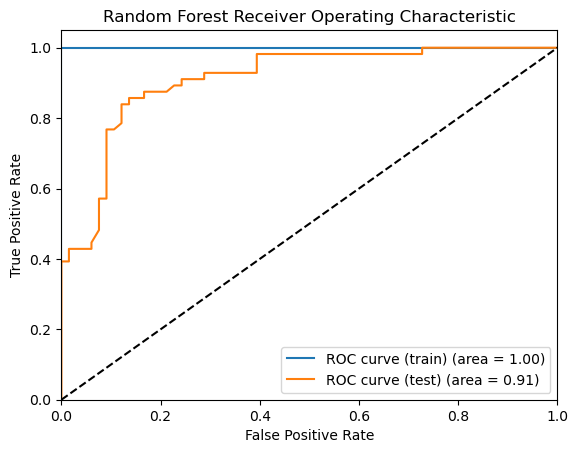

In [54]:
# Plot ROC AUC Curve
plot_roc_curve(model_rf_bal, X_train, y_train, X_test, y_test, 'Random Forest')

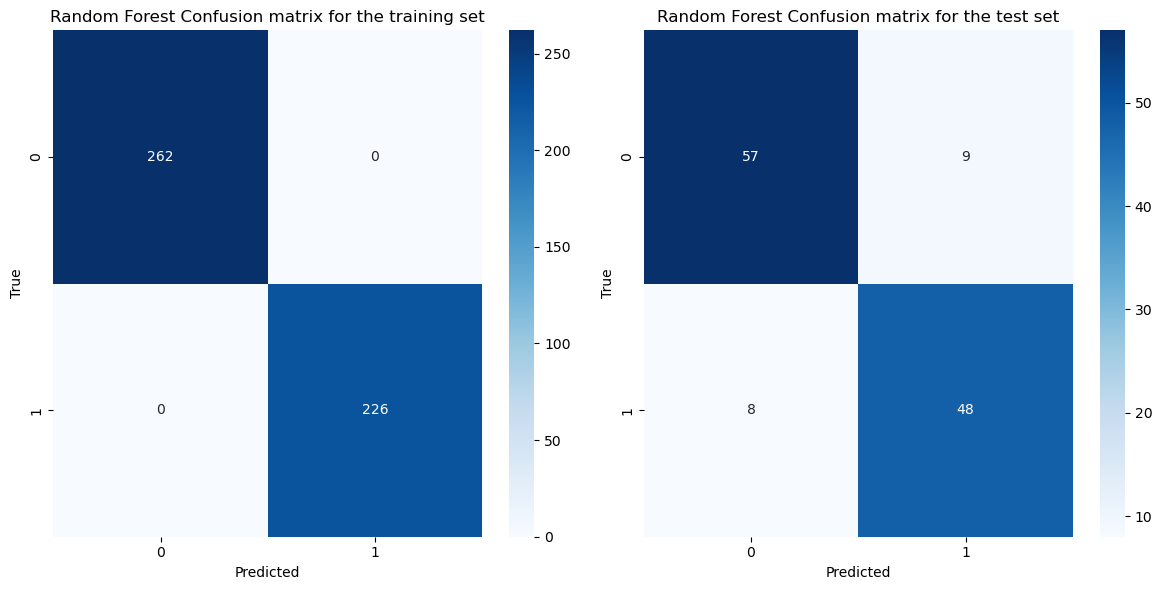

In [55]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_rf_bal)
cm_test = confusion_matrix(y_test,  y_test_pred_rf_bal)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### Feature importance

In [56]:
# Get the feature importance
feature_importance = model_rf_bal.named_steps['rf'].feature_importances_

feature_names_num = numerical_features
feature_names_cat1 = list(model_rf_bal.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features_1))
feature_names_cat2 = ['sex','fbs','exang']

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + feature_names_cat1 + categorical_features_2 
# Convert the list to a numpy array
all_feature_names = np.array(all_feature_names)

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

      Feature  Importance
3     thalach        0.14
2        chol        0.14
8        cp_4        0.12
4     oldpeak        0.12
0         age        0.11
1    trestbps        0.11
14      exang        0.08
6        cp_2        0.05
12        sex        0.05
7        cp_3        0.02
9   restecg_0        0.02
11  restecg_2        0.01
13        fbs        0.01
5        cp_1        0.01
10  restecg_1        0.01


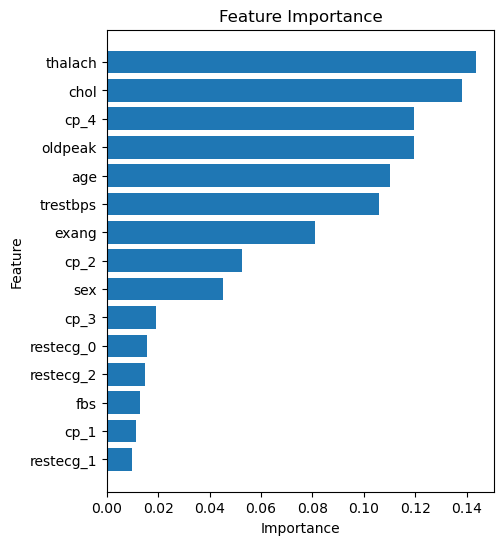

In [57]:
# Sort the DataFrame by importance in ascending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Create a barh plot
plt.figure(figsize=(5, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Diagnosis Probability in test

In [58]:
# Predict the probability of churn for the test set
Diagnosis_probabilities_test = model_rf.predict_proba(X_test)[:, 1]

# Convert the probabilities to a DataFrame for better visualization
Diagnosis_probabilities_test_df = pd.DataFrame(Diagnosis_probabilities_test, columns=['Diagnosis Probability'])

print(Diagnosis_probabilities_test_df)

     Diagnosis Probability
0                     0.27
1                     0.21
2                     0.36
3                     0.15
4                     0.01
..                     ...
117                   0.95
118                   0.62
119                   0.12
120                   1.00
121                   0.08

[122 rows x 1 columns]


- It's over fitting.

### Gradient Boosting

#### Default

In [124]:
# Define pipeline
model_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_gb, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_gb = model_gb.fit(X_train, y_train)
y_train_pred_gb = model_gb.predict(X_train)
y_test_pred_gb = model_gb.predict(X_test)

# Print classification reports
print('Gradient Boosting Train', '\n',classification_report(y_train, y_train_pred_gb))
print("Gradient Boosting Test", '\n',classification_report(y_test, y_test_pred_gb))

Cross-validation scores: [0.77272727 0.80434783 0.80952381 0.75555556 0.70212766]
Mean cross-validation score: 0.7688564246936125
Gradient Boosting Train 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       262
           1       0.95      0.93      0.94       226

    accuracy                           0.94       488
   macro avg       0.95      0.94      0.94       488
weighted avg       0.94      0.94      0.94       488

Gradient Boosting Test 
               precision    recall  f1-score   support

           0       0.82      0.80      0.81        66
           1       0.77      0.79      0.78        56

    accuracy                           0.80       122
   macro avg       0.79      0.79      0.79       122
weighted avg       0.80      0.80      0.80       122



#### SMOTE

In [130]:
# Define pipeline
model_gb_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('gb', GradientBoostingClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_gb_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_gb_smote = model_gb_smote.fit(X_train, y_train)
y_train_pred_gb_smote = model_gb_smote.predict(X_train)
y_test_pred_gb_smote = model_gb_smote.predict(X_test)

# Print classification reports
print('Gradient Boosting Train', '\n',classification_report(y_train, y_train_pred_gb_smote))
print("Gradient Boosting Test", '\n',classification_report(y_test, y_test_pred_gb_smote))

Cross-validation scores: [0.75555556 0.80851064 0.7804878  0.75555556 0.6875    ]
Mean cross-validation score: 0.7575219108574064
Gradient Boosting Train 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       262
           1       0.93      0.93      0.93       226

    accuracy                           0.94       488
   macro avg       0.94      0.94      0.94       488
weighted avg       0.94      0.94      0.94       488

Gradient Boosting Test 
               precision    recall  f1-score   support

           0       0.85      0.79      0.82        66
           1       0.77      0.84      0.80        56

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



Gradient Boosting ROC AUC (train): 0.989
Gradient Boosting ROC AUC (test): 0.881


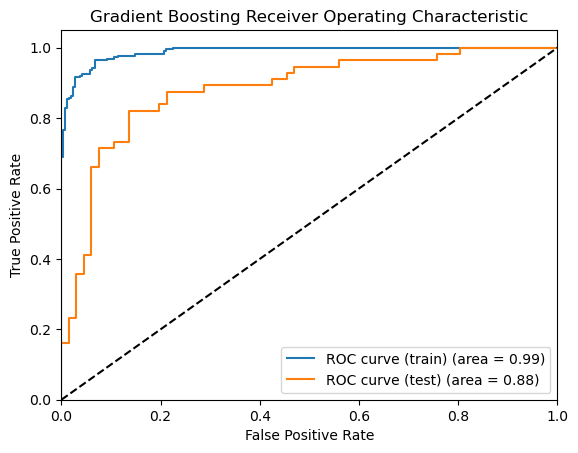

In [131]:
# Plot ROC AUC Curve
plot_roc_curve(model_gb_smote, X_train, y_train, X_test, y_test, 'Gradient Boosting')

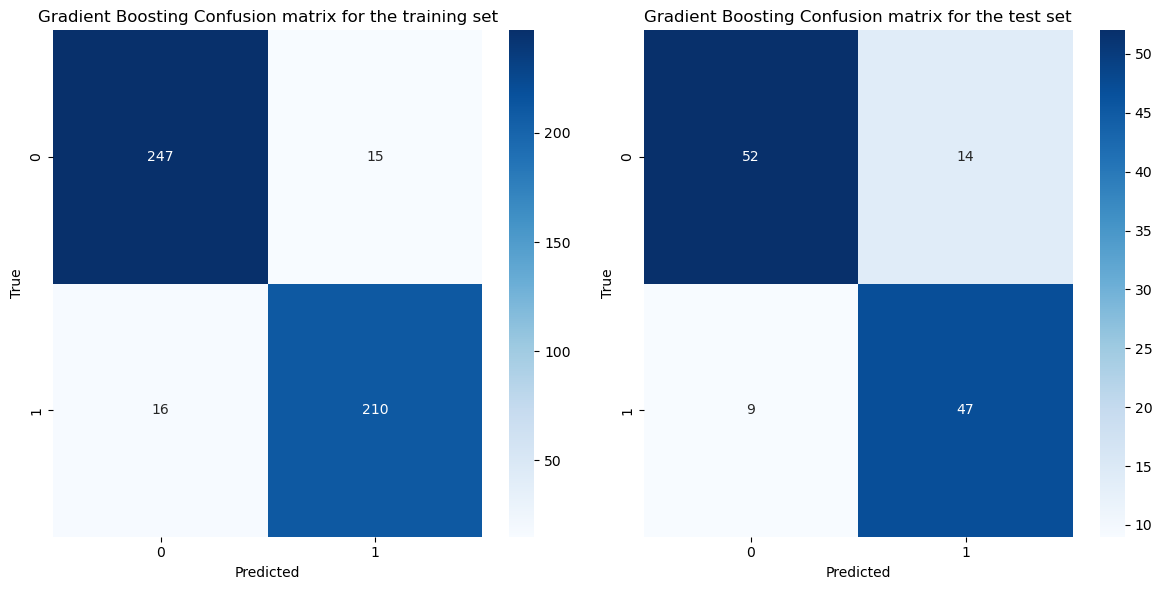

In [132]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_gb_smote)
cm_test = confusion_matrix(y_test,  y_test_pred_gb_smote)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### Feature importance

In [133]:
# Get the feature importance
feature_importance = model_gb_smote.named_steps['gb'].feature_importances_

feature_names_num = numerical_features
feature_names_cat1 = list(model_gb_smote.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features_1))
feature_names_cat2 = ['sex','fbs','exang']

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + feature_names_cat1 + categorical_features_2 
# Convert the list to a numpy array
all_feature_names = np.array(all_feature_names)

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

      Feature  Importance
8        cp_4        0.33
2        chol        0.17
4     oldpeak        0.11
0         age        0.08
3     thalach        0.07
1    trestbps        0.07
14      exang        0.07
12        sex        0.06
5        cp_1        0.01
9   restecg_0        0.01
6        cp_2        0.01
7        cp_3        0.01
13        fbs        0.00
10  restecg_1        0.00
11  restecg_2        0.00


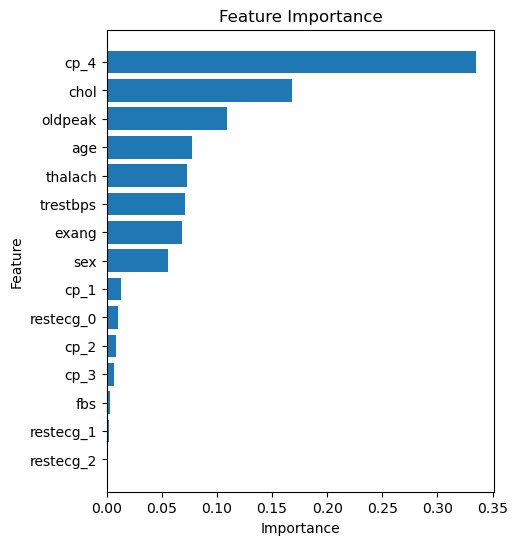

In [157]:
# Sort the DataFrame by importance in ascending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Create a barh plot
plt.figure(figsize=(5, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Diagnosis Probability in test

In [135]:
# Predict the probability of churn for the test set
churn_probabilities_test = model_gb_smote.predict_proba(X_test)[:, 1]

# Convert the probabilities to a DataFrame for better visualization
churn_probabilities_test_df = pd.DataFrame(churn_probabilities_test, columns=['Diagnosis Probability'])

print(churn_probabilities_test_df)

     Diagnosis Probability
0                     0.17
1                     0.17
2                     0.32
3                     0.11
4                     0.05
..                     ...
117                   0.99
118                   0.84
119                   0.07
120                   1.00
121                   0.05

[122 rows x 1 columns]


### XGBoost

#### Default

In [144]:
# Define pipeline
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_xgb = model_xgb.fit(X_train, y_train)
y_train_pred_xgb = model_xgb.predict(X_train)
y_test_pred_xgb = model_xgb.predict(X_test)

# Print classification reports
print('XGBoost Train', '\n',classification_report(y_train, y_train_pred_xgb))
print("XGBoost Test", '\n',classification_report(y_test, y_test_pred_xgb))

Cross-validation scores: [0.7804878  0.74468085 0.81395349 0.76744186 0.73913043]
Mean cross-validation score: 0.7691388879123393
XGBoost Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

XGBoost Test 
               precision    recall  f1-score   support

           0       0.78      0.77      0.78        66
           1       0.74      0.75      0.74        56

    accuracy                           0.76       122
   macro avg       0.76      0.76      0.76       122
weighted avg       0.76      0.76      0.76       122



#### SMOTE

In [145]:
# Define pipeline
model_xgb_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_xgb_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_xgb_smote = model_xgb_smote.fit(X_train, y_train)
y_train_pred_xgb_smote = model_xgb_smote.predict(X_train)
y_test_pred_xgb_smote = model_xgb_smote.predict(X_test)

# Print classification reports
print('XGBoost Train', '\n',classification_report(y_train, y_train_pred_xgb_smote))
print("XGBoost Test", '\n',classification_report(y_test, y_test_pred_xgb_smote))


Cross-validation scores: [0.74418605 0.79166667 0.79545455 0.75555556 0.66666667]
Mean cross-validation score: 0.7507058961710124
XGBoost Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

XGBoost Test 
               precision    recall  f1-score   support

           0       0.82      0.77      0.80        66
           1       0.75      0.80      0.78        56

    accuracy                           0.79       122
   macro avg       0.79      0.79      0.79       122
weighted avg       0.79      0.79      0.79       122



- SMOTE improve the model performance

XGBoost ROC AUC (train): 1.000
XGBoost ROC AUC (test): 0.838


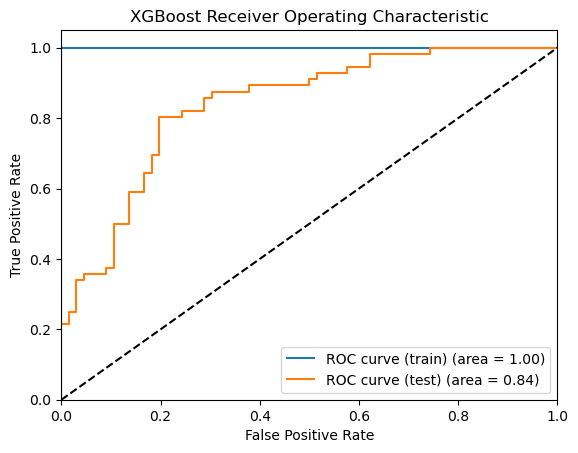

In [146]:
# Plot ROC AUC Curve
plot_roc_curve(model_xgb_smote, X_train, y_train, X_test, y_test, 'XGBoost')

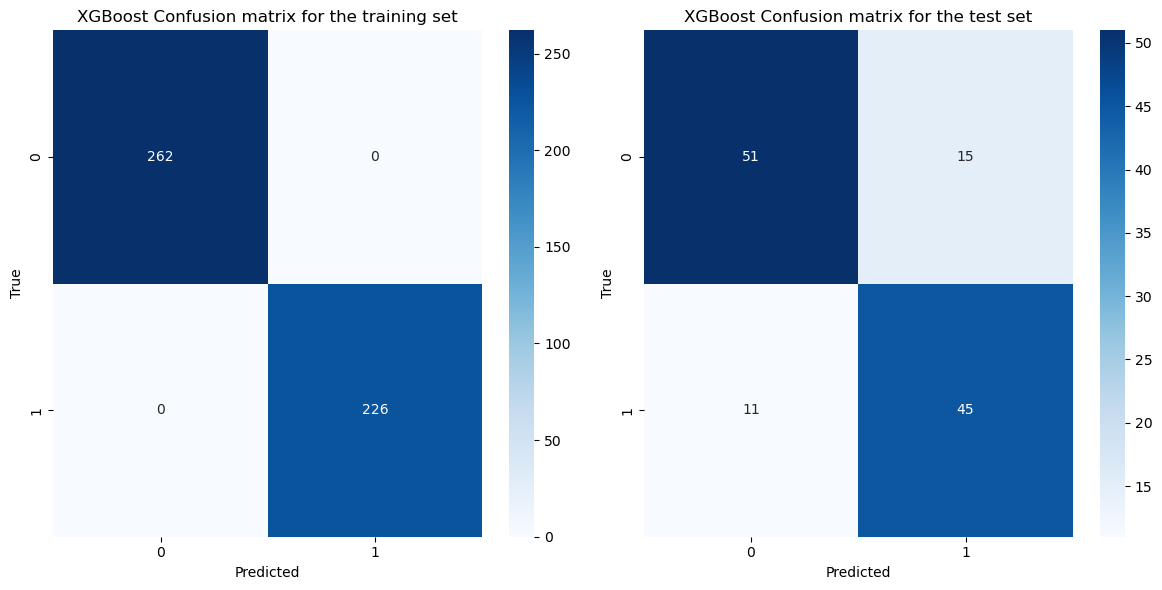

In [147]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_xgb_smote)
cm_test = confusion_matrix(y_test,  y_test_pred_xgb_smote)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

- It's over fitting

### LazyClassifier

In [150]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
# Define a custom metric function for precision
def custom_precision(y_test,  y_test_pred):
    return precision_score(y_test,  y_test_pred)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=custom_precision)
models, predictions = clf.fit(X_train_preprocessed, X_test_preprocessed, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 24.42it/s]

[LightGBM] [Info] Number of positive: 226, number of negative: 262
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 488, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463115 -> initscore=-0.147810
[LightGBM] [Info] Start training from score -0.147810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

### Models comparision

- Test performance: 
    
    - **Precision**: Logistic Regression (0.85)> Random Forest(0.84) >Gradient Boosting(0.77) > XGBoost(0.75)  
    - **ROC-AUC**:   Logistic regression (0.93) > Random Forest(0.91) > Gradient Boosting(0.88) > XGBoost(0.84)   
    - **Recall**:    Logistic Regression (0.91) >  Random Forest(0.86) > Gradient Boosting(0.84) > XGBoost(0.80) 

- We might care more about precision, also Logistic Regression has the best performance for all metric scores. so I would choose Logistic Regression. Also considering interpretability, Logistic Regression is the best.

- I'll also choose Random Forest as a second model to tune hyperparameters, because it has a relative high recall, ROC-AUC and precision. Besides, it's run fast. but it is overfitted in train data. Let's check after hyperparameter tuning, if it performs better than Logistic Regression.

### Hyperparameter tuning-LogisticRegression

In [181]:
# Define the Logistic Regression pipeline
model_lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', LogisticRegression(class_weight='balanced'))
])

# Define hyperparameter distribution
param_dist = {
    'lg__C': uniform(loc=0.01, scale=2.0),  # Uniform distribution for regularization strength
    'lg__penalty': ['l1', 'l2', 'elasticnet'],  # List of regularization types
    'lg__solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs']  # List of optimization algorithms
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model_lg, param_distributions=param_dist, n_iter=50, cv=5, scoring='precision', random_state=2023)

# Fit and predict
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_lg = random_search.predict(X_train)
y_test_pred_lg = random_search.predict(X_test)

# Print classification reports
print('Logistic Regression tuned Train', '\n', classification_report(y_train, y_train_pred_lg))
print("Logistic Regression tuned Test", '\n', classification_report(y_test, y_test_pred_lg))


Best parameters: {'lg__C': 0.04090327806450799, 'lg__penalty': 'l2', 'lg__solver': 'newton-cg'}
Logistic Regression tuned Train 
               precision    recall  f1-score   support

           0       0.81      0.82      0.81       262
           1       0.78      0.77      0.78       226

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488

Logistic Regression tuned Test 
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        66
           1       0.85      0.89      0.87        56

    accuracy                           0.88       122
   macro avg       0.88      0.88      0.88       122
weighted avg       0.88      0.88      0.88       122



In [188]:
# Define the Logistic Regression pipeline
model_lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', LogisticRegression())
])

# Define hyperparameter grid
param_grid = {
    'lg__C': [0.001,0.01, 0.1, 1,10],  # Regularization strength
    'lg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'lg__solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs']  # Optimization algorithm
}

# Create GridSearchCV object
grid_search = GridSearchCV(model_lg, param_grid, cv=5, scoring='f1')

# Fit and predict
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_lg = grid_search.predict(X_train)
y_test_pred_lg = grid_search.predict(X_test)

# Print classification reports
print('Logistic Regression tuned Train', '\n', classification_report(y_train, y_train_pred_lg))
print("Logistic Regression tuned Test", '\n', classification_report(y_test, y_test_pred_lg))


Best parameters: {'lg__C': 1, 'lg__penalty': 'l2', 'lg__solver': 'saga'}
Logistic Regression tuned Train 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       262
           1       0.82      0.77      0.79       226

    accuracy                           0.81       488
   macro avg       0.81      0.81      0.81       488
weighted avg       0.81      0.81      0.81       488

Logistic Regression tuned Test 
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        66
           1       0.85      0.91      0.88        56

    accuracy                           0.89       122
   macro avg       0.88      0.89      0.88       122
weighted avg       0.89      0.89      0.89       122



Logistic Regression tuned ROC AUC (train): 0.879
Logistic Regression tuned ROC AUC (test): 0.931


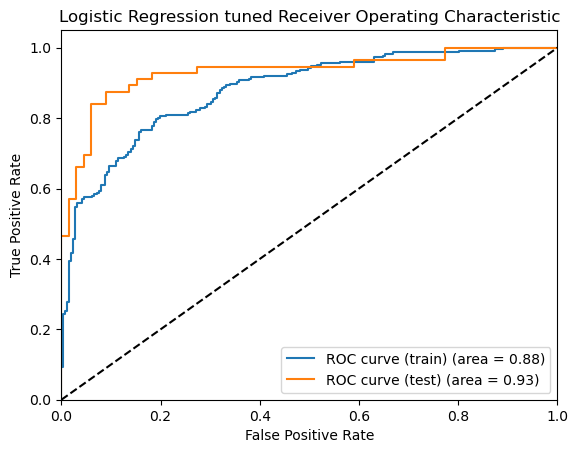

In [189]:
# Plot ROC AUC Curve
plot_roc_curve(random_search, X_train, y_train, X_test, y_test, 'Logistic Regression tuned')

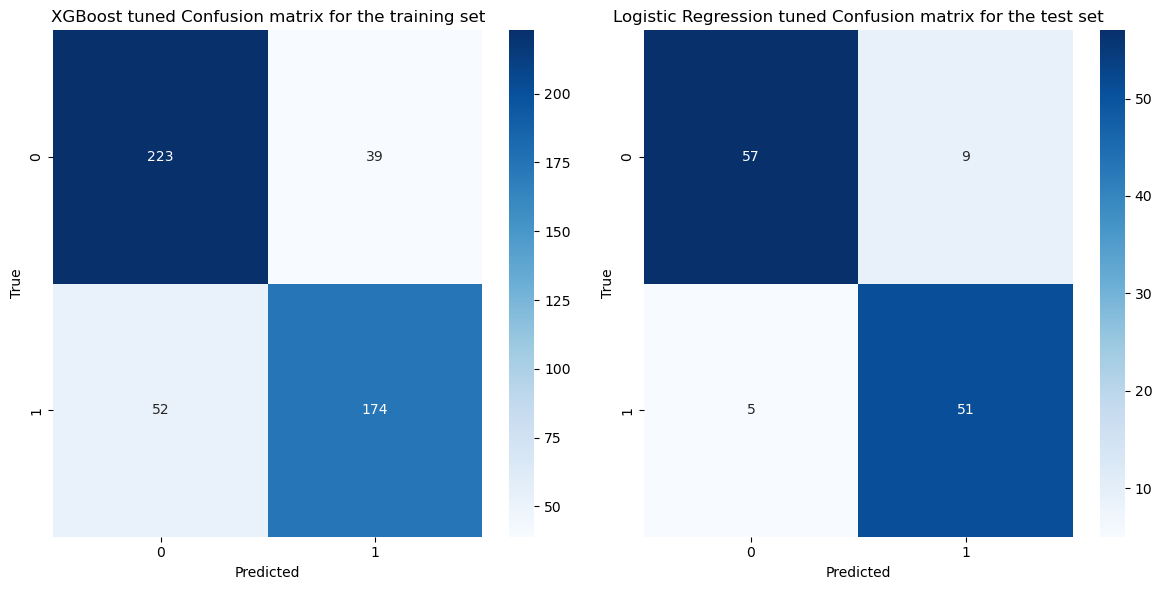

In [190]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_lg)
cm_test = confusion_matrix(y_test,  y_test_pred_lg)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Hyperparameter tuning-Random Forest

#### RandomizedSearchCV - optimizing precision 

In [47]:
model_rf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=2023))
])


# Define hyperparameter distribution
param_dist = {
    'rf__n_estimators': randint(50, 500),
    'rf__max_depth': randint(1, 20),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 20),
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model_rf_bal, param_dist, n_iter=50, cv=5, scoring='precision', random_state=2023)

# Fit and predict
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_rf = random_search.predict(X_train)
y_test_pred_rf = random_search.predict(X_test)

# Print classification reports
print('Random Forest tuned Train', '\n', classification_report(y_train, y_train_pred_rf))
print("Random Forest tuned Test", '\n', classification_report(y_test, y_test_pred_rf))


Best parameters: {'rf__max_depth': 7, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 422}
Random Forest tuned Train 
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       262
           1       0.92      0.91      0.91       226

    accuracy                           0.92       488
   macro avg       0.92      0.92      0.92       488
weighted avg       0.92      0.92      0.92       488

Random Forest tuned Test 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87        66
           1       0.83      0.88      0.85        56

    accuracy                           0.86       122
   macro avg       0.86      0.86      0.86       122
weighted avg       0.86      0.86      0.86       122



Random Forest tuned ROC AUC (train): 0.974
Random Forest tuned ROC AUC (test): 0.920


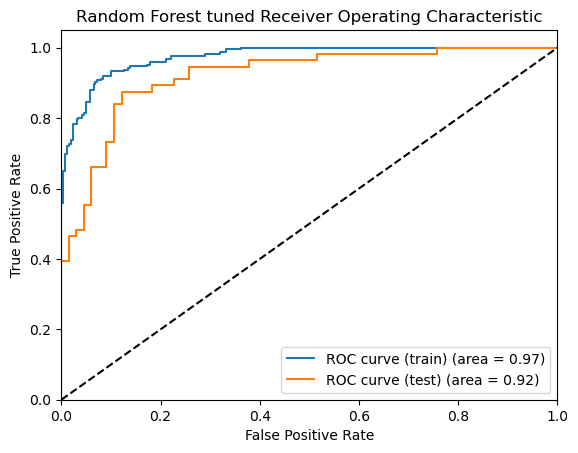

In [48]:
# Plot ROC AUC Curve
plot_roc_curve(random_search, X_train, y_train, X_test, y_test, 'Random Forest tuned')

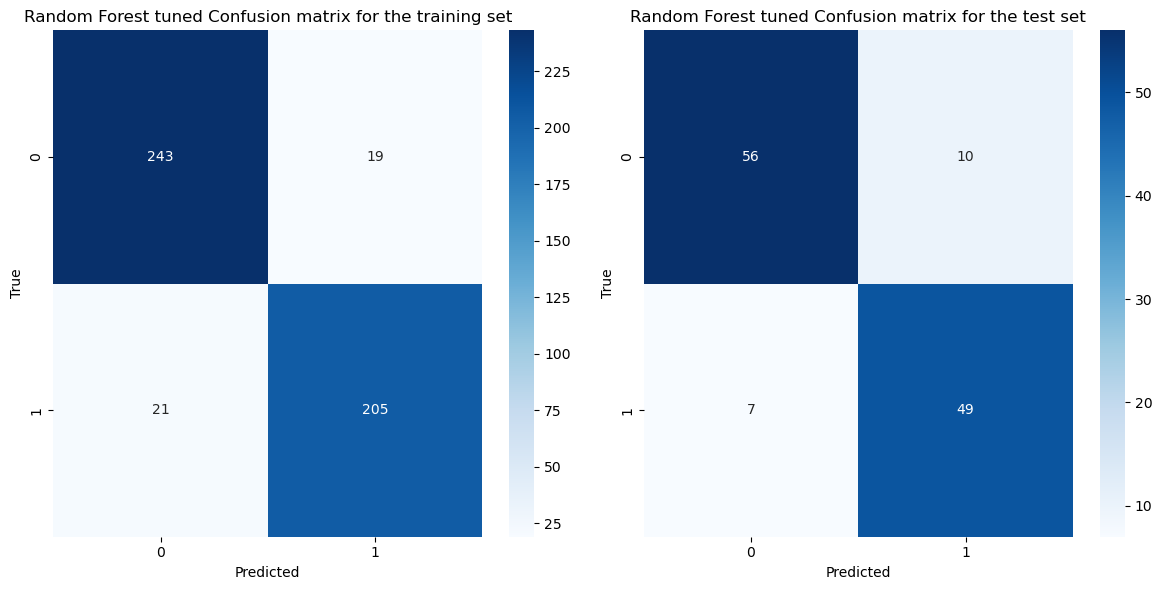

In [49]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_rf)
cm_test = confusion_matrix(y_test,  y_test_pred_rf)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### GridSearchCV - optimizing precision

In [42]:
model_rf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=2023))
])


# Define hyperparameter distribution
param_grid = {
    'rf__n_estimators': [50, 100, 200, 300, 500],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

# Create GridSearchCV object
grid_search = GridSearchCV(model_rf_bal, param_grid, cv=5, scoring='precision')

# Fit and predict
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_rf = grid_search.predict(X_train)
y_test_pred_rf = grid_search.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf))

Best parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Random Forest Train 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       262
           1       0.99      0.98      0.98       226

    accuracy                           0.99       488
   macro avg       0.99      0.99      0.99       488
weighted avg       0.99      0.99      0.99       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        66
           1       0.81      0.82      0.81        56

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.83      0.83      0.83       122



Random Forest ROC AUC (train): 0.999
Random Forest ROC AUC (test): 0.893


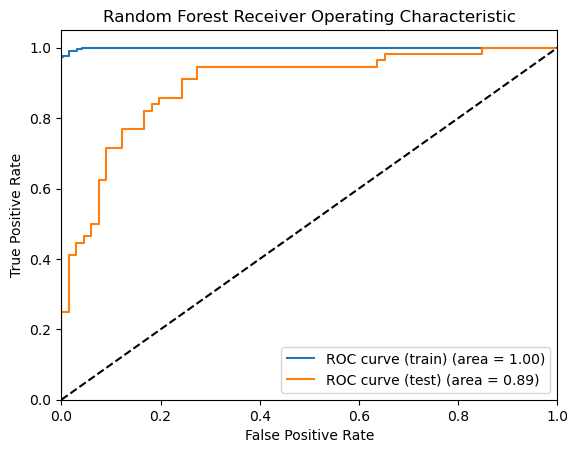

In [43]:
# Plot ROC AUC Curve
plot_roc_curve(grid_search, X_train, y_train, X_test, y_test, 'Random Forest')

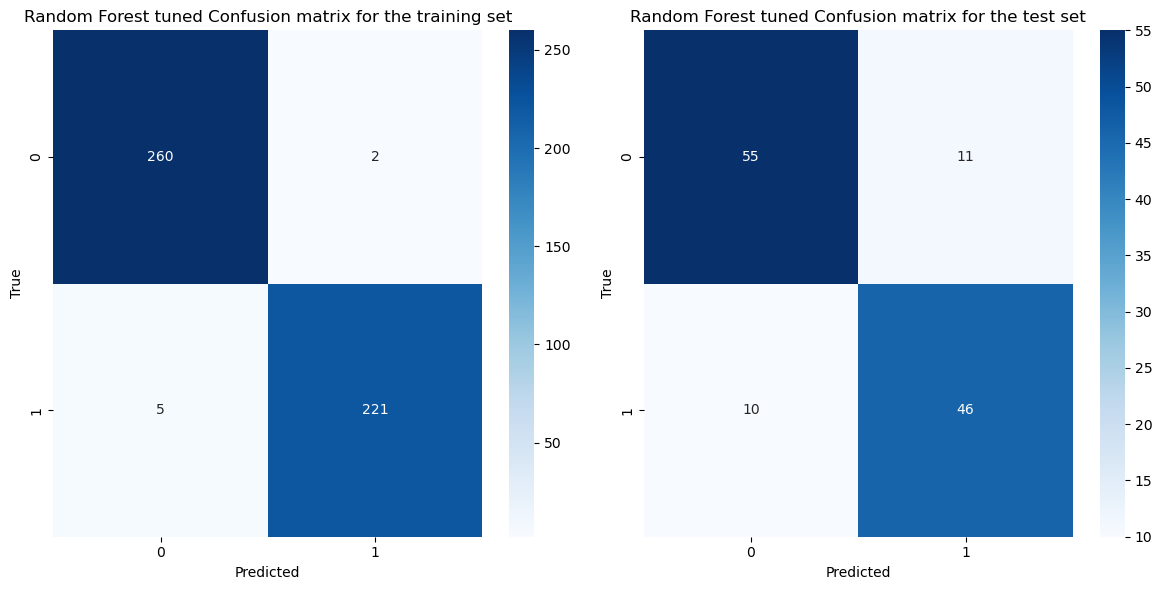

In [44]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_rf)
cm_test = confusion_matrix(y_test,  y_test_pred_rf)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Hyperparameter tuning-XGboost

In [151]:
# Define pipeline
model_xgb= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Define hyperparameter distribution
param_dist = {
    'xgb__n_estimators': randint(50, 500),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__max_depth': randint(1, 10)
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model_xgb, param_dist, n_iter=50, cv=5, scoring='precision', random_state=2023)

# Fit and predict
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_xgb = random_search.predict(X_train)
y_test_pred_xgb = random_search.predict(X_test)

# Print classification reports
print('XGBoost tuned Train', '\n',classification_report(y_train, y_train_pred_xgb))
print("XGBoost tuned Test", '\n',classification_report(y_test, y_test_pred_xgb))

Best parameters: {'xgb__learning_rate': 0.01931737049559531, 'xgb__max_depth': 2, 'xgb__n_estimators': 261}
XGBoost tuned Train 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       262
           1       0.85      0.81      0.83       226

    accuracy                           0.84       488
   macro avg       0.84      0.84      0.84       488
weighted avg       0.84      0.84      0.84       488

XGBoost tuned Test 
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        66
           1       0.84      0.88      0.86        56

    accuracy                           0.87       122
   macro avg       0.87      0.87      0.87       122
weighted avg       0.87      0.87      0.87       122



XGBoost tuned ROC AUC (train): 0.928
XGBoost tuned ROC AUC (test): 0.912


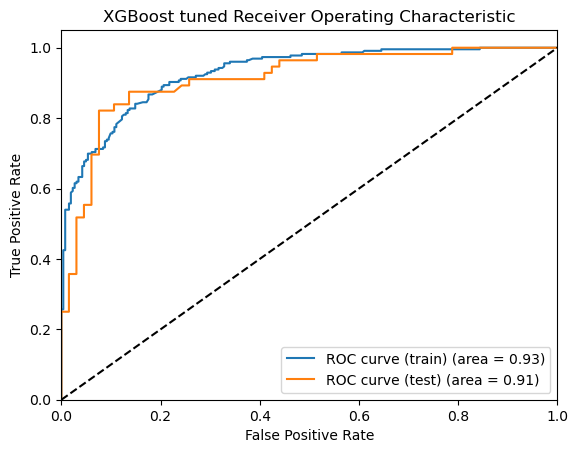

In [152]:
# Plot ROC AUC Curve
plot_roc_curve(random_search, X_train, y_train, X_test, y_test, 'XGBoost tuned')

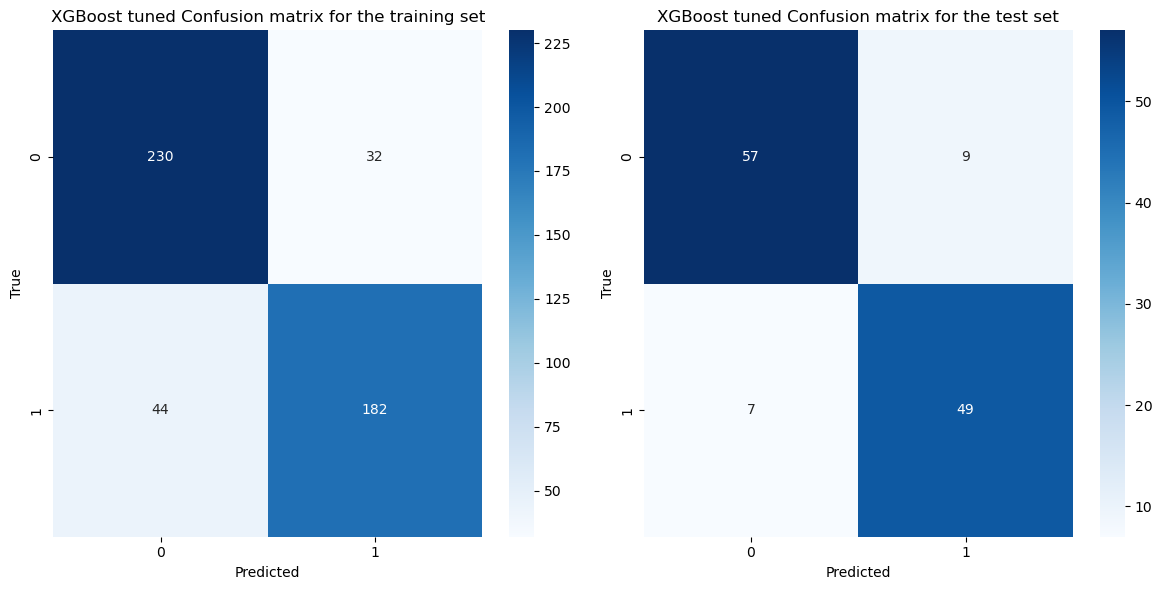

In [153]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_xgb)
cm_test = confusion_matrix(y_test,  y_test_pred_xgb)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### GridSearchCV - optimizing recall

In [154]:
# Define pipeline
model_xgb= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Define hyperparameter grid
param_grid = {
    'xgb__n_estimators': [460, 465, 470],
    'xgb__learning_rate': [0.17, 0.18, 0.19],
    'xgb__max_depth': [1, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='precision')

# Fit and predict
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_xgb = grid_search.predict(X_train)
y_test_pred_xgb = grid_search.predict(X_test)

# Print classification reports
print('XGBoost Train', '\n',classification_report(y_train, y_train_pred_xgb))
print("XGBoost Test", '\n',classification_report(y_test, y_test_pred_xgb))

Best parameters: {'xgb__learning_rate': 0.17, 'xgb__max_depth': 2, 'xgb__n_estimators': 460}
XGBoost Train 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       262
           1       0.97      0.98      0.98       226

    accuracy                           0.98       488
   macro avg       0.98      0.98      0.98       488
weighted avg       0.98      0.98      0.98       488

XGBoost Test 
               precision    recall  f1-score   support

           0       0.79      0.74      0.77        66
           1       0.72      0.77      0.74        56

    accuracy                           0.75       122
   macro avg       0.75      0.76      0.75       122
weighted avg       0.76      0.75      0.75       122



XGBoost tuned ROC AUC (train): 0.998
XGBoost tuned ROC AUC (test): 0.850


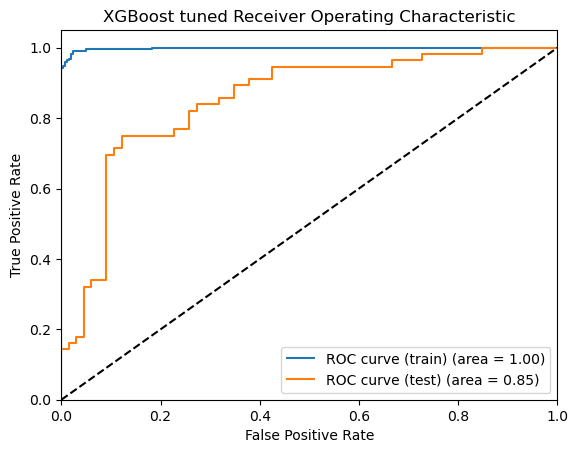

In [155]:
# Plot ROC AUC Curve
plot_roc_curve(grid_search, X_train, y_train, X_test, y_test, 'XGBoost tuned')

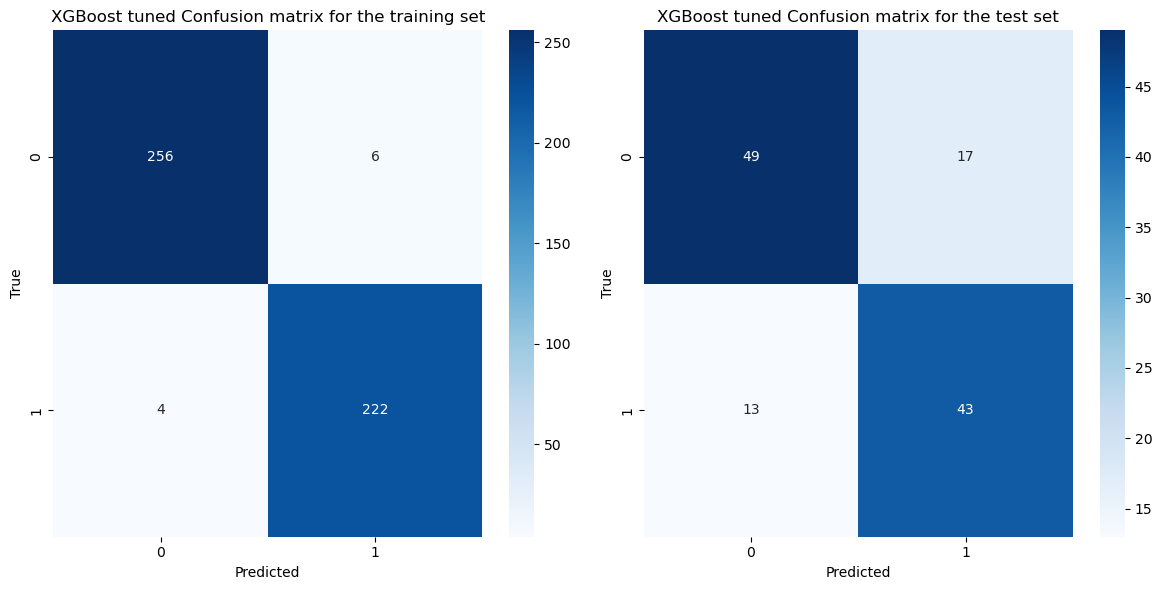

In [156]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_xgb)
cm_test = confusion_matrix(y_test,  y_test_pred_xgb)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

- After hyperparameter tuning, XGBoost doesn't perform better than Logistic Regression. 
- So I'll still choose Logistic Regression as the best model.

## Model 2 - use only 6 features 

According to feature importance in Logistic Regression, 
features importance orders: **'cp'**, **'sex'**, **'exang'**, **'old peak'**, **'thalach'**, **'chol'**, **'trestbps'**, **'age'**,**'restecg'**,**'fbs'** .

According to feature importance in Random Forest, 
features importance orders:**'thalach'**, **'chol'**,**'cp'**, **'old peak'**, **'age'**,**'trestbps'**, **'exang'**, **'restecg'**,**'fbs'** .

I would select 6 features which is easily and quickly obtained at the first instance when the patient is reveived.


interval columns not set, guessing: ['thalach', 'trestbps', 'age']


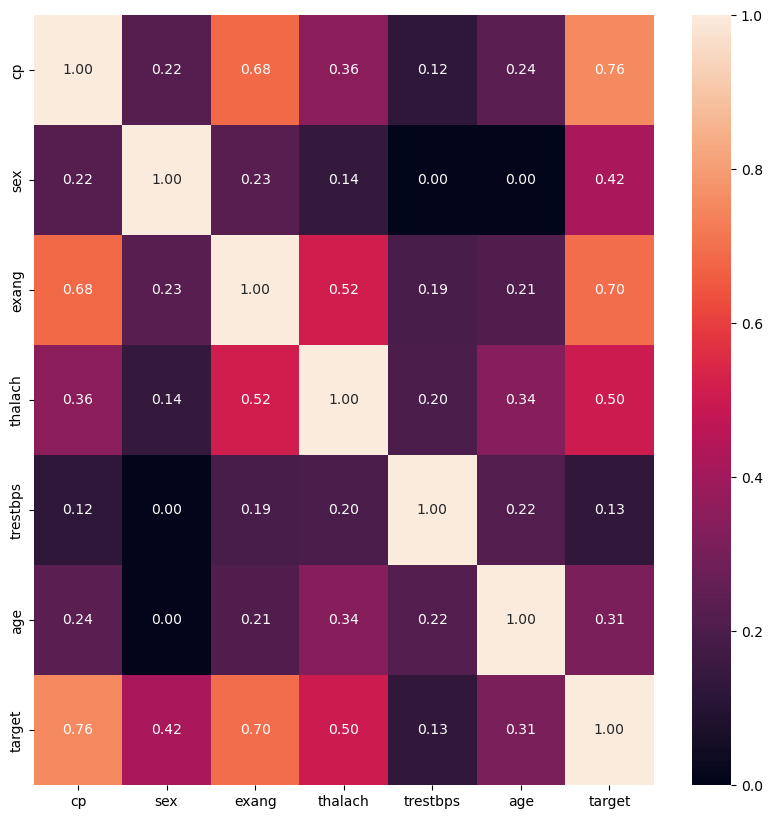

In [63]:
#  PhiK analysis of selected 6 features
df_model2 = df_clean[['cp', 'sex', 'exang', 'thalach', 'trestbps', 'age','target']]
plt.figure(figsize=(10,10))
sns.heatmap(df_model2.phik_matrix(), annot=True, fmt=".2f")
plt.show()

- Gtreat, 6 features are not highly correlated.

### Train Test Split 

In [64]:
df_model2

cp sex exang  thalach  trestbps  age target
0    1   1     0   150.00    145.00   63      0
1    4   1     1   108.00    160.00   67      1
2    4   1     1   129.00    120.00   67      1
3    3   1     0   187.00    130.00   37      0
4    2   0     0   172.00    130.00   41      0
..  ..  ..   ...      ...       ...  ...    ...
605  4   1     1   120.00    135.00   68      1
606  4   1     0   130.00    135.00   69      1
607  4   1     1    92.00    115.00   70      1
608  4   1     1   157.00    140.00   70      1
609  3   0     0   121.00    160.00   73      1

[610 rows x 7 columns]

In [65]:
# stratify train test split
train2, test2 = train_test_split(df_model2, 
                               test_size = 0.2, 
                               stratify=df_model2['target'], 
                               shuffle=True,
                               random_state = 2023)

In [66]:
# Seperate features and target
features = list(train2.columns)
target = 'target'
features.remove(target)

X_train = train2[features]
y_train = train2[target]

X_test = test2[features]
y_test = test2[target]

### Data transformation 

In [67]:
# Define a function to encode binary features
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, positive_label=1, negative_label=0):
        self.positive_label = positive_label
        self.negative_label = negative_label

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Ensure the input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        for col in X.columns:
            X[col] = X[col].map({self.positive_label: 1, self.negative_label: 0})

        # Return a numpy array
        return X.values


In [71]:
# Numerical features and transformer
numerical_features = ['thalach', 'trestbps', 'age']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categorical features and transformer
categorical_features_1 = ['cp']
categorical_transformer_1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])



# BinaryEncoder for Yes & No binary features
categorical_features_2 = ['sex', 'exang']
categorical_transformer_2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binaryencoder', BinaryEncoder())])

In [72]:
# build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat1', categorical_transformer_1, categorical_features_1),
        ('cat2', categorical_transformer_2, categorical_features_2),
    ])

In [73]:
# Check the transformed dataframe

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)

# Convert back to DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed)

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(input_features=categorical_features_1)
ohe_feature_names = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(input_features=categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + list(ohe_feature_names) + categorical_features_2 

# Set the column names of the DataFrame
X_train_transformed_df.columns = all_feature_names

# Check the transformed DataFrame with column names
X_train_transformed_df


thalach  trestbps   age  cp_1  cp_2  cp_3  cp_4  sex  exang
0      -0.69     -0.69 -0.39  0.00  0.00  1.00  0.00 0.00   0.00
1       0.49      0.74  0.39  0.00  1.00  0.00  0.00 1.00   0.00
2       1.48     -0.69 -1.72  0.00  1.00  0.00  0.00 1.00   0.00
3      -1.05     -0.69  0.17  0.00  0.00  0.00  1.00 1.00   1.00
4       0.93     -0.40 -0.06  0.00  0.00  1.00  0.00 1.00   0.00
..       ...       ...   ...   ...   ...   ...   ...  ...    ...
483     0.30     -0.12 -1.17  0.00  1.00  0.00  0.00 0.00   0.00
484    -0.69      0.45 -0.17  0.00  0.00  0.00  1.00 1.00   1.00
485     1.01      1.02 -1.83  0.00  1.00  0.00  0.00 1.00   0.00
486    -0.10      0.45 -0.94  0.00  0.00  0.00  1.00 1.00   1.00
487    -0.38      0.45  1.39  0.00  0.00  1.00  0.00 0.00   0.00

[488 rows x 9 columns]

In [74]:
X_train_transformed_df.shape

(488, 9)

### Logistic Regression

#### Default 

In [75]:
# Define pipeline
model_lg = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('lg', LogisticRegression())
                    ])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg = model_lg.fit(X_train, y_train)
y_train_pred_lg = model_lg.predict(X_train)
y_test_pred_lg = model_lg.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg))

Cross-validation scores: [0.7826087  0.84782609 0.76744186 0.82051282 0.68085106]
Mean cross-validation score: 0.779848105483284
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.79      0.82      0.81       262
           1       0.78      0.75      0.76       226

    accuracy                           0.79       488
   macro avg       0.79      0.78      0.78       488
weighted avg       0.79      0.79      0.79       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.85      0.80      0.83        66
           1       0.78      0.84      0.81        56

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122



#### SMOTE

In [76]:
# Define pipeline
model_lg_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('lg', LogisticRegression())
])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg_smote = model_lg_smote.fit(X_train, y_train)
y_train_pred_lg_smote = model_lg_smote.predict(X_train)
y_test_pred_lg_smote = model_lg_smote.predict(X_test)

# Print classification reports
print('Logistic Regression SMOTE Train', '\n',classification_report(y_train, y_train_pred_lg_smote))
print("Logistic Regression SMOTE Test", '\n',classification_report(y_test, y_test_pred_lg_smote))

Cross-validation scores: [0.7826087  0.84782609 0.76744186 0.80952381 0.66666667]
Mean cross-validation score: 0.7748134238528576
Logistic Regression SMOTE Train 
               precision    recall  f1-score   support

           0       0.81      0.80      0.80       262
           1       0.77      0.78      0.78       226

    accuracy                           0.79       488
   macro avg       0.79      0.79      0.79       488
weighted avg       0.79      0.79      0.79       488

Logistic Regression SMOTE Test 
               precision    recall  f1-score   support

           0       0.85      0.79      0.82        66
           1       0.77      0.84      0.80        56

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



#### class_weight='balanced'

In [77]:
# Define pipeline
model_lg_bal = Pipeline(steps=
                    [('preprocessor', preprocessor),
                     ('lg', LogisticRegression(class_weight='balanced'))
                     ])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg_bal, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg_bal = model_lg_bal.fit(X_train, y_train)
y_train_pred_lg_bal = model_lg_bal.predict(X_train)
y_test_pred_lg_bal = model_lg_bal.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg_bal))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg_bal))

Cross-validation scores: [0.7826087  0.84782609 0.76744186 0.80487805 0.66666667]
Mean cross-validation score: 0.7738842717041933
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       262
           1       0.78      0.78      0.78       226

    accuracy                           0.80       488
   macro avg       0.79      0.79      0.79       488
weighted avg       0.80      0.80      0.80       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.85      0.79      0.82        66
           1       0.77      0.84      0.80        56

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



- Performace: defualt > SMOTE > Balanced weight, so plot ROC AUC Curve based on the defualt model

Logistic Regression ROC AUC (train): 0.874
Logistic Regression ROC AUC (test): 0.907


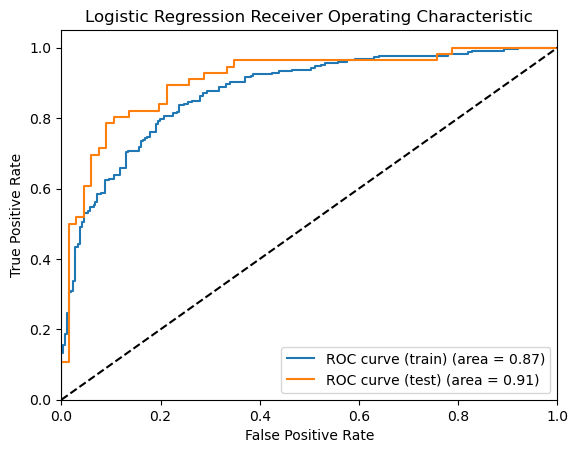

In [78]:
# Plot ROC AUC Curve
plot_roc_curve(model_lg, X_train, y_train, X_test, y_test, 'Logistic Regression')

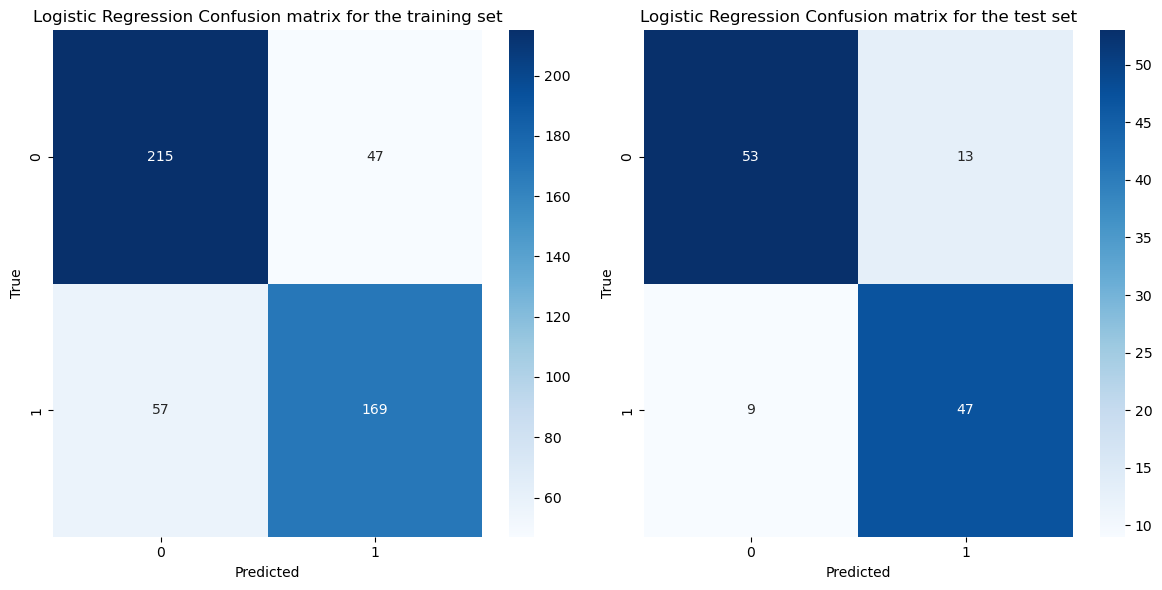

In [79]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_lg)
cm_test = confusion_matrix(y_test,  y_test_pred_lg)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### Hyperparameter tuning

In [80]:
# Define pipeline
model_lg = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('lg', LogisticRegression())
                    ])

# Perform cross-validation on the training set
scores = cross_val_score(model_lg, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_lg = model_lg.fit(X_train, y_train)
y_train_pred_lg = model_lg.predict(X_train)
y_test_pred_lg = model_lg.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg))

Cross-validation scores: [0.7826087  0.84782609 0.76744186 0.82051282 0.68085106]
Mean cross-validation score: 0.779848105483284
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.79      0.82      0.81       262
           1       0.78      0.75      0.76       226

    accuracy                           0.79       488
   macro avg       0.79      0.78      0.78       488
weighted avg       0.79      0.79      0.79       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.85      0.80      0.83        66
           1       0.78      0.84      0.81        56

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122



In [81]:
# Define pipeline
model_lg = Pipeline(steps=
                    [('preprocessor', preprocessor),
                     ('lg', LogisticRegression(class_weight='balanced'))
                     ])

# Define hyperparameters to tune
param_grid = {
    'lg__C': [0.01, 0.1, 1],
    'lg__penalty': ['l1', 'l2', 'elasticnet'],
    'lg__solver': [ 'liblinear', 'saga'],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model_lg, param_grid, cv=5, scoring='precision')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Predict using the model with the best parameters
y_train_pred_lg = grid_search.predict(X_train)
y_test_pred_lg = grid_search.predict(X_test)

# Print classification reports
print('Logistic Regression Train', '\n',classification_report(y_train, y_train_pred_lg))
print("Logistic Regression Test", '\n',classification_report(y_test, y_test_pred_lg))

Best Parameters:  {'lg__C': 1, 'lg__penalty': 'l2', 'lg__solver': 'liblinear'}
Logistic Regression Train 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       262
           1       0.78      0.78      0.78       226

    accuracy                           0.80       488
   macro avg       0.80      0.80      0.80       488
weighted avg       0.80      0.80      0.80       488

Logistic Regression Test 
               precision    recall  f1-score   support

           0       0.85      0.79      0.82        66
           1       0.77      0.84      0.80        56

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



#### Feature importance 

In [83]:
# Feature names from preprocessor
feature_names_num = numerical_features
feature_names_cat1 = list(model_lg.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features_1))
feature_names_cat2 = ['sex','exang']
#feature_names_cat3 = ['Married', 'Dependents','Multiple Lines','Online Security','Online Backup','Device Protection Plan','Premium Tech Support','Streaming TV','Paperless Billing']

feature_names = feature_names_num + feature_names_cat1 + feature_names_cat2 

# Get the coefficients
#coefficients = model_lg.named_steps['lg'].coef_[0]
coefficients =grid_search.best_estimator_.named_steps['lg'].coef_[0]

# Combine feature names and coefficients into a dataframe
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort by absolute value of coefficients
feature_importance = feature_importance.reindex(feature_importance.Importance.abs().sort_values(ascending=False).index)

# Print feature importance
print(feature_importance)


    Feature  Importance
4      cp_2       -1.35
7       sex        1.21
8     exang        1.06
6      cp_4        0.92
5      cp_3       -0.51
0   thalach       -0.41
3      cp_1       -0.36
2       age        0.28
1  trestbps        0.25


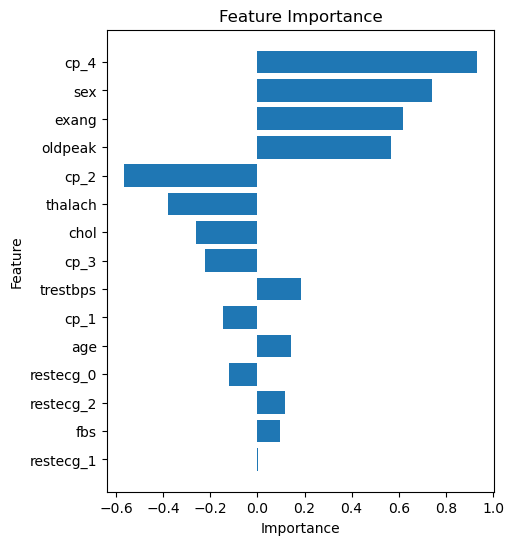

In [162]:
# First, create a new column with the absolute values of 'Importance'
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()

# Then, sort your DataFrame by 'Abs_Importance' in descending order
feature_importance = feature_importance.sort_values('Abs_Importance', ascending=True)

# Create a barh plot
plt.figure(figsize=(5, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Diagnosis Probability in test

In [84]:
# Predict the probability of churn for the test set
churn_probabilities_test = model_lg_bal.predict_proba(X_test)[:, 1]

# Convert the probabilities to a DataFrame for better visualization
churn_probabilities_test_df = pd.DataFrame(churn_probabilities_test, columns=['Diagnosis Probability'])

print(churn_probabilities_test_df)


     Diagnosis Probability
0                     0.35
1                     0.34
2                     0.11
3                     0.41
4                     0.13
..                     ...
117                   0.87
118                   0.88
119                   0.10
120                   0.97
121                   0.09

[122 rows x 1 columns]


### Random Forest

#### Default

In [93]:
# Define pipeline
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_rf = model_rf.fit(X_train, y_train)
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf))

Cross-validation scores: [0.81818182 0.84782609 0.76744186 0.82051282 0.66666667]
Mean cross-validation score: 0.7841258505565887
Random Forest Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.76      0.79      0.78        66
           1       0.74      0.71      0.73        56

    accuracy                           0.75       122
   macro avg       0.75      0.75      0.75       122
weighted avg       0.75      0.75      0.75       122



#### SMOTE

In [94]:
# Define pipeline
model_rf_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('rf', RandomForestClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_rf_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_rf_smote = model_rf_smote.fit(X_train, y_train)
y_train_pred_rf_smote = model_rf_smote.predict(X_train)
y_test_pred_rf_smote = model_rf_smote.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf_smote))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf_smote))

Cross-validation scores: [0.80851064 0.82978723 0.76190476 0.7804878  0.66666667]
Mean cross-validation score: 0.7694714211579805
Random Forest Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.78      0.77      0.78        66
           1       0.74      0.75      0.74        56

    accuracy                           0.76       122
   macro avg       0.76      0.76      0.76       122
weighted avg       0.76      0.76      0.76       122



#### class_weight='balanced'

In [95]:
# Define pipeline
model_rf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_rf_bal, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_rf_bal = model_rf_bal.fit(X_train, y_train)
y_train_pred_rf_bal = model_rf_bal.predict(X_train)
y_test_pred_rf_bal = model_rf_bal.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf_bal))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf_bal))

Cross-validation scores: [0.83333333 0.82608696 0.75       0.825      0.70731707]
Mean cross-validation score: 0.7883474726051608
Random Forest Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.78      0.79      0.78        66
           1       0.75      0.73      0.74        56

    accuracy                           0.76       122
   macro avg       0.76      0.76      0.76       122
weighted avg       0.76      0.76      0.76       122



- Performace: Balanced weight> defualt > SMOTE , so plot ROC AUC Curve based on the Balanced weight model

Random Forest ROC AUC (train): 1.000
Random Forest ROC AUC (test): 0.860


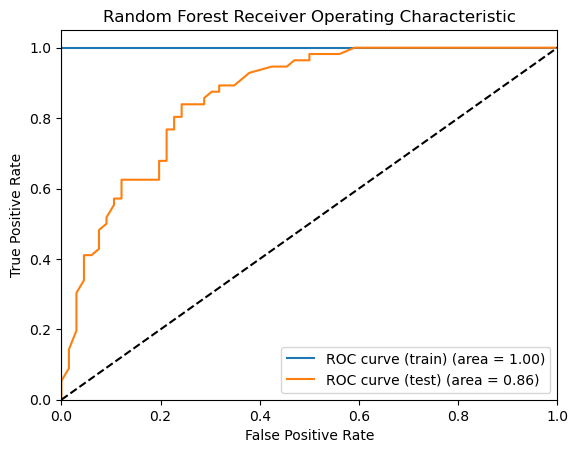

In [96]:
# Plot ROC AUC Curve
plot_roc_curve(model_rf_bal, X_train, y_train, X_test, y_test, 'Random Forest')

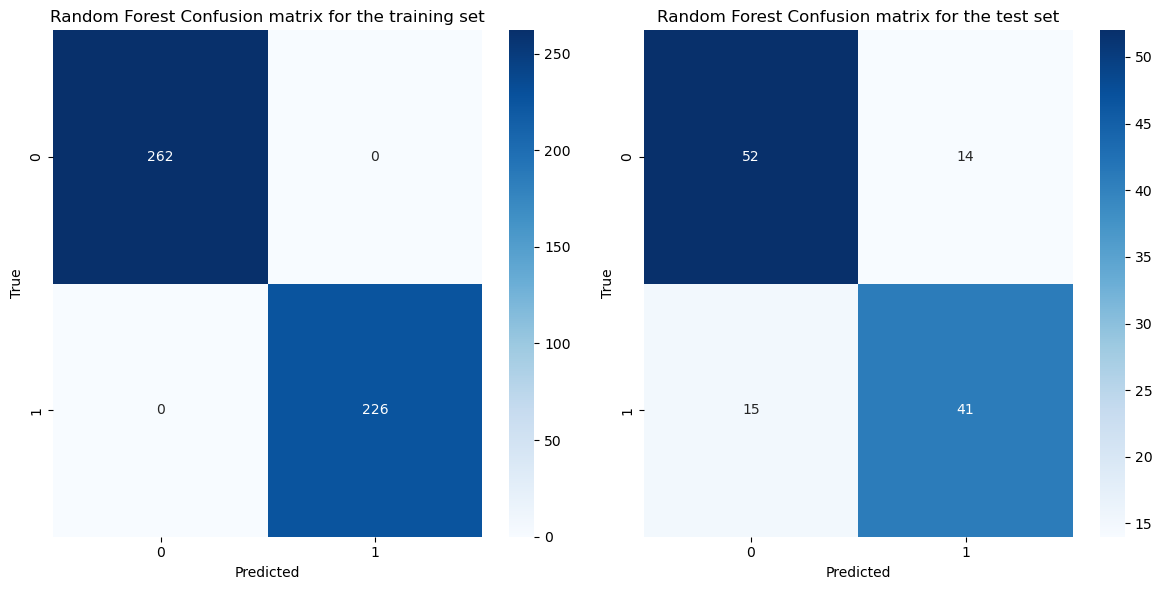

In [97]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_rf_bal)
cm_test = confusion_matrix(y_test,  y_test_pred_rf_bal)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### Feature importance

In [98]:
# Get the feature importance
feature_importance = model_rf_bal.named_steps['rf'].feature_importances_

feature_names_num = numerical_features
feature_names_cat1 = list(model_rf_bal.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features_1))
feature_names_cat2 = ['sex','fbs','exang']

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + feature_names_cat1 + categorical_features_2 
# Convert the list to a numpy array
all_feature_names = np.array(all_feature_names)

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

    Feature  Importance
0   thalach        0.24
2       age        0.19
6      cp_4        0.17
1  trestbps        0.17
8     exang        0.09
7       sex        0.06
4      cp_2        0.05
5      cp_3        0.02
3      cp_1        0.01


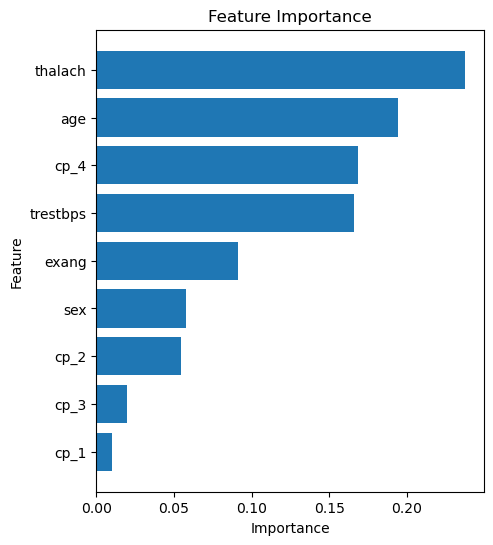

In [99]:
# Sort the DataFrame by importance in ascending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Create a barh plot
plt.figure(figsize=(5, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Diagnosis Probability in test

In [100]:
# Predict the probability of churn for the test set
Diagnosis_probabilities_test = model_rf.predict_proba(X_test)[:, 1]

# Convert the probabilities to a DataFrame for better visualization
Diagnosis_probabilities_test_df = pd.DataFrame(Diagnosis_probabilities_test, columns=['Diagnosis Probability'])

print(Diagnosis_probabilities_test_df)

     Diagnosis Probability
0                     0.20
1                     0.19
2                     0.35
3                     0.47
4                     0.00
..                     ...
117                   0.90
118                   0.82
119                   0.17
120                   1.00
121                   0.20

[122 rows x 1 columns]


- It's over fitting.

### Gradient Boosting

#### Default

In [113]:
# Define pipeline
model_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb', GradientBoostingClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_gb, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_gb = model_gb.fit(X_train, y_train)
y_train_pred_gb = model_gb.predict(X_train)
y_test_pred_gb = model_gb.predict(X_test)

# Print classification reports
print('Gradient Boosting Train', '\n',classification_report(y_train, y_train_pred_gb))
print("Gradient Boosting Test", '\n',classification_report(y_test, y_test_pred_gb))

Cross-validation scores: [0.82051282 0.75510204 0.73333333 0.76190476 0.63829787]
Mean cross-validation score: 0.7418301657815336
Gradient Boosting Train 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       262
           1       0.90      0.90      0.90       226

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488

Gradient Boosting Test 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79        66
           1       0.75      0.77      0.76        56

    accuracy                           0.78       122
   macro avg       0.78      0.78      0.78       122
weighted avg       0.78      0.78      0.78       122



#### SMOTE

In [114]:
# Define pipeline
model_gb_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('gb', GradientBoostingClassifier(random_state=2023))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_gb_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_gb_smote = model_gb_smote.fit(X_train, y_train)
y_train_pred_gb_smote = model_gb_smote.predict(X_train)
y_test_pred_gb_smote = model_gb_smote.predict(X_test)

# Print classification reports
print('Gradient Boosting Train', '\n',classification_report(y_train, y_train_pred_gb_smote))
print("Gradient Boosting Test", '\n',classification_report(y_test, y_test_pred_gb_smote))

Cross-validation scores: [0.80487805 0.76470588 0.71111111 0.78571429 0.64      ]
Mean cross-validation score: 0.7412818655917651
Gradient Boosting Train 
               precision    recall  f1-score   support

           0       0.92      0.91      0.92       262
           1       0.90      0.91      0.90       226

    accuracy                           0.91       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.91      0.91      0.91       488

Gradient Boosting Test 
               precision    recall  f1-score   support

           0       0.81      0.76      0.78        66
           1       0.73      0.79      0.76        56

    accuracy                           0.77       122
   macro avg       0.77      0.77      0.77       122
weighted avg       0.77      0.77      0.77       122



Gradient Boosting ROC AUC (train): 0.971
Gradient Boosting ROC AUC (test): 0.844


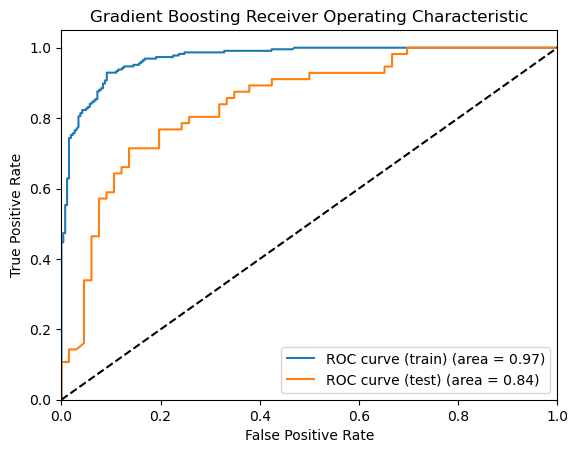

In [115]:
# Plot ROC AUC Curve
plot_roc_curve(model_gb, X_train, y_train, X_test, y_test, 'Gradient Boosting')

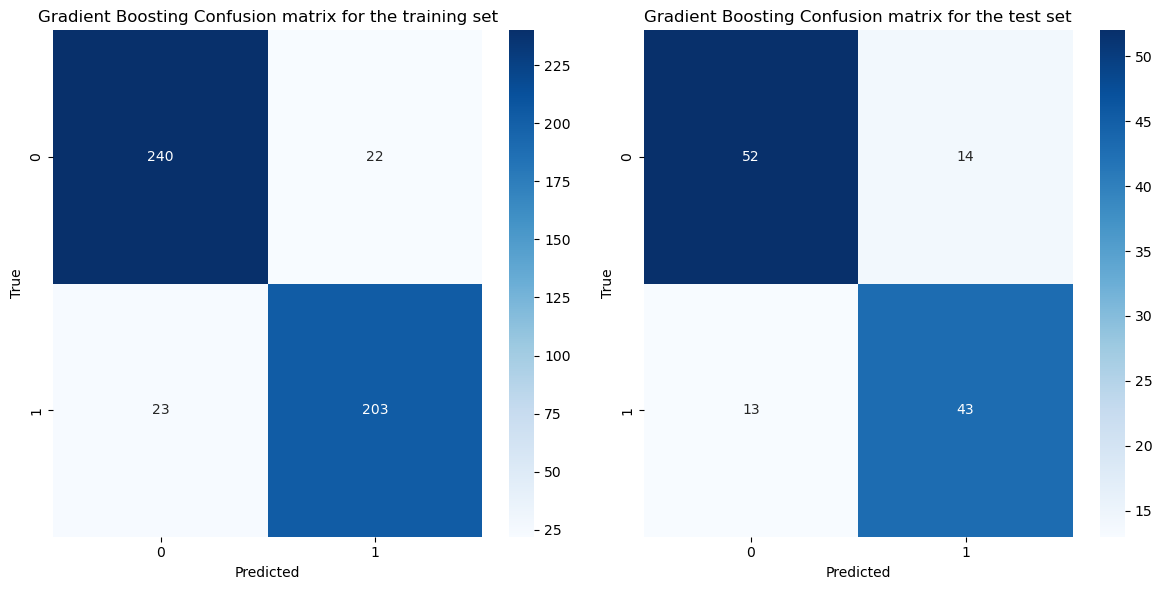

In [116]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_gb)
cm_test = confusion_matrix(y_test,  y_test_pred_gb)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### Feature importance

In [117]:
# Get the feature importance
feature_importance = model_gb.named_steps['gb'].feature_importances_

feature_names_num = numerical_features
feature_names_cat1 = list(model_gb.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features_1))
feature_names_cat2 = ['sex','fbs','exang']

# Get the list of feature names from one-hot encoder
#ohe_feature_names = preprocessor.named_transformers_['cat1'].named_steps['onehot'].get_feature_names(categorical_features_1)
# Combine all feature names
all_feature_names = numerical_features + feature_names_cat1 + categorical_features_2 
# Convert the list to a numpy array
all_feature_names = np.array(all_feature_names)

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

    Feature  Importance
6      cp_4        0.39
0   thalach        0.14
2       age        0.14
8     exang        0.13
1  trestbps        0.11
7       sex        0.07
4      cp_2        0.02
3      cp_1        0.01
5      cp_3        0.00


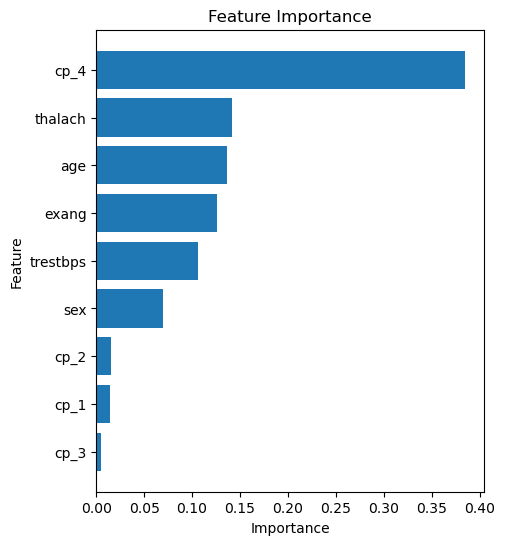

In [118]:
# Sort the DataFrame by importance in ascending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)

# Create a barh plot
plt.figure(figsize=(5, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

#### Diagnosis Probability in test

In [119]:
# Predict the probability of churn for the test set
churn_probabilities_test = model_gb_smote.predict_proba(X_test)[:, 1]

# Convert the probabilities to a DataFrame for better visualization
churn_probabilities_test_df = pd.DataFrame(churn_probabilities_test, columns=['Diagnosis Probability'])

print(churn_probabilities_test_df)

     Diagnosis Probability
0                     0.10
1                     0.18
2                     0.22
3                     0.44
4                     0.05
..                     ...
117                   0.97
118                   0.79
119                   0.07
120                   0.99
121                   0.05

[122 rows x 1 columns]


### XGBoost

#### Default

In [120]:
# Define pipeline
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_xgb = model_xgb.fit(X_train, y_train)
y_train_pred_xgb = model_xgb.predict(X_train)
y_test_pred_xgb = model_xgb.predict(X_test)

# Print classification reports
print('XGBoost Train', '\n',classification_report(y_train, y_train_pred_xgb))
print("XGBoost Test", '\n',classification_report(y_test, y_test_pred_xgb))

Cross-validation scores: [0.8372093  0.73333333 0.69565217 0.75       0.64583333]
Mean cross-validation score: 0.7324056285810584
XGBoost Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

XGBoost Test 
               precision    recall  f1-score   support

           0       0.78      0.76      0.77        66
           1       0.72      0.75      0.74        56

    accuracy                           0.75       122
   macro avg       0.75      0.75      0.75       122
weighted avg       0.76      0.75      0.75       122



#### SMOTE

In [121]:
# Define pipeline
model_xgb_smote= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Perform cross-validation on the training set
scores = cross_val_score(model_xgb_smote, X_train, y_train, cv=5, scoring='precision')

# Print cross-validation scores
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

# Fit and predict
model_xgb_smote = model_xgb_smote.fit(X_train, y_train)
y_train_pred_xgb_smote = model_xgb_smote.predict(X_train)
y_test_pred_xgb_smote = model_xgb_smote.predict(X_test)

# Print classification reports
print('XGBoost Train', '\n',classification_report(y_train, y_train_pred_xgb_smote))
print("XGBoost Test", '\n',classification_report(y_test, y_test_pred_xgb_smote))


Cross-validation scores: [0.84090909 0.77777778 0.70212766 0.75       0.66666667]
Mean cross-validation score: 0.7474962389856007
XGBoost Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

XGBoost Test 
               precision    recall  f1-score   support

           0       0.73      0.74      0.74        66
           1       0.69      0.68      0.68        56

    accuracy                           0.71       122
   macro avg       0.71      0.71      0.71       122
weighted avg       0.71      0.71      0.71       122



- model performance: defalt>SMOTE 

XGBoost ROC AUC (train): 1.000
XGBoost ROC AUC (test): 0.801


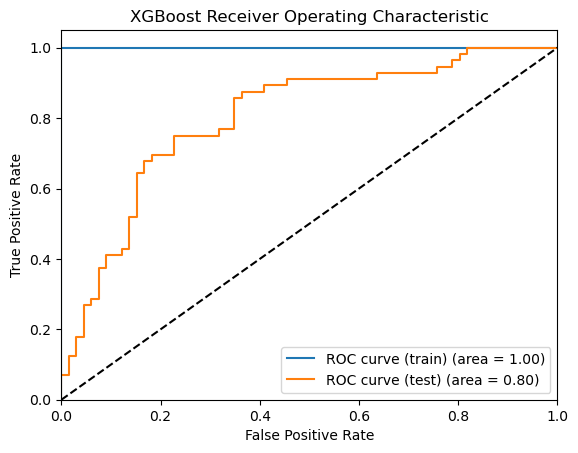

In [122]:
# Plot ROC AUC Curve
plot_roc_curve(model_xgb, X_train, y_train, X_test, y_test, 'XGBoost')

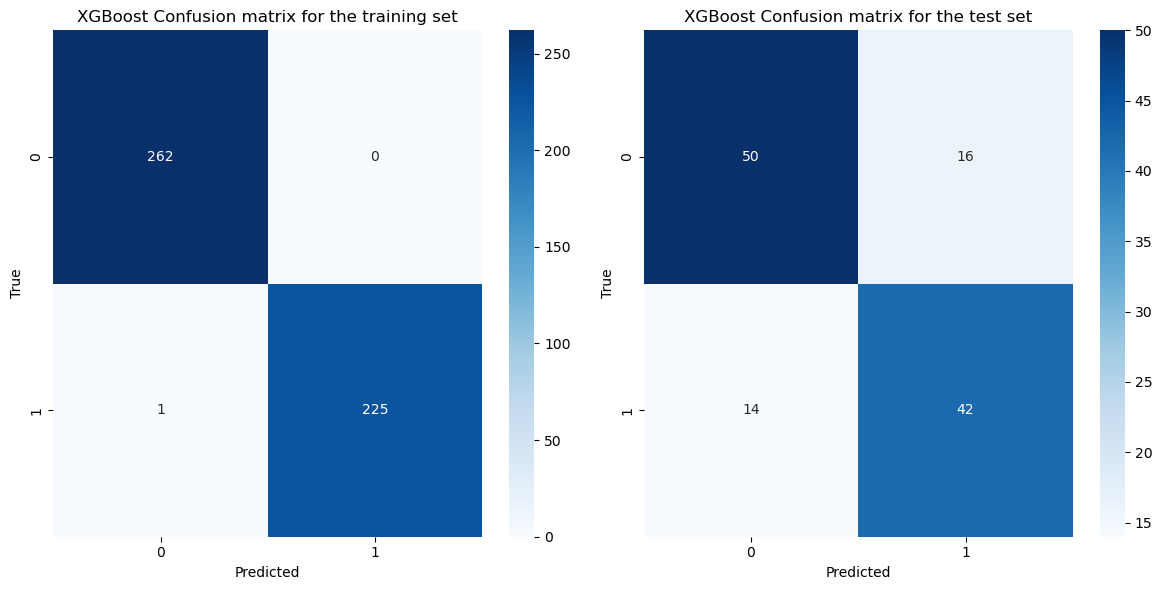

In [123]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_xgb)
cm_test = confusion_matrix(y_test,  y_test_pred_xgb)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

- It's over fitting

### Hyperparameter tuning-LogisticRegression

In [124]:
# Define the Logistic Regression pipeline
model_lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', LogisticRegression(class_weight='balanced'))
])

# Define hyperparameter distribution
param_dist = {
    'lg__C': uniform(loc=0.01, scale=2.0),  # Uniform distribution for regularization strength
    'lg__penalty': ['l1', 'l2', 'elasticnet'],  # List of regularization types
    'lg__solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs']  # List of optimization algorithms
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model_lg, param_distributions=param_dist, n_iter=50, cv=5, scoring='precision', random_state=2023)

# Fit and predict
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_lg = random_search.predict(X_train)
y_test_pred_lg = random_search.predict(X_test)

# Print classification reports
print('Logistic Regression tuned Train', '\n', classification_report(y_train, y_train_pred_lg))
print("Logistic Regression tuned Test", '\n', classification_report(y_test, y_test_pred_lg))


Best parameters: {'lg__C': 0.39935561071745607, 'lg__penalty': 'l2', 'lg__solver': 'lbfgs'}
Logistic Regression tuned Train 
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       262
           1       0.78      0.77      0.78       226

    accuracy                           0.79       488
   macro avg       0.79      0.79      0.79       488
weighted avg       0.79      0.79      0.79       488

Logistic Regression tuned Test 
               precision    recall  f1-score   support

           0       0.85      0.79      0.82        66
           1       0.77      0.84      0.80        56

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



In [125]:
# Define the Logistic Regression pipeline
model_lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', LogisticRegression())
])

# Define hyperparameter grid
param_grid = {
    'lg__C': [0.001,0.01, 0.1, 1,10],  # Regularization strength
    'lg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'lg__solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs']  # Optimization algorithm
}

# Create GridSearchCV object
grid_search = GridSearchCV(model_lg, param_grid, cv=5, scoring='f1')

# Fit and predict
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_lg = grid_search.predict(X_train)
y_test_pred_lg = grid_search.predict(X_test)

# Print classification reports
print('Logistic Regression tuned Train', '\n', classification_report(y_train, y_train_pred_lg))
print("Logistic Regression tuned Test", '\n', classification_report(y_test, y_test_pred_lg))


Best parameters: {'lg__C': 10, 'lg__penalty': 'l1', 'lg__solver': 'liblinear'}
Logistic Regression tuned Train 
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       262
           1       0.78      0.76      0.77       226

    accuracy                           0.79       488
   macro avg       0.79      0.79      0.79       488
weighted avg       0.79      0.79      0.79       488

Logistic Regression tuned Test 
               precision    recall  f1-score   support

           0       0.85      0.80      0.83        66
           1       0.78      0.84      0.81        56

    accuracy                           0.82       122
   macro avg       0.82      0.82      0.82       122
weighted avg       0.82      0.82      0.82       122



Logistic Regression tuned ROC AUC (train): 0.873
Logistic Regression tuned ROC AUC (test): 0.907


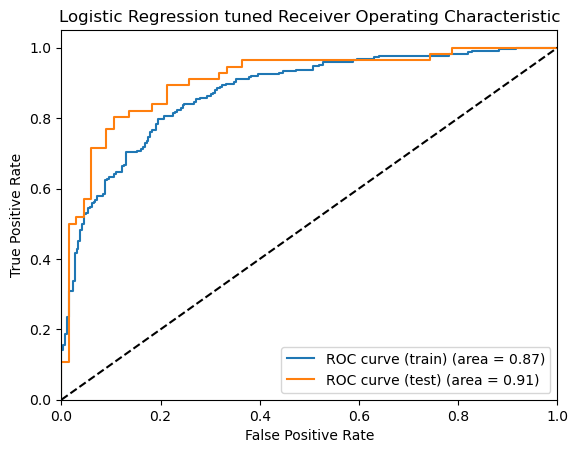

In [126]:
# Plot ROC AUC Curve
plot_roc_curve(random_search, X_train, y_train, X_test, y_test, 'Logistic Regression tuned')

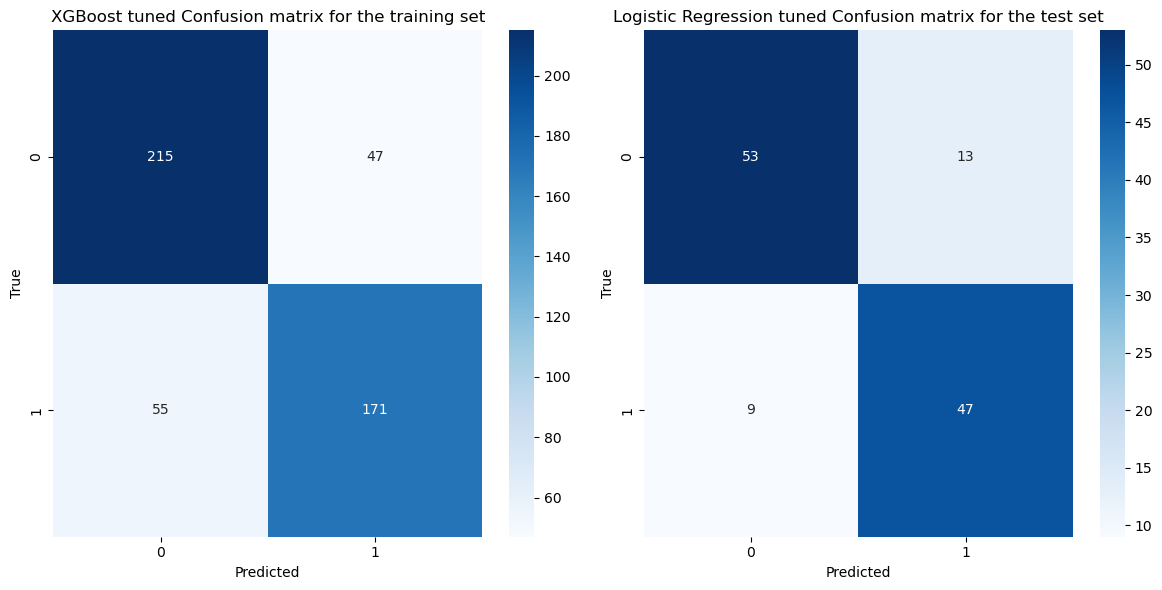

In [127]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_lg)
cm_test = confusion_matrix(y_test,  y_test_pred_lg)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Hyperparameter tuning-Random Forest

#### RandomizedSearchCV - optimizing precision 

In [128]:
model_rf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=2023))
])


# Define hyperparameter distribution
param_dist = {
    'rf__n_estimators': randint(50, 500),
    'rf__max_depth': randint(1, 20),
    'rf__min_samples_split': randint(2, 20),
    'rf__min_samples_leaf': randint(1, 20),
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model_rf_bal, param_dist, n_iter=50, cv=5, scoring='precision', random_state=2023)

# Fit and predict
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_rf = random_search.predict(X_train)
y_test_pred_rf = random_search.predict(X_test)

# Print classification reports
print('Random Forest tuned Train', '\n', classification_report(y_train, y_train_pred_rf))
print("Random Forest tuned Test", '\n', classification_report(y_test, y_test_pred_rf))


Best parameters: {'rf__max_depth': 16, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 4, 'rf__n_estimators': 108}
Random Forest tuned Train 
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       262
           1       0.92      0.95      0.93       226

    accuracy                           0.94       488
   macro avg       0.94      0.94      0.94       488
weighted avg       0.94      0.94      0.94       488

Random Forest tuned Test 
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        66
           1       0.77      0.77      0.77        56

    accuracy                           0.79       122
   macro avg       0.79      0.79      0.79       122
weighted avg       0.79      0.79      0.79       122



Random Forest tuned ROC AUC (train): 0.989
Random Forest tuned ROC AUC (test): 0.869


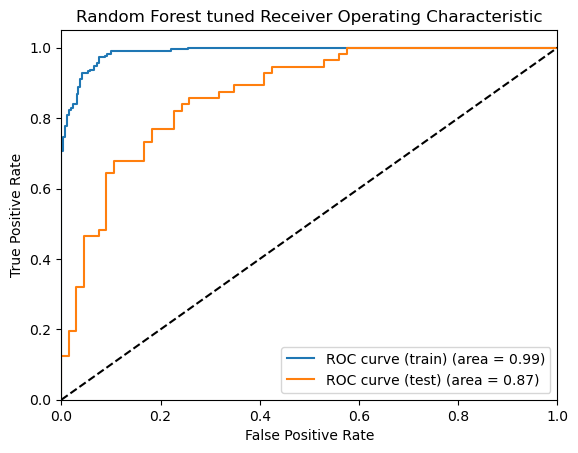

In [129]:
# Plot ROC AUC Curve
plot_roc_curve(random_search, X_train, y_train, X_test, y_test, 'Random Forest tuned')

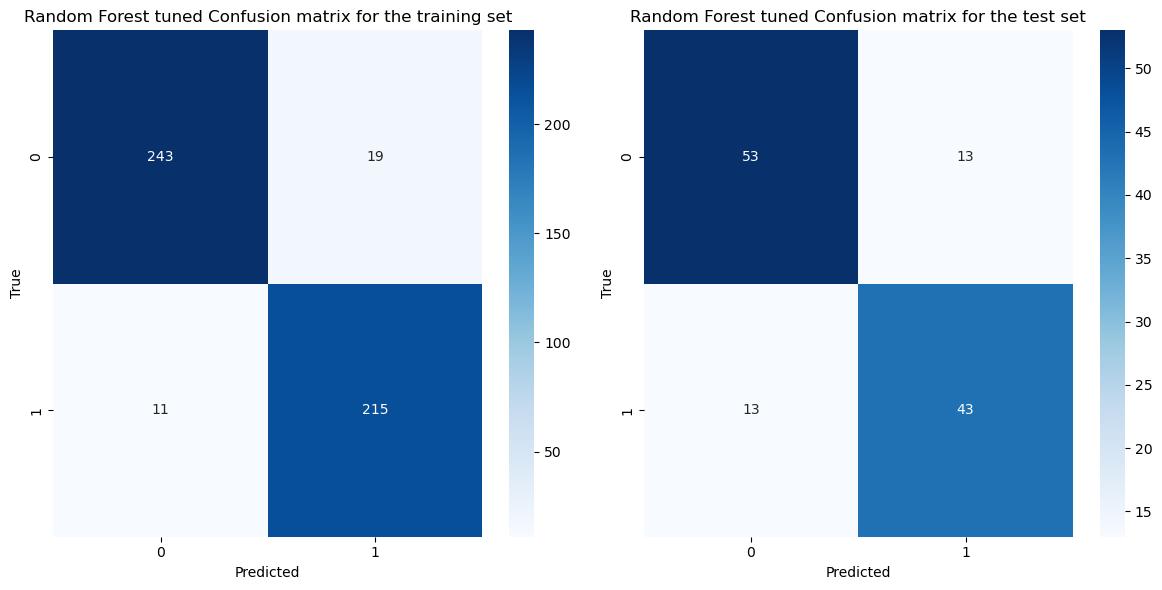

In [130]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_rf)
cm_test = confusion_matrix(y_test,  y_test_pred_rf)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### GridSearchCV - optimizing precision

In [131]:
model_rf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=2023))
])


# Define hyperparameter distribution
param_grid = {
    'rf__n_estimators': [50, 100, 200, 300, 500],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

# Create GridSearchCV object
grid_search = GridSearchCV(model_rf_bal, param_grid, cv=5, scoring='precision')

# Fit and predict
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_rf = grid_search.predict(X_train)
y_test_pred_rf = grid_search.predict(X_test)

# Print classification reports
print('Random Forest Train', '\n',classification_report(y_train, y_train_pred_rf))
print("Random Forest Test", '\n',classification_report(y_test, y_test_pred_rf))

Best parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Random Forest Train 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       262
           1       1.00      1.00      1.00       226

    accuracy                           1.00       488
   macro avg       1.00      1.00      1.00       488
weighted avg       1.00      1.00      1.00       488

Random Forest Test 
               precision    recall  f1-score   support

           0       0.76      0.79      0.78        66
           1       0.74      0.71      0.73        56

    accuracy                           0.75       122
   macro avg       0.75      0.75      0.75       122
weighted avg       0.75      0.75      0.75       122



Random Forest ROC AUC (train): 1.000
Random Forest ROC AUC (test): 0.851


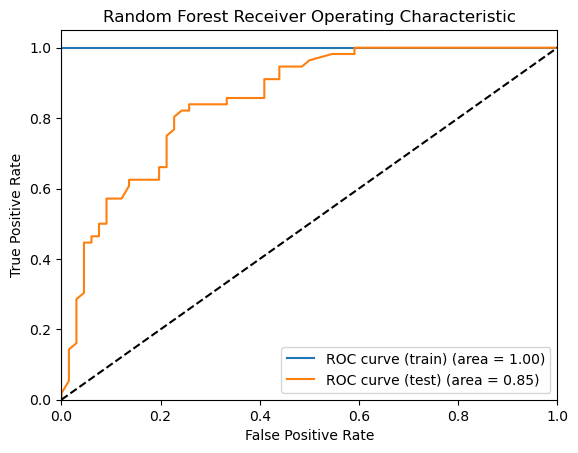

In [132]:
# Plot ROC AUC Curve
plot_roc_curve(grid_search, X_train, y_train, X_test, y_test, 'Random Forest')

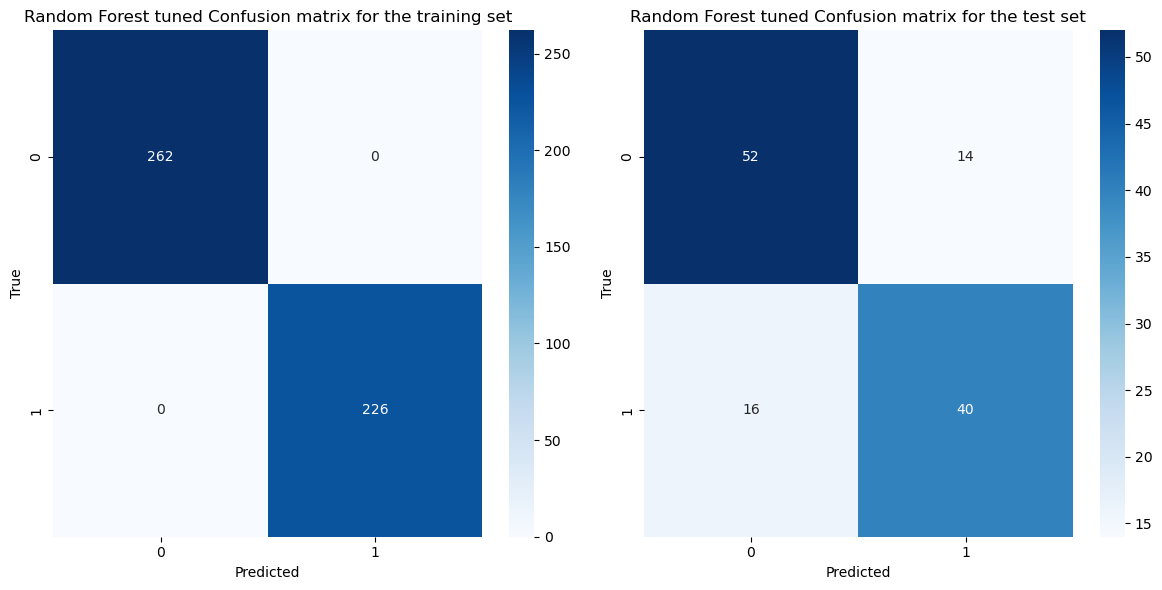

In [133]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_rf)
cm_test = confusion_matrix(y_test,  y_test_pred_rf)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

### Hyperparameter tuning-XGboost

In [134]:
# Define pipeline
model_xgb= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Define hyperparameter distribution
param_dist = {
    'xgb__n_estimators': randint(50, 500),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__max_depth': randint(1, 10)
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(model_xgb, param_dist, n_iter=50, cv=5, scoring='precision', random_state=2023)

# Fit and predict
random_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = random_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_xgb = random_search.predict(X_train)
y_test_pred_xgb = random_search.predict(X_test)

# Print classification reports
print('XGBoost tuned Train', '\n',classification_report(y_train, y_train_pred_xgb))
print("XGBoost tuned Test", '\n',classification_report(y_test, y_test_pred_xgb))

Best parameters: {'xgb__learning_rate': 0.09740819449099884, 'xgb__max_depth': 8, 'xgb__n_estimators': 86}
XGBoost tuned Train 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       262
           1       0.99      0.99      0.99       226

    accuracy                           0.99       488
   macro avg       0.99      0.99      0.99       488
weighted avg       0.99      0.99      0.99       488

XGBoost tuned Test 
               precision    recall  f1-score   support

           0       0.78      0.77      0.78        66
           1       0.74      0.75      0.74        56

    accuracy                           0.76       122
   macro avg       0.76      0.76      0.76       122
weighted avg       0.76      0.76      0.76       122



XGBoost tuned ROC AUC (train): 0.999
XGBoost tuned ROC AUC (test): 0.825


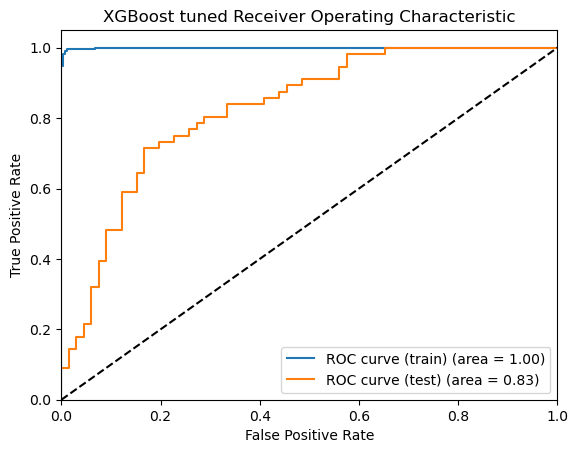

In [135]:
# Plot ROC AUC Curve
plot_roc_curve(random_search, X_train, y_train, X_test, y_test, 'XGBoost tuned')

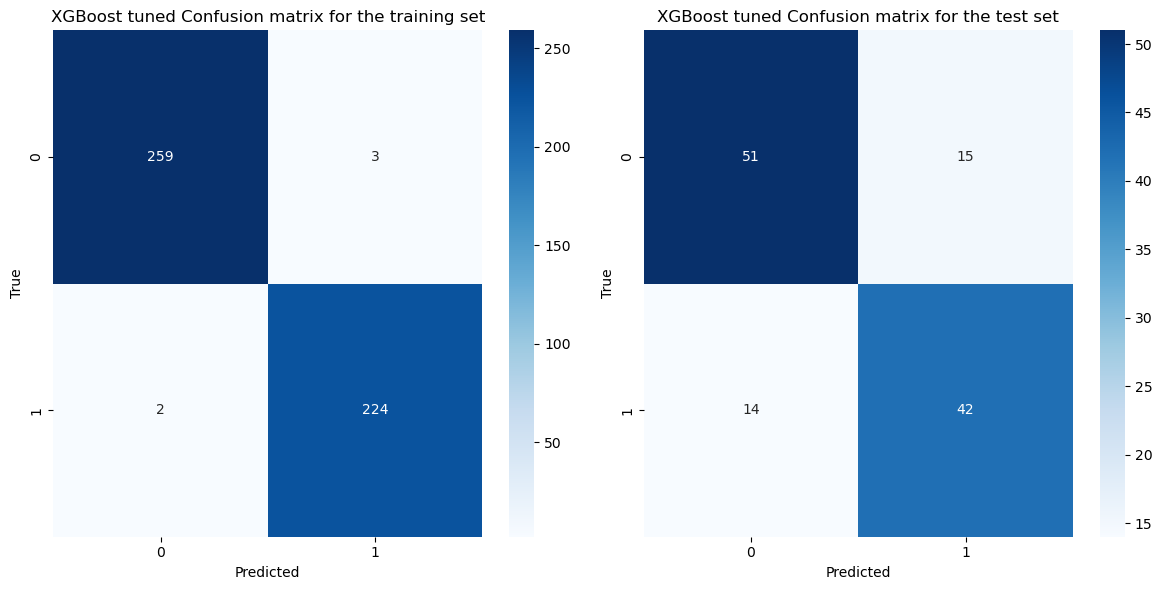

In [136]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_xgb)
cm_test = confusion_matrix(y_test,  y_test_pred_xgb)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

#### GridSearchCV - optimizing recall

In [137]:
# Define pipeline
model_xgb= imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=2023)),
    ('xgb', XGBClassifier(random_state=2023, use_label_encoder=False, eval_metric='logloss'))
])

# Define hyperparameter grid
param_grid = {
    'xgb__n_estimators': [460, 465, 470],
    'xgb__learning_rate': [0.17, 0.18, 0.19],
    'xgb__max_depth': [1, 2]
}

# Create GridSearchCV object
grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='precision')

# Fit and predict
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print("Best parameters:", best_parameters)

# Predict using the model with the best parameters
y_train_pred_xgb = grid_search.predict(X_train)
y_test_pred_xgb = grid_search.predict(X_test)

# Print classification reports
print('XGBoost Train', '\n',classification_report(y_train, y_train_pred_xgb))
print("XGBoost Test", '\n',classification_report(y_test, y_test_pred_xgb))

Best parameters: {'xgb__learning_rate': 0.17, 'xgb__max_depth': 2, 'xgb__n_estimators': 470}
XGBoost Train 
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       262
           1       0.93      0.95      0.94       226

    accuracy                           0.94       488
   macro avg       0.94      0.94      0.94       488
weighted avg       0.94      0.94      0.94       488

XGBoost Test 
               precision    recall  f1-score   support

           0       0.76      0.76      0.76        66
           1       0.71      0.71      0.71        56

    accuracy                           0.74       122
   macro avg       0.74      0.74      0.74       122
weighted avg       0.74      0.74      0.74       122



XGBoost tuned ROC AUC (train): 0.979
XGBoost tuned ROC AUC (test): 0.804


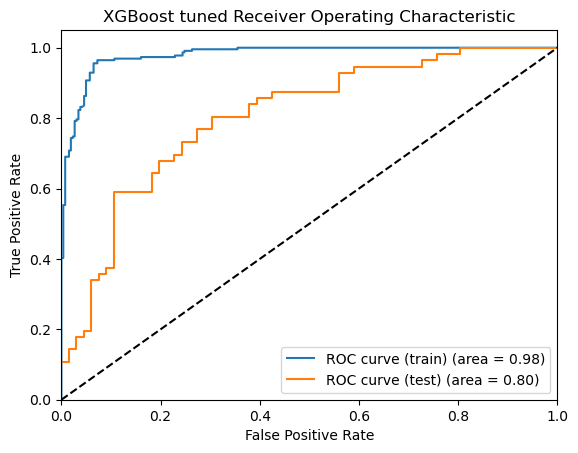

In [138]:
# Plot ROC AUC Curve
plot_roc_curve(grid_search, X_train, y_train, X_test, y_test, 'XGBoost tuned')

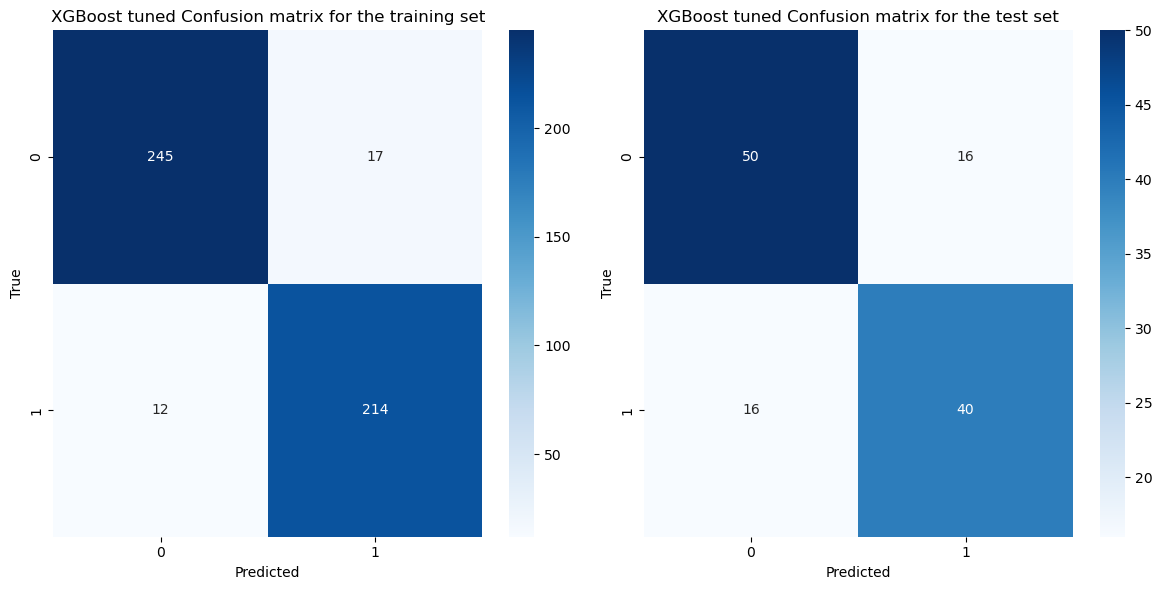

In [139]:
# Calculate confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred_xgb)
cm_test = confusion_matrix(y_test,  y_test_pred_xgb)

plt.figure(figsize=(12, 6))

# Plot confusion matrix for the training set
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the training set')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix for the test set
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost tuned Confusion matrix for the test set')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

- After hyperparameter tuning, XGBoost doesn't perform better than Logistic Regression. 
- So I'll still choose Logistic Regression as the best model.

# Post-model Analysis

## Comparision of Model 1 & Model 2

Test performance in Logistic Regression of two models: 
- Recall: Model 1(0.97) > Model 2 (0.96)
- Precision: Model 1(0.86) > Model 2 (0.85)
- F1-score: Model 1(0.91) > Model 2 (0.90)
- ROC-AUC: Model 1(0.993) > Model 2 (0.989)

Model 1 performs a little bit better than Model 2. However, Model 1 used 22 features while Model 2 only used 5 features. Considerring computational resources, Model 2 is a better chioce for predicting customer churning.

## Actionable suggestions

**Likely to churn:**
- Satisfaction Score is the most predictive variable of a customer churning, we should pay the most attention to low satisfaction score customers

- Likely to churn customers:
    - Low satisfaction score
    - Doesn’t subscribe to an additional online security service
    - Doesn’t have dependents
    - Month-to-Month contract type
    - Doesn’t have referrals

## To do list

**Improve model performance:**
- Try log or square root transformation for skewed features.
- Try 'senior citizen' rather than 'age' for modelling.
- Try create bins for discret numerical features: e.g. 'total refunds'.
- Try different oversampling or downsampling methods.
- Try other models (for example, LGBM).
- Fine tuning hyperparameter.
- Dig out reasons for outliers and missing values.

**Calculate business values**
- Optimal revenue

**Others**
- Extract more common functions or classes and reuse them.
- Simplify codes and improve codes style.
- Better visualization.